In [2]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
from pprint import pprint
import statsmodels.api as sms
from pyd3 import interpolate, color
import matplotlib
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

from SensorBlockchainNetwork.analyze import *
from SensorBlockchainNetwork.SensorBlockchainNetwork import *

matplotlib.pyplot.style.use('seaborn-muted')
plt = matplotlib.pyplot
color_interpolator = interpolate.rgb('blue', 'red')

In [3]:
files = [file for file in os.listdir('./data/final/') if 'pickles' not in file ]
model_dataframes = {}

In [5]:
for file in files:

    model_dataframes[file.replace('.pkl', '')] = get_model_vars_df_from_pickle('./data/final/' + file)

## Investigating effect of network size on dependent variables

### Effects on mining dynamics

In [6]:
num_sensors_results = {
    'mining': {}, 
    'info_currency': {},
    'gwei_spent': {}
}

In [7]:
num_sensors_model_df = model_dataframes['batch_run_1_num_sensors']

In [10]:
num_sensors_model_df[['mining_mean']].describe()

mining_mean
count    30.000000
mean     47.346000
std      33.755346
min       1.004044
25%      13.321907
50%      46.593436
75%      80.739841
max      95.189465

In [9]:
num_sensors_model_df[['num_sensors', 'mining_mean']].corr()

num_sensors  mining_mean
num_sensors     1.000000     0.971728
mining_mean     0.971728     1.000000

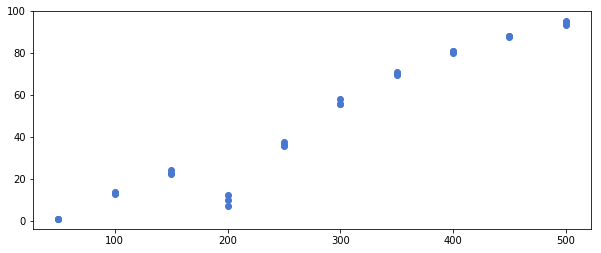

In [11]:
plt.figure(figsize=(10,4))
plt.scatter(num_sensors_model_df['num_sensors'], num_sensors_model_df['mining_mean'])


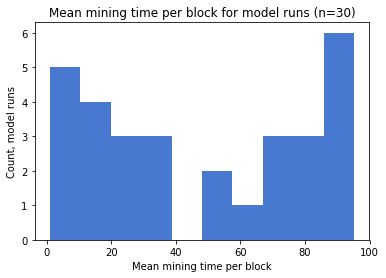

In [12]:
plt.hist(num_sensors_model_df['mining_mean'])
plt.xlabel('Mean mining time per block')
plt.ylabel('Count, model runs')
_ = plt.title("Mean mining time per block for model runs (n=30)")
# plt.savefig('./outputs/figures/num-sensors/mining-mean/hist.svg')

### Interpretation

Are LINE conditions met? 

Linear: It does not appear so, though roughly, yes.
Independent 

In [13]:
num_sensors_results['mining']['pearson'] = num_sensors_model_df[['num_sensors', 'mining_mean']].corr()

num_sensors_results['mining']['X_values'] = sms.add_constant(num_sensors_model_df['num_sensors'])
num_sensors_results['mining']['regression_model'] = sms.OLS(num_sensors_model_df['mining_mean'], num_sensors_results['mining']['X_values']).fit()
print(num_sensors_results['mining']['regression_model'].summary())

                            OLS Regression Results                            
Dep. Variable:            mining_mean   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     474.3
Date:                Fri, 16 Aug 2019   Prob (F-statistic):           4.29e-19
Time:                        17:49:44   Log-Likelihood:                -104.33
No. Observations:                  30   AIC:                             212.7
Df Residuals:                      28   BIC:                             215.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -14.4075      3.199     -4.504      

In [14]:
# *** change away from using generic variable names ... or define a class? 
gradient = num_sensors_results['mining']['regression_model'].params[1]
intercept = num_sensors_results['mining']['regression_model'].params[0]
rsquared = num_sensors_results['mining']['regression_model'].rsquared
pval = num_sensors_results['mining']['regression_model'].f_pvalue

In [15]:
num_sensors_results['mining']['x_lobf'] = [num_sensors_model_df['num_sensors'].min(), num_sensors_model_df['num_sensors'].max()]
num_sensors_results['mining']['y_lobf'] = [num_sensors_results['mining']['x_lobf'][0]*gradient + intercept, num_sensors_results['mining']['x_lobf'][1]*gradient + intercept]

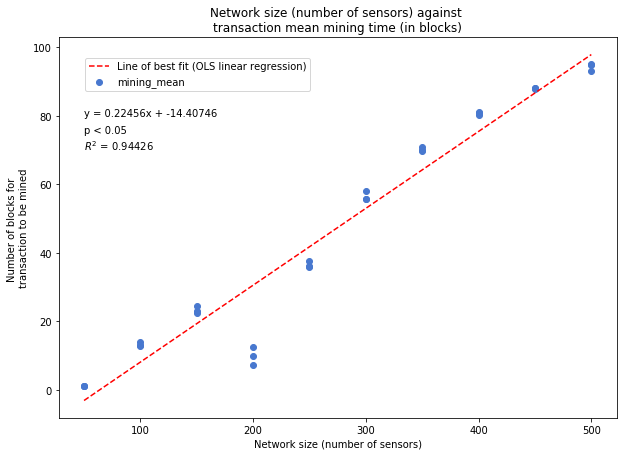

In [16]:
# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))

# plt.errorbar(num_sensors_model_df['num_sensors'], num_sensors_model_df['mining_mean'], yerr=num_sensors_model_df['mining_std'], fmt='o', label="Mean mining time in blocks +/- 1σ ")
plt.scatter(num_sensors_model_df['num_sensors'], num_sensors_model_df['mining_mean'])
plt.plot(num_sensors_results['mining']['x_lobf'], num_sensors_results['mining']['y_lobf'], 'r--', label="Line of best fit (OLS linear regression)" )
plt.legend(bbox_to_anchor=(0.46, 0.96))
plt.text(50, 80, "y = " + str(round(gradient, 5)) + 'x + ' + str(round(intercept, 5)))
plt.text(50,75,"p < 0.05 ")
plt.text(50,70,r"$R^2$ = " + str(round(rsquared, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Network size (number of sensors)')
_ = plt.ylabel('Number of blocks for \ntransaction to be mined')
_ = plt.title("Network size (number of sensors) against \ntransaction mean mining time (in blocks)")

# plt.savefig('./outputs/figures/num-sensors/mining-mean/scatter-OLS.svg')

### Investigating transformations

In [19]:
num_sensors_model_df_small_networks = num_sensors_model_df[num_sensors_model_df['num_sensors'] < 200]
num_sensors_model_df_large_networks = num_sensors_model_df[num_sensors_model_df['num_sensors'] >= 200]

In [20]:
num_sensors_model_df_large_networks['num_sensors_log'] = np.log(num_sensors_model_df_large_networks['num_sensors'])

/Users/iv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
num_sensors_results['mining_log']= {}
num_sensors_results['mining_log']['pearson'] = num_sensors_model_df_large_networks[['num_sensors_log', 'mining_mean']].corr()

num_sensors_results['mining_log']['X_values'] = sms.add_constant(num_sensors_model_df_large_networks['num_sensors_log'])
num_sensors_results['mining_log']['regression_model'] = sms.OLS(num_sensors_model_df_large_networks['mining_mean'], num_sensors_results['mining_log']['X_values']).fit()
print(num_sensors_results['mining_log']['regression_model'].summary())

                            OLS Regression Results                            
Dep. Variable:            mining_mean   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1073.
Date:                Fri, 16 Aug 2019   Prob (F-statistic):           3.51e-18
Time:                        17:50:36   Log-Likelihood:                -57.361
No. Observations:                  21   AIC:                             118.7
Df Residuals:                      19   BIC:                             120.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -472.6139     16.352    -

In [22]:
# *** change away from using generic variable names ... or define a class? 
gradient = num_sensors_results['mining_log']['regression_model'].params[1]
intercept = num_sensors_results['mining_log']['regression_model'].params[0]
rsquared = num_sensors_results['mining_log']['regression_model'].rsquared
pval = num_sensors_results['mining_log']['regression_model'].f_pvalue

In [23]:
num_sensors_results['mining_log']['x_lobf'] = [num_sensors_model_df_large_networks['num_sensors_log'].min(), num_sensors_model_df_large_networks['num_sensors_log'].max()]
num_sensors_results['mining_log']['y_lobf'] = [num_sensors_results['mining_log']['x_lobf'][0]*gradient + intercept, num_sensors_results['mining_log']['x_lobf'][1]*gradient + intercept]

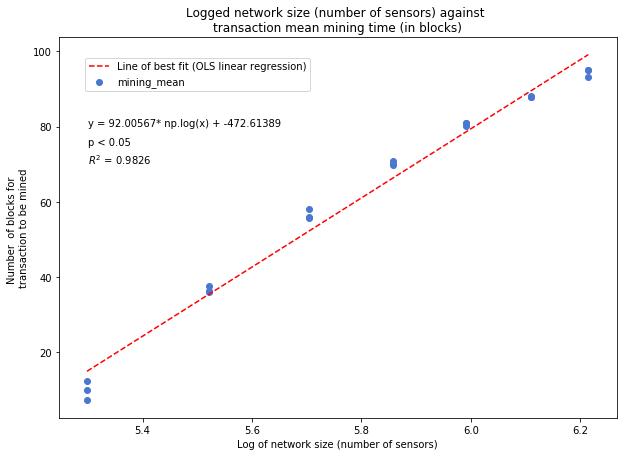

In [24]:
# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))

# plt.errorbar(num_sensors_model_df['num_sensors'], num_sensors_model_df['mining_mean'], yerr=num_sensors_model_df['mining_std'], fmt='o', label="Mean mining time in blocks +/- 1σ ")
plt.scatter(num_sensors_model_df_large_networks['num_sensors_log'], num_sensors_model_df_large_networks['mining_mean'])
plt.plot(num_sensors_results['mining_log']['x_lobf'], num_sensors_results['mining_log']['y_lobf'], 'r--', label="Line of best fit (OLS linear regression)" )
plt.legend(bbox_to_anchor=(0.46, 0.96))
plt.text(5.3, 80, "y = " + str(round(gradient, 5)) + '* np.log(x) + ' + str(round(intercept, 5)))
plt.text(5.3,75,"p < 0.05 ")
plt.text(5.3,70,r"$R^2$ = " + str(round(rsquared, 5)))

# add Rdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAYHwAAAHICAYAAADc5hhRAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzs1HmUpmV5J+DfXTSLSLMoKosssRFEVFCTiBkQHD0uuOGoBIMKjhiJS4a4kbgQyODGiQuMeBQNLqAo7jLCuIyCY6KComgQVFCgWYWWBhob0o33/FFvxc+yqrqabvpDvK5z6vT3vs/2e+7nebu6OwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8MdmYtwBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgHCbGHQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMZhYtwBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgHCbGHQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMZhYtwBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgHCbGHQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMZhYtwBgElVtWNVdVUtGHeWNTHsYac1nOPMqjp4bWUamfctVXX42p53HuvuW1VXrOt1R9Z/ZlUtrqplVfXwceVY26rqHVV12JjWfl1VfWAcawMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABrT3X3uDPAOlFVlyY5tLu/Ou4sM6mqHZP8Isn63b1yLc99adbR3quqkzywuy++s9daHVV1nyQ/SLJTdy9fx2vvm+SU7r7/ulx3ZP1Lkryyuz8/jvXvLFW1dZJzkizq7v8Yd57VdWd+8wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMD8TIw7AHD3UFULxp1hFQ5JckZ3Lx93kDVxB+u8Q5IL1naWO9uq9trdVye5KMnT100iAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4O5mYtwB4K6gql5cVRdX1a+q6gtVtc1I2xOq6idVdWNVvaeqzq6qQ4e29arq7VV1fVX9oqpeXlVdVQuG9s2q6l+q6uqqurKqjqmq9UbG/vMw9udJnrKKjJdW1aur6odDlk9U1UYj7U+tqh9U1dKq+reqetjw/uQk2yc5vaqWVdVrq+rDVfWqoX3bIfNLh+edhjrUPGrTVfWyqvpZkp/NkHmvqlpcVY+doW2jqjqlqpYMmc+tqvsNbWeN1Pj8IffUX1fVvkPbnsNelw799p2jhE9OcvbI+vtW1RVV9aqq+uVwRi8caf/PDMPzIVX1zWl7f2lV/ayqbq6q/1lVi6rqW1V1U1WdVlUbTNvz64bzvrSqDhp5v+FwFy6vqmur6r1VdY9pOY+oqmuSfHCGWk5U1Ruq6rJhLx8Z7t6GVbUsyXpJzq+qS2YYW1X1zmHcjcP9eshq5JqtfvtV1Y+H2lxZVa8eaZv3nZor3+CszPHtVNUnq+qaYew3qmq3kbZ7V9Xpw3mdW5Pf5+gZHzfc35uq6ntVtfdI21FVdcrwe8ch98FDra6vqteP9P3zqvruMM+1VfWOoekbw79Lh7v96Nn2AQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANw5JsYdAMatqv5rkrckOSDJ1kkuS/LxoW3LJJ9K8g9J7p3kJ0n+YmT4i5M8OckeSR6RZP9p0384ycokOyV5eJInJDl0ZOxTh/d/muTZ84h7QJInJfmTJA9LcsiQ8xFJTkrykiHn+5J8oao27O7nJ7k8ydO6e5PuPjbJ2Un2HebcJ8nPh3+T5DFJ/l9391y1GbF/kkclefDoy6p6YpJTkzyru78+w14OTrJZku2GzIclWT69U3fvPuTeJMkrM3kG51XVtkm+mOSYJPdK8uokn66q+8xSu4cOY0dtNWTYNsmLkpxQVVvMMn4mT0ryyCR7JnltkhOTHDTs6SFJnjttrS2HtQ5OcmJV7TK0vS3Jzpm8RzsNfY6cNvZeSXZI8tcz5Dhk+Htskgck2STJu7v7tqFuSbJ7dy+aYewTMnnmOyfZPMlfJlmyGrlmq9+/JHlJdy8cavG1ZO7vbcTonZorX5JcmGT3GfY15cwkD0xy3yTnJfnoSNsJSW4Z9nHw8Dfq3GHv90rysSSfrKqN5lhrryS7JHlckiOratfh/XFJjuvuTZMsSnLa8P4xw7+bD3f8W3PMDQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANwJJsYdAO4CDkpyUnef1923JfmHJI+uqh2T7Jfkgu7+THevTHJ8kmtGxh6Q5LjuvqK7b0jy1qmGqrpfkicnOby7b+nuXyZ5Z5IDR8a+q7sXd/evkrxlHlmP7+6rhv6nJ9ljeP/iJO/r7u909+3d/eEktyXZc5Z5zk6yd1VNJHlMkmOT/JehbZ+hfVW1mfKW7v5Vdy8fefecJCcm2a+7z5klw4ok906y05D5e91902wbr6q9khyT5OlDv+clOaO7z+ju33T3V5J8N5NnNpPNk9w8Q4Z/6u4V3X1GkmVJdpktwwze1t03dfcFSf49yZe7++fdfWOSM5M8fFr/N3b3bd19dpIvJjmgqiqT5/d3Qx1vTvLm/PaeJMlvkvzjMHZ5ft9BSd4xrL0sk+d0YFUtmMceViRZmORBSaq7L+zuq+eZa676rUjy4KratLtv6O7zRrKuzp2aMd9I35szebYz6u6TuvvmYa2jkuxeVZtV1XpJnpXJuv66u3+c5MPTxp7S3Uu6e2V3vz3Jhpn7fhzd3cu7+/wk5yfZfaQWO1XVlt29rLu/PcccAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwDo0Me4AcBewTZLLph66e1mSJUm2HdoWj7R1kiumjV088jz6e4ck6ye5uqqWVtXSJO9Lct9Zxl6WVbtm5Pevk2wystarptYZ1tpuWOP3dPclSZYl2SPJ3kn+d5KrqmqXJPskOXsk42y1mWnPUw5Pclp3/2iOvZyc5EtJPl5VV1XVsVW1/kwdq2q7JKclObi7fzqy5+dM2/NeSbaeZb0bkiyc9m5Jd68ceR6t6XxcO/J7+QzPo3Pd0N23jDxflsn63ifJxkm+N7KP/zO8n3Jdd986R47fOafh94Ik91vVBrr7a0neneSEJNdW1YlVtek8c81Vv2cl2S/JZVV1dlU9eqasq7pTc+SbsjDJ0pn2VlXrVdVbq+qSqropyaVD05bDPhZk9u83VfWqqrqwqm4c9r/ZMHY2s32fL0qyc5KLqurcqnrqHHMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA69DEuAPAXcBVSXaYeqiqeya5d5Irk1yd5P4jbTX6PL09yXYjvxcnuS3Jlt29+fC3aXfvNjJ2tP/2a7CHxUneNLLO5t29cXefOrT3DGPOTvLsJBt095XD8wuSbJHkB0OfuWozZaa5n5Nk/6o6fLbA3b2iu4/u7gcn+YskTx3W/x1VdY8kn0vyru4+c9qeT56253t291tnWfKHSXaeLc8Mbkmy8cjzVqsxdiZbDPWbsn0m63t9kuVJdhvZx2bdvclI35lqPOp3zmmYe2WSa+cTrLuP7+5HJtktkzV6zTxzzTXnud39jCT3zeT5nTZT1vncqVnyTdk1yfmzxPirJM9I8vgkmyXZcWrZJNdlskYzfr9VtXeSI5IckGSL7t48yY3D2NXS3T/r7udmshZvS/KpYd+rOlcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgTjYx7gCwjq1fVRuN/C1I8rEkL6yqPapqwyRvTvKd7r40yReTPLSq9h/6vizJViPznZbkf1TVtlW1eZIjphq6++okX07y9qratKomqmpRVe0zMvZvq+r+VbVFkr9fg329P8lhVfWomnTPqnpKVS0c2q9N8oBpY85O8vIk3xiez0ryiiTf7O7bh3dz1WYuVyV53LC/l87UoaoeW1UPrar1ktyUZEWS22foelKSi7r72GnvT0nytKp6YlWtN5znvlV1/1kynZFkn1naZvKDJP+tqjauqp2SvGg1xs7m6KraoKr2TvLUJJ/s7t9k8vzeWVX3TZLhPj1xNeY9NcnfVdWfVNUmmTynT3T3ylUNrKo/G+7N+kluSXJrktvXJNewx4OqarPuXpHJ871Dd2q2fCNd9kly5ixRFia5LcmSJBsPayVJhjv+mSRHDWf8oCQvmDZ2ZZLrkiyoqiOTbLqqvc+yh+dV1X2Gmi4dXt8+zP2b/P63CQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKwjE+MOAOvYGUmWj/wd1d3/N8kbk3w6ydVJFiU5MEm6+/okz0lybJIlSR6c5LtJbhvme3+SLyf5YZLvD/OvTHL70P6CJBsk+XGSG5J8KsnWI2O/lOT8JOcl+cwd3VR3fzfJi5O8e1jn4iSHjHR5S5I3VNXSqnr18O7sJAuTfGN4/maSjUeeM1dt5pHp8iSPS3JEVR06Q5etMlmPm5JcOOQ5ZYZ+ByZ5ZlUtG/nbu7sXJ3lGktcluS7J4iSvyez/r30kyX5VdY/55E/yziT/keTaJB9O8tF5jpvNNZk8m6uGuQ7r7ouGtiMyeWbfrqqbknw1yS6rMfdJSU7O5Nn9IsmtSV4xz7GbZvIu3pDkskze839eC7men+TSYdxhSZ6X3KE7NWu+qto6k9/k52YZ+5FhzJWZ/Aa/Pa395Uk2y+TZnJzk1Pz22/5SkjOT/HSY49ZM3rE74klJLqiqZUmOS3Jgd9/a3b9O8qYk/zp8m3vewfkBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAO6i6e9wZ4A9GVU0kuSLJQd399Rnan5zkvd29wzoPxypV1ZuT/LK73zXuLKy5qnp7kku6+z1rab63Jdmquw9eG/MBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAd33V3ePOAHdpVfXEJN9JsjzJa5K8LMkDunt5Vd0jyWOTfDnJ/ZJ8Osm3u/vwceUF5qeqHpRkgyQ/SvJnSc5Icmh3f26swQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIB1ZmLcAeAPwKOTXJLk+iRPS7J/dy8f2irJ0UluSPL9JBcmOXIcIYHVtjDJZ5LckuS0JG9P8vmxJgIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADWqerucWcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIB1bmLcAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYBwmxh0AuOuqqguqat9x57irWp36rMtaVtV7q+qN62itDavqx1W11ZquXVVnVdWhs7TtWFVdVQvWMG9X1U6rOeYdVXXYmqwLAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA3DVVd487A9ztVNWlSQ7t7q+OO8t8VdWHklzR3W8Ydxbmr6oOyeRd22tM678iyW7dfdhamOusJKd09wdmaNsxyS+SrN/dK9dgjU7ywO6+eDXGbJ3knCSLuvs/7ujaAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwF3PxLgDwB+jqlow7gywlrwkycnjDnFn6u6rk1yU5OnjzgIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACsXRPjDgB3N1V1cpLtk5xeVcuq6rVVtWNVdVW9qKouT/K1oe8nq+qaqrqxqr5RVbuNzPOhqjqhqr5YVTdX1XeqatHQVlX1zqr65TD2h1X1kKHtKVX1/aq6qaoWV9VR0/LtVVX/VlVLh/ZDquqvkxyU5LVD5tOHvpdW1eOH3xtW1buq6qrh711VteHQtm9VXVFVrxoyXV1VL5yjRmdV1TFDjmVVdXpV3buqPjrkPreqdhzp/6Cq+kpV/aqqflJVB4y0zbrfkbofXFWXV9X1VfX6OXJ9qKreU1VnDrn+taq2GvZ6Q1VdVFUPH+k/Wp+jquq0qvrIcF4XVNWf3sG+jxj2dPNwRz5RVcfMkHfXJO9N8ugh79KRfRwz7WxeO3I2+1fVflX106GmrxuZc6Kq/r6qLqmqJUPOe81Sr+2TLErynWk1nL72vO7FYFFVnTPc68/PsfY2VfWFIf/FVfXikbb1qup1wx5urqrvVdV2M8yx13BnHluTZvymBmclecoqsgMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB/YCbGHQDubrr7+UkuT/K07t6ku48dad4nya5Jnjg8n5nkgUnum+S8JB+dNt1zkxydZIskFyd50/D+CUkek2TnJJsn+cskS4a2W5K8YHj/lCR/U1X7J0lVbT+s+b+S3CfJHkl+0N0nDmsfO2R+2gxbe32SPYcxuyf58yRvGGnfKslmSbZN8qIkJ1TVFnOU6sAkzx/6L0ryrSQfTHKvJBcm+cch8z2TfCXJx4Y6PTfJe6pqt1Xtd8ReSXZJ8rgkR1bVrnPkOmDY15ZJbhtynTc8fyrJO+YY+/QkHx+yfCHJu1e3b1VtkOSzST6UyVqcmuSZM03Q3RcmOSzJt4Zz23yWtbZKslEma31kkvcneV6SRybZO5M1ecDQ92+T7J/Ju7pNkhuSnDDLvA9N8vPuXjnHPlf3XrwgyX8f1l6Z5PhZ+p2a5Iqh37OTvLmqHje0vTKT92S/JJsO8/16dHBVPXGY41nd/fXM/U0lk3dy9zlyAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH+AJsYdAP7IHNXdt3T38iTp7pO6++buvi3JUUl2r6rNRvp/prvP6e6VST6aZI/h/YokC5M8KEl194XdffUw51nd/aPu/k13/zDJqUn2GcYdlOSr3X1qd6/o7iXd/YN5Zj8oyT919y+7+7okRyd5/kj7iqF9RXefkWRZkl3mmO+D3X1Jd9+Y5Mwkl3T3V4e9fjLJw4d+T01yaXd/sLtXdvd5ST6d5Nnz2O+Uo7t7eXefn+T8JLvPkeuz3f297r41yWeT3NrdH+nu25N8YiTXTL7Z3WcMfU9exTqz9d0zyYIkxw+1/EySc+aYZz5WJHlTd69I8vEkWyY5brh7FyS5IMnDhr4vSfL67r5i5F4+u6oWzDDv5klunsfaq3MvTu7uf+/uW5K8MckBVbXeaIeq2i7JXkmO6O5bhzv8gfz2Ph6a5A3d/ZOedH53LxmZ4jlJTkyyX3dP1XbWb2pw87BfAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4G5kYtwB4I/M4qkfVbVeVb21qi6pqpuSXDo0bTnS/5qR379OskmSdPfXkrw7yQlJrq2qE6tq02HeR1XV16vquqq6MclhI3Nul+SSO5h9mySXjTxfNrybsqS7V86UdxbXjvxePsPz1NgdkjyqqpZO/SU5KMlWySr3O2XGOq5hrplMX2ejqlqwmn23SXJld/dI++KsmSXdffvwe/nw71z1/uxIrS9McnuS+80w7w1JFs5j7dW5F6N7vSzJ+vn989wmya+6++Zpfbcdfq/qnh+e5LTu/tHUi7m+qcHCJEvnmBMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD4AzQx7gBwN9XzeP9XSZ6R5PFJNkuy4/C+5rVA9/Hd/cgkuyXZOclrhqaPJflCku26e7Mk7x2Zc3GSRauZecpVSXYYed5+eHdnW5zk7O7efORvk+7+m6F9rv3+Ibo6ybZVNbqH7ebov6pzW12Lkzx5Wr036u4rZ+j7wyQPqKoFa3H90b1un2RFkuun9bkqyb2qauG0vlMZ57rnSfKcJPtX1eGjL+f4ppJk1yTnz3cTAAAAAAAAAAAAAAAAAAAA/599+o/1qjzsOP55bi5DAesPsEvROWhShXLByw2/So1gVWBC67JWndLqTWuF3FmNnVVTfyBMN2wYMlMZ/hro1MYGW9ZSbCyuDagIBbc4UUmrpYIiFTu2agsWcvYHVwbll7XCKZfXK/nm3u/zPOc573O+5wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHh4a6A6CDWp/kw/tYc0SSzUneSNIlyd+/281LKYNLKUNLKZ2SvJVkU5KtO+z7y6qqNpVShiS5YIdDH0hyRinl3FJKYymleyml+V02fyPJdaWUY0spPZLckOT+d9v8B5if5MRSyudKKZ3aP4NLKX3b5/d2vQejJdn2W17a/hudnWTIXtavT3J8KeVP3qfzz0pycynlz5Ok/fc+e3cLq6pam+Qn++j7fX22lPLRUkqXJFOSzK2qauuOC6qqWpPkyST/UEo5rJQyIMkXsu35TpK7k/xdKeUjZZsBpZTuO2zxapLTk1xWSmlrv869vVNJMiLJI+/jdQIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABUBhNHAAAgAElEQVQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB/BBrqDoAO6h+SXFdK2VhKuXIPa+5L8vMkryR5LslTv8f+H0hyV5L/bt/jjSTT2ufakkwppfwqyQ1JvvnOQVVVvZzkrCR/m+SXSf4zycnt0/ck+Wh787zdnPOmJMuTPJPkv5I83T62X1VV9asko5L8dZJXk7yW5JYknduX7PF6D0ZVVb2d5K+SfCHJxiSfTTI/yeY9HPLvSVYmea2UsuF9SPinJN9J8mj7PX0qydC9rL8jyefeh/O+41+TzMm23/mwJJftYd35SXpl2zPx7SSTqqr6Qfvc9Gx7Dh5N8r/Z9mwfvuPB7e/C6UmuLqVcnL28U6WUDyX5aJLdvRcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAQaxUVVV3AwB7UUpZmmRWVVWz6275XaWUzkn+I8npVVWtq7tnfyil/GOSF6uqmll3CwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPD+KlVV1d0AwA5KKSOSrEqyIcn4JLOSfLiqqnW1hgEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB0MI11BwCwi5OSfDNJtyQvJvlMVVXr6k0CAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6HhKVVV1NwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwAHXUHcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADUobHugAOpR48eVa9everOAADYpxUrVmyoqurYujsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6ssa6Aw6kXr16Zfny5XVnAADsUynl53U3AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdHQNdQcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAdGuoOAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAOjTUHQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHVoqDsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADq0FB3AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA1KGh7gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKhDQ90BAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABQh4a6AwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoA4NdQcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAdGuoOeEcp5V9KKb8opTy7w9gxpZQflFJ+0v736PbxUkq5rZTy01LKM6WUlvrKAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4GDXUHbCDOUnG/M7YNUkeq6rqI0kea/+eJH+R5CPtn0uS/PMBagQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoINoqDvgHVVVLUryy98ZPjvJve3/35vkL3cYv6/a5qkkR5VSPnRgSgEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6Aga6g7Yhz+tqmpdkrT//WD7+HFJ1uywbm372C5KKZeUUpaXUpa//vrr+zUWAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICDR0PdAe9R2c1YtbuFVVXdWVXVoKqqBh177LH7OQsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgINFQ90B+7C+lPKhJGn/+4v28bVJ/myHdccnefUAtwEAh4Kq2vYBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgw2moO2AfvpPkovb/L0rybzuMX1i2GZbkf6qqWldHIADQgT3/fHLqqcm3v113CQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPtBQ90B7yilfCPJkiQnlVLWllK+kGRqkjNLKT9Jcmb79yRZkOSlJD9NcleSthqSAYCOatOmZNKk5OSTk5Urky1b6i4CAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgP2isO+AdVVWdv4ep03eztkryN/u3CAA4JFVVctppyVNPJePHJ9OnJx/8YN1VAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA7AeNdQcAAPxR2Lgx+cAHkoaG5IorkiOPTEaPrrsKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACA/aix7oCO6Le//W3Wrl2bTZs21Z0Ch5zDDjssxx9/fDp16lR3CnCwqKrkoYeSyy9PpkxJJkxIzj237ioAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOgMa6AzqitWvX5ogjjkivXr1SSqk7Bw4ZVVXljTfeyNq1a9O7d++6c4CDwerVSVtb8sgjyaBBydChdRcBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwADXUHdARbdq0Kd27d08ppe4UOKSUUtK9e/ds2rSp7hTgYHDvvUm/fsmiRcmMGclTTyXNzXVXAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAcAA11h3QUZVS6k6AQ5J3D3jXevZMPvGJ5PbbkxNOqLsGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAGjTUHcD+0a1bt13GZs2alfvuu2+/nve2225L3759M378+J3G58yZk0svvfQP3n/OnDl59dVXdzv3wgsvpLm5OQMHDsyLL76Y4cOHJ0lWr16dBx98cI97rlu3LuPGjdv+/fHHH8+QIUPSp0+f9OnTJ3feeef2uRtvvDHTpk3bZY+bb745/fr1y4ABA9Lc3JylS5fusqa1tTVz585Nklx88cV57rnn3t1Fd2A33HBDFi5c+J6OnT9/fiZNmvQ+FwEd2ptvJl/+cnL99du+n3lm8t3vJiecUG8XAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAtWmsO4ADZ+LEifv9HDNnzswjjzyS3r1775f958yZk6ampvTs2XOXuXnz5uXss8/O5MmTkyRPPvlkkmT16tV58MEHc8EFF+x2z+nTp+eLX/xikuS1117LBRdckHnz5qWlpSUbNmzI6NGjc9xxx2Xs2LG7PX7JkiWZP39+nn766XTu3DkbNmzI22+/vdfruPvuu9/1Nb8XW7ZsSWPj7l/vqqpSVVUaGhr2y/6/jylTprznY8eOHZvrr78+V199dbp06fIHtwAd3Pe+l7S1JS+/nHzpS0lVJaXUXQUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEDNGuoO4MC58cYbM23atCTJyJEjc/XVV2fIkCE58cQTs3jx4iTJ1q1b85WvfCWDBw/OgAEDcscdd+x2r+nTp6epqSlNTU2ZMWNGkmTixIl56aWX8qlPfSq33nrrLsesWbMmY8aMyUknnZTJkydvH7///vszZMiQNDc3Z8KECdm6dWu2bt2a1tbWNDU1pX///rn11lszd+7cLF++POPHj09zc3N+85vfbN9jwYIFmTFjRu6+++6cdtppSZJu3bolSa655posXrw4zc3Nu+16+OGHM2bMmCTJ7bffntbW1rS0tCRJevToka997WuZOnXqHu/runXr0qNHj3Tu3Hn7MT179tzj+mTb/V++fPn2zmuvvTYnn3xyhg0blvXr1ydJXn/99Xz605/O4MGDM3jw4DzxxBNJkmXLlmX48OEZOHBghg8fnlWrViVJ5syZk3POOSef/OQnM2rUqJ3Ot3r16vTt2zdtbW1paWnJmjVr8uijj+ZjH/tYWlpacs455+TNN9/cfi/79OmTU045JZdddlnGjRuXZNvzc8kll2TUqFG58MIL9/isrFu3Lqeeemqam5vT1NSUxYsX7/b3TJLW1tbMnTs3SfLYY49l4MCB6d+/fz7/+c9n8+bNSZJevXpl0qRJaWlpSf/+/fPCCy8kSUopGTlyZObPn7/Xew0c4tavT847Lxk3LunaNVm8OLnttqSUussAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD4I9BYd8AhYeTIXcfOPTdpa0t+/evkrLN2nW9t3fbZsCH5zGd2nvvRj96XrC1btmTZsmVZsGBBJk+enIULF+aee+7JkUcemR//+MfZvHlzPv7xj2fUqFHp3bv39uNWrFiR2bNnZ+nSpamqKkOHDs2IESMya9asfP/7388Pf/jD9OjRY5fzLVu2LM8++2y6dOmSwYMHZ+zYsenatWseeuihPPHEE+nUqVPa2trywAMPpF+/fnnllVfy7LPPJkk2btyYo446Kl//+tczbdq0DBo0aKe9zzrrrEycODHdunXLlVdeudPc1KlTM23atMyfP3+Xpp/97Gc5+uij07lz5yTJypUrc9FFF+20ZtCgQVm5cuUe7+OoUaMyZcqUnHjiiTnjjDNy3nnnZcSIEfu4+//vrbfeyrBhw3LzzTfnqquuyl133ZXrrrsul19+ea644oqccsopefnllzN69Og8//zz6dOnTxYtWpTGxsYsXLgwX/3qV/Pwww8nSZYsWZJnnnkmxxxzzC7nWbVqVWbPnp2ZM2dmw4YNuemmm7Jw4cJ07do1t9xyS6ZPn56rrroqEyZMyKJFi9K7d++cf/75O+2xYsWKPP744zn88MNz55137vZZ+da3vpXRo0fn2v9jt+6DvCzr/YG/v8tuwIGCIcDMR0gZYUFBWdQoRR1QJ3HApA42ympQFmqQR6wY5/hA4RiZo6KNPQjVyaNSUEd7AMUUHM14SksUGWcRk6PiCoELuBvf3x/82p/8eFSBG9nXa2bnu9d1X9fn877v6/7CTpyYf/7zn2loaMiSJUu2Oc932rhxY2pra/Pwww+nR48eueiii3LnnXdm3LhxSZLOnTtn0aJFueOOOzJlypT86Ec/aj6befPm5XOf+9xuP2+ghVm9Ovntb5Prr08mTEj+77/3AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAkCSVRQegOOedd16S5IQTTkhdXV2SZPbs2Xn66aczY8aMJMnatWvzwgsvpFu3bs375s+fn+HDh6ddu3bNdebNm5d+/frttN/gwYPz0Y9+tHnP/PnzU1lZmYULF6ampiZJsmHDhnTt2jVDhw7Niy++mMsvvzyf+cxnMmTIkD167/+yatWqdOnSpXlcLpdTKpW2Wbe9uX9p3759Fi5cmHnz5uWRRx7J5z//+dx4442pra3drQwf+tCHcs455yTZchZz5sxJkjz00EN59tlnm9f94x//yLp167J27dqMGjUqL7zwQkqlUhobG5vXDB48OJ06ddpunyOOOCInnXRSkuTJJ5/Ms88+m4EDByZJ3n777Zx88sl57rnn0r179+bzHjlyZO66667mGueee27atm2bZMfvSk1NTS655JI0NjZm2LBh6du3b7p3777T83z++efTrVu39OjRI0kyatSoTJ06NePGjUuy9bv6q1/9qnlf165d88orr+zWcwZakKVLk1mzkm9+M6muTlauTDp2LDoVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+6HKogO0CH/8446v/du/7fx65847v/4+tG7dOknSqlWrNDU1JUnK5XJuu+22nHnmmTvcVy6X31O/Uqm0zbhcLmfUqFGZPHnyNuv/8pe/5A9/+EOmTp2a++67Lz/5yU/eU9+dadu2bTZu3Ng8rq6uzoIFC3Luuec2zy1cuDC9evXaaZ1WrVpl0KBBGTRoUPr06ZPp06entrZ2tzJUVVU1P5t3nsXmzZvzxBNPpG3btlutv/zyy3Paaadl5syZqaury6BBg5qvtWvXbod93nmtXC5n8ODBueeee7Zas3jx4p1m/f9r7Ohdeeyxx/Lggw/mwgsvzFVXXZWLLrpop+e5q3dqe+9qkmzcuHGb5wO0YJs2JZMnJ9/5TvLhDycXX5x87GNJx47vueTts17K756qz+ZyUlFKzh7QKZcNO3wPhgYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKBIFUUHYP9y5pln5s4770xjY2OSZNmyZXnrrbe2WnPKKadk1qxZaWhoyFtvvZWZM2fm05/+9C5rz5kzJ/X19dmwYUNmzZqVgQMH5owzzsiMGTPy2muvJUnq6+uzYsWKrF69Ops3b85nP/vZ3HDDDVm0aFGS5MMf/nDWrVv3ru5pZ3t69OiRurq65vHYsWMzbdq0LFmyJEnyxhtv5Oqrr86ECRN2WP/555/PCy+80DxesmRJjjjiiHeVcXuGDBmS22+/fau6SbJ27doccsghSZJp06a9p9onnXRSHn/88SxfvjxJ0tDQkGXLluWYY47Jiy++2PxM7r333h3W2NG7smLFinTt2jVjxozJF7/4xSxatGiH5/kvxxxzTOrq6prz/OxnP8upp566y/tYtmxZevfu/V4eAXCgeeyx5LjjkuuuS0aMSJYuTT72sfdV8vZZL+XBP9Vnc3nLeHM5efBP9bl91kt7IDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD7g8qiA7B3NDQ05NBDD20ef/3rX9+tfaNHj05dXV2OP/74lMvldOnSJbNmzdpqzfHHH5/a2toMGDCgeU+/fv12WftTn/pULrzwwixfvjwXXHBB+vfvnySZNGlShgwZks2bN6eqqipTp05N27Ztc/HFF2fz5s1JksmTJydJamtrc+mll6Zt27Z54okn0rZt2132PfbYY1NZWZnjjjsutbW1GT9+fPO1du3a5ROf+ESWL1+eo446KgcffHB+/vOfZ8yYMVm3bl3K5XLGjRuXoUOHNu+ZNGlSbrnllubxr3/961x++eVZs2ZNKisrc9RRR+Wuu+7aZa5dufXWWzN27Ngce+yxaWpqyimnnJIf/OAHmTBhQkaNGpWbb745p59++nuq3aVLl0ybNi0jR47Mpk2bmu+rR48eueOOO3LWWWelc+fOzWe8PTt6V/74xz/mu9/9bqqqqtK+ffv89Kc/zd///vftnue/tGnTJnfffXdGjBiRpqam1NTU5NJLL93lfTzyyCPb1AJaoPXrk2HDkg4dkt//PjnzzD1S9ndP1e9w/rJhh++RHgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABSrVC6Xi86wz/Tv37+8YMGCvd5n6dKl6dmz517vw54xc+bMLFy4MJMmTSo6yn5h/fr1ad++fcrlcsaOHZujjz4648ePLzrWNl599dVccMEFefjhh7e55jsILUC5nPzhD8mQIUlFRfKnPyW9eyft2u2xFmd/c8kOr/1uct891mdHSqXSwnK53H+vNwIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGjBKjrq0UMAACAASURBVIoOAEUbPnx4jjzyyKJj7Dd++MMfpm/fvqmurs7atWvz5S9/uehI2/XSSy/le9/7XtExgCKsWJGcc05y9tnJffdtmTvxxKRduz3apqL07uYBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD44KksOgDsD0aPHl10hP3G+PHjM378+KJj7FJNTU3REYB9rakpufXW5JprklIpueWWZMSIvdbu7AGd8uCf6rc7DwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwIGhsugAAAC7ZeTIZMaM5JxzkqlTk8MP36vtLhu2pf7vnqrP5nJSUUrOHtCpeR4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAPvoqiAwAA7ND69cmGDVt+Hzs2uf/+5De/SQ4/fJ+073VE+3TuUJVSks4dqtLriPb7pC8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD7RkXRAQAAtuu3v02qq5Prr98yHjQoOf/8pFTaJ+3nLq7PrTNX5rU1jSkneW1NY26duTJzF9fvk/4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADsfRVFBwAA2Mr//m/y7/+efOYzSbt2Wz4LMH32qmxqLG81t6mxnOmzVxWSBwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgD2vsugAAADNHnggufDCpKEhuf76ZMKEpHXrQqK8vqbxXc0DAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwwVNRdACK85vf/CY33njjTte88sorOf/88/dRIgBarHJ5y2e3bklNTfL008k11yStWxcWqUvHqnc1DwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwAdPqVwuF51hn+nfv395wYIFe73P0qVL07Nnz91eP3dxfabPXpXX1zSmS8eqjBpycE7v12kvJoQD27v9DgIF2rQpmTw5WbEiufvuotNsZe7i+tw6c2U2Nf6/v5VaV5VyxfDD9sn/06VSaWG5XO6/1xsBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC0YBVFB2jp5i6uz60zV+a1NY0pJ3ltTWNunbkycxfXv6+6dXV1OeaYYzJ69Oj07t07X/jCF/LQQw9l4MCBOfroo/PUU09l2rRpueyyy5IktbW1ueKKK/LJT34y3bt3z4wZM5rr9O7dO0kybdq0nHfeeTnrrLNy9NFHZ8KECc39fvzjH6dHjx4ZNGhQxowZ01x3e2pra/OVr3wlp512Wrp3755HH300l1xySXr27Jna2trmdbNnz87JJ5+c448/PiNGjMj69euTJNdff31qamrSu3fvfOlLX0q5XE6SDBo0KFdffXUGDBiQHj16ZN68ee/rGQKwlz32WNK3b3LddcnbbyeNjUUn2srp/TrliuGHpWvHqpSSdO1YlSuGH5bT+3UqOhoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB7SEXRAVq66bNXZVNjeau5TY3lTJ+96n3XXr58eb72ta/l6aefznPPPZdf/OIXmT9/fqZMmZLvfOc726xftWpV5s+fnwceeCDf+MY3tltzyZIluffee/PMM8/k3nvvzcqVK/PKK6/khhtuyJNPPpk5c+bkueee22W2N998M3Pnzs33v//9DB06NOPHj8/f/va3PPPMM1myZElWr16dSZMm5aGHHsqiRYvSv3//3HzzzUmSyy67LH/+85/z17/+NRs2bMgDDzzQXLepqSlPPfVUbrnlllx33XXv8ckBsFetWZN86UvJqacmGzcmv/998l//lVRVFZ1sG6f365TpV1fnt5P7ZvrV1Tm9X6eiIwEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALAHVRYdoKV7fU3ju5p/N7p165Y+ffokSaqrq3PGGWekVCqlT58+qaur22b9sGHDUlFRkV69euXVV1/dbs0zzjgjHTp0SJL06tUrK1asyOrVq3PqqaemU6dOSZIRI0Zk2bJlO802dOjQ5iwHHXTQVjnr6ury8ssv59lnn83AgQOTJG+//XZOPvnkJMkjjzySm266KQ0NDamvr091dXWGDh2aJDnvvPOSJCeccMJ27xGA/cCmTcmsWclVVyX/+Z9Ju3ZFJwIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKCFqiw6QEvXpWNVXlvTuN3596t169bNv1dUVDSPKyoq0tTUtNP15XJ5lzVbtWqVpqamHa7dnWzvzPXObK1atcrgwYNzzz33bLVv48aN+epXv5oFCxbksMMOy7XXXpuNGzduU/df2QDYT6xYkdxxRzJ5cnLQQcny5clHPlJ0KgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFq4iqIDtHSjhhyc1lWlreZaV5UyasjBBSV69wYMGJBHH300b775ZpqamvLLX/7yfdc86aST8vjjj2f58uVJkoaGhixbtiwbN25MknTu3Dnr16/PjBkz3ncvAPaipqbk5puTXr2SqVOTv/1ty/xHPlJsLgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEhSWXSAlu70fp2SJNNnr8rraxrTpWNVRg05uHn+g+CQQw7Jt771rZx44on5+Mc/nl69eqVDhw7vq2aXLl0ybdq0jBw5Mps2bUqSTJo0KT169MiYMWPSp0+fHHnkkampqdkTtwDA3rBoUTJmzJbPc85Jpk5NDj+86FQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQrFQul4vOsM/079+/vGDBgr3eZ+nSpenZs+de77M/Wb9+fdq3b5+mpqYMHz48l1xySYYPH150LFqolvgdhP3OP/+ZVFcna9cmt92WfPazSalUdKoPlFKptLBcLvcvOgcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCBrKLoABwYrr322vTt2ze9e/dOt27dMmzYsKIjAVCEOXOShoakVavk/vuTpUuT889PSqWikwEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMA2KosOwIFhypQp28x9+9vfzv3337/V3IgRIzJx4sR9FQuAfeXVV5Nx45L//u/kppuSq65K+vQpOhUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADsVGXRAQ5U5XI5pVKp6BiFmjhxYiZOnFh0DFqYcrlcdARoWTZvTn7yk+Sqq5KGhuT665Mrrig6FQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOyWiqIDHIjatGmTN954I+Vyuego0KKUy+W88cYbadOmTdFRoOW48spkzJjkuOOSp59Orrkmad266FQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwWyqLDnAgOvTQQ/Pyyy/n9ddfLzoKtDht2rTJoYceWnQMOLBt2pRs2JB07JiMHp306ZNcfHFSKhWdDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAN6VyqIDHIiqqqrSrVu3omMAwJ732GPJl7+c9O2b3HNPUl295QcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+gCqLDgAAfAC8+WYyYULyox8lRx6ZjBqVuYvrM332qry+pjFdOlZl1JCDc3q/TkUnBQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgN1WUXQAAGA/9/jjSc+eyd13J//xH8lf/5q5Bw3IlPtfymtrGlNO8tqaxky5/6XMXVxfdFoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADYbRVFBwAA9lPl8pbPo45Kjj02+fOfk+9+N2nXLrfNXNl8+Z3Lb5u5ct/nBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgPeoougAAMB+pqkpufnm5Mwzk82bk4MOSmbPTvr1a16ysbG83a07mgcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAID9UUXRAQCA/ciiRcmJJyZXXpl86EPJunVFJwIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIC9pqLoAADAfqChIbnyyqSmJvn735P77kv+53+SDh22u7xU2n6ZHc0DAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8H/YrfdgPavqDsC/dTiiBG8gEDQK6ADeChVJ0FawIK2KjiMtpaAtRQaIVaJAhc4w4xS1o0IFaUcdb1zEGxStUFqgUDUWphU1NEC5CtWGBrRQIWqNVSCrf+TFOcaTmwbe5PA8M9/M+66999q/vb8z8x0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADZGE2MHAAA2AlXJxRcnRx2V3HxzcvDBK2ur8aq9tl6vOgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGyMJsYOAACM5L//Ozn22GT58mSLLZLFi5OPfjTZaqu1Ll1w4A559Yu2zkStfJ+o5NUv2joLDtzhYQ4NAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAG05199gZHjFz587tRYsWjR0DAMa1YkVy9tnJiScmy5cnl16a7L//2KlYRVVd091zx84BAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwk02MHQAAeATdckuy337J0Ucnu++eXH99sv/+Y6cCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAUUyOHQAAeAQtWJBcf31y5pnJEUckExNjJwIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIDRTI4dAAB4mF11VbLLLsn22ycf+1iy5ZbJ7NljpwIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIDRTYwdAAB4mNx3XzJ/fvLSlybvec/K2rOelcyePW4uAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA2EhMjh0AANjAupMLLkiOPTa5557khBOSd7xj7FQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACw0ZkcOwAAsIGdfnpy4onJnnsml16avPCFYycCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAjdLk2AEAgA3ggQeSe+9NttsuOeywZPPNkze/OZn0Uw8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACrMzF2AADgV7R4cfLiFycHHpisWJHMnp289a3J5OTYyQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCjNjF2AADgl/SjHyUnnJDMnZssXZocd1xSNXYqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA2GRMjh0AAPgl3HxzcsAByZIlyfz5ySmnJFttNXYqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA2KRMjh0AAFgP3UlVstNOyW67JZ/+dLL33mOnAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgE3SxNgBAIB10J2cdVYyb16yfHmyxRbJ3/99svfeYycDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACATdbE2AEAgLW49dZkv/2So45Kttwyue++sRMBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAjDAxdgAAYDXuvz9517uS3XdPrrsuOfPMZOHCZM6csZMBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAjDA5dgAAYDU22yy54orkoIOSM85IZs8eOxEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADMKBNjBwAApli2LDn22OS7300mJpIrrkg++9lk9uyxkwEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCMMzF2AAAgSXdywQXJc5+bfOhDyZe/vLI+a9a4uQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGAGmxg7AAA86i1ZkrzmNckhhyRz5iTf+Eby+tePnQoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGBGqqodq+pLVXV9VX2lqp4+1F9QVV+tqhuHsUNWs/6xVfU3VXV7VX2tqnaaMnbSUL+1ql4xpf6fVfXvVXVtVS1apd9bhvk3VtVfDrU/HOY+9FlRVS94OO5jdarqA1X1v1Pez5iS55tVtWyor9O9DXP/oKpuGuZ+dkr9H6tqWVX9wyrzz6qq64a+n6+qxw/1HapqYVUtHsZeNdQ3r6pzhru+rqr2Xds5J9f7ZgCAfPCiO3LZ1+/Nik4mKjlgr62z4MAdfrlm73xn8pWvJGeckSxYkEz6eQYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHgYnZbkk919blW9LMl7kxyWZHmSP+7u26rqaUmuqarLu3vZKuuPTHJfd+9cVYcmOTXJIVX1vCSHJnl+kqcl+WJV7drdDw7r9uvu/5naqKr2S/LaJLt390+qarsk6e7PJPnMMGe3JH/X3deu70Graqckn+jufddz3dwkT55a6+7jp4y/Jckew+s63VtV7ZLkpCQv6e77Hjrr4H1JZiV54ypRju/uHwzr359kQZJTkrw9yQXd/eHh3i9NslOSo4esuw39L6uqed29YnVnnVj77wh0VQAAIABJREFUdQAAU33wojtyydfuzYpe+b6ik0u+dm8+eNEd695k8eLk5ptXPp96anLjjclxxyWTkxs+MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwCaqqv6iqo6d8v7uqnrrr9j2eUm+NDwvTPLaJOnub3b3bcPzXUnuTrLtNOtfm+Tc4fnzSfavqhrq53f3T7r720luT7LXWrK8Kckp3f2TYd+7p5nzuiTnJUlV7VhVt1XVNlU1UVVXVdXL1+nU66iqNkvyviR/toZpP8u0Hvd2dJIPdfd9w9yfnbW7v5Tkh6su6O4fDJkqyRZJ+qGhJE8cnp+U5K7h+Wff7dB/WZK5azrvxJoGAYBfdNnX712v+s/50Y+SE05I5s1LTjppZW3bbZMdd9yACQEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGaMs5IcniRVNZHk0CSfWXVSVV1VVddO8/ntaXpel+Sg4fl3kzyhqp6ySr+9kmye5D+mWT8nyX8lSXc/kOT7SZ4ytT5YOtSSpJNcUVXXVNX8KXN2TbJPVX2tqv65quZNs98hSc4b9luS5NQkH0nytiQ3dfcV06z5VSxIcnF3f2e6waraMckzk3x5mrE13duuSXatqn+pqqur6pXrEqaqzkny3STPSfKBofyOJH9UVUuTXJrkLUP9uiSvrarJqnpmkj2TPGNN/SfXJcTYqur4JEdl5R/Svyc5IslTk5yfZOsk/5bksO7+6WghAXjUWNHrV/+Zyy5L3vSmZMmSZP785JRTNng2AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAmaS7/7OqvldVeySZnWRxd39vmnn7rEfbE5J8sKrekOTKJHcmeeChwap6apJPJTm8u1dMs76mi7qGepK8pLvvqqrtkvxTVd3S3VcmmUyyVZIXJ5mX5IKqelZ395DlRUmWd/cNU856ZlUdnORPkrxgugNW1YVJnplk8yQ7VNW1w9Bfd/c5060Z1j0tycFJ9l3dnCSHJvl8dz+4ytq13dtkkl2G3k9PclVV/Vp3L1vDXunuI6pqsyQfSHJIknOSvC7JJ7r79Kr6jSSfqqpfS3J2kucmWZRkSZJ/zZTvdjqTaxrcGFTVnCRvTfK87v5xVV2QlV/Cq5Kc0d3nV9VHkhyZ5MMjRgWA1TvvvOT1r0+e85zkyiuTfdbnfzcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBHtTOTvCHJ9knOnm5CVV2V5AnTDJ3Q3V+cWujuu5L83rDu8UkO6u7vD+9PTHJJkrd399WrybM0yTOSLK2qySRPSnLvlPpDnp7kril7prvvrqoLk+yV5MphzRe6u5N8vapWJNkmyT1Dj0OTnLfKWWcNvZPk8Ul+uGrA7v7dYe5OST7R3fuu5iypqsuTzE6yKMmFSXZOcntVJcmsqrq9u3eesuTQJMes0mNd7+3q7r4/yber6tYkuyT5xuqyTTnPg1X1N0lOTHJOkiOTvHIY+2pVPS7JNt19d5Ljp+T61yS3ran3xNo230hMJtli+IObleQ7SV6W5PPD+LlJDhwpGwCPMltsPv3P5y/Uu5M771z5fOCByemnJ9dem+yzz8OcEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYEa5MMkrk8xLcvl0E7p7n+5+wTSfL646t6q2qaqJ4fWkJGcP9c2HvT7Z3Z9bQ56Lkxw+PP9+ki93dw/1Q6vqsVX1zCS7JPl6VW1ZVU8Y9tgyycuT3DCsvyjJy4axXZNsnuR/hveJJAcnOX+V/U9N8pkkf57k42vIuU66+xXDXR3V3Zd09/bdvVN375RkeXfv/NDcqnp2kq2SfHVKbV3v7aIk+w1rtkmya5JvrW5yrbTzQ89JXpPklmH4jiT7D2PPTfK4JPdU1azhjlNVv5Pkge6+aU3nn1zT4Magu++sqtOy8tA/TnJFkmuSLOvuB4ZpS5PMGSkiAI8y//fTFWuv33pr8sY3JnfckdxwQzJrVvKnf/oIJQQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJg5uvunVbUwybLufnADtNw3yXurqpNcmeSYof4HSV6a5ClV9Yah9obuvraq3pVkUXdfnOSsJJ+qqtuT3Jvk0CHnjVV1QZKbkjyQ5JjufrCqZie5sKqSZDLJZ7v7H4f+Zyc5u6puSPLTJId3dw9jL02ytLu/9VDwqvqtJPOSvGTofVBVHdHd52yAe1kXr0ty/pSMybrf2+VJXl5VNyV5MMmJ3f294VxXJXlOksdX1dIkRyb5pyTnVtUTk1SS65K8aej/tiQfr6rjk/SwX1fVdkkur6oVSe5MctjaDlQ/f5aNT1VtleRvkxySZFmSzw3vJ3f3zsOcZyS5tLt3m2b9/CTzk2SHHXbYc8mSJY9UdABmqMNPvTF3L7v/F+rbPfkxOfe4nZNTT03e/e5k1qzktNOSI45IJiZGSMqmrKqu6e65Y+cAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICxVdVEkn9LcnB33zZ2HmaWibEDrIPfTvLt7r6nu+9P8oUkv5nkyVU1Ocx5epK7plvc3R/r7rndPXfbbbd9ZBIDMKMd/vKn5rGPqZ+rPfYxlaP3qGSPPZKTT04OOii55ZbkyCOTiU3h5xYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGDjU1XPS3J7ki91921j52HmmRw7wDq4I8mLq2pWkh8n2T/JoiQLk/x+kvOTHJ7k70ZLCMCjysv22DpJcu4V38k9y+7Pdk/cLH/8yjnZ+9efnLzwhcnppycHHDBySgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgE1fd9+U5Flj52Dmqu4eO8NaVdU7kxyS5IEki5MclWROkvOTbD3U/qi7f7KmPnPnzu1FixY9zGkBeNToTj73ueTkk5OFC5Pttx87ETNIVV3T3XPHzgEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADCTTY4dYF1098lJTl6l/K0ke40QBwCSJUuSY45JLrkk2XPP5PvfT7bffuxUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwHqYGDsAAGxSupO/+qvk+c9PFi5M3v/+5Oqrk2c/e+xkAAAAAAAAAAAAAAAAAAAAAAAAAAAA/89e3cf6WZZ3AP9ev57Ki8zw4hsiAotoW15ssSIdLTogQCtB5wxvukFEBQYig8WXjdjGLNtYwAFGWMFGm8yBppUxXlcMOoE5sNoiLQWFgYBU6Iadggql3PujP5fD2Smc0tM+p93nkzz5Pc91X/d1f+/zzwEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA20EDXAQBgi1KVfO97ybvelVx6abLHHl0nAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAF6mXtcBAGDMe/rp5JOfTO6+e933vHnJddcle+zRbS4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgowx0HQAAxrQbb0xOPz35yU+S170u2W+/ZNttu04FAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjIJe1wEAYEx6/PHkxBOTWbOS7bZLvvOd5Nxzu04FAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjKJe1wEAYEy67LJk4cJkzpxk6dJkxoyuEwEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACjrNd1AAAYM+67L/nud9e9f+pTyV13JbNnJ9ts020uAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAARlVVfaaq7q+q+6rqyPX07FVVd1TVj6vqa1X1in795KpaVVVL+89HNm96RlOv6wAA0Llnnkk+97lk//2TM89MWku22y6ZMKHrZAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGyEqtp5mNqkJMcn2SfJUUkurapxw2w/P8nftdb2TvLzJKcMWvtaa21y//nSJojOZtLrOgAAdOq225IpU5LZs5P3vz+5/vqkqutUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJKmqPavq3qqaX1U/rKoFVbX9S+x5VVWdWlV3JvmzYVrem+Sq1tozrbUHk9yf5MAhMyrJoUkW9Evzk7xvoy/EmNPrOgAAdObWW5MZM5Jf/Sq5/vrkyiuT17++61QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC80FuTXN5a2z/JL5L8yXBNVTW9qr6S5PtJ9kryodbanw/TuluSRwZ9P9qvDbZLktWttefW0/OHVfXDqlpQVbtv6IUYO3pdBwCAzaq15KGH1r0ffHBy8cXJsmXJrFmdxgIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGC9Hmmt3d5//4ck04c2VNUlSa5NsijJhNbap1trP1rPvBqm1jag59oke7bW9k/yzSTzXyI/Y1iv6wAAsNk8/HByzDHJ5MnJ448nvV5y1lnJDjt0nQwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAID1ay/xnSSfT/LFJLOTfLmqfr+qaj3zHk2y+6DvNyZ5bEjPfybZsaoGhva01v6rtfZMv35FkreP6BaMSb2uAwDAJrd2bXLRRcmkSckttySzZye77NJ1KgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEbmTVU1rf9+QpLbhja01h5qrZ2XZFKSq5KcmeTeqvrgMPP+OcnxVbVNVe2VZO8kdw6Z15J8K8kH+qWTklyTJFW166DWY5KseLkXo3sDXQcAgE3q6aeTd787Wbw4mTkzufTSZM89u04FAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAyK1IclJVzU3y4ySXra+xtbY2yQ1Jbqiq1yZ5yzA9y6vq60nuSfJckjP6+1JVNyT5SGvtsSSfSnJVVf1lkiVJ5vVHnFVVx/T3Ppnk5FG5JZ2o1lrXGTabqVOntsWLF3cdA4DNYe3aZNy4de9nn51Mm5Yce2xS1W0uGKGq+n5rbWrXOQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoEtVtWeS61pr+3Ycha1Ur+sAADDqbropmTQpufvudd8XXZQcd1xS1W0uAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYEzpdR0AAEbN448nJ56YzJyZVCW/+U3XiQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANgIrbWHWmv7dp2DrVev6wAAMCrmz08mTkwWLkzmzEnuuit5xzu6TgUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACMYQNdBwCAUfGjHyX77pvMnZtMnNh1GgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGALMNB1AAB4WZ59Njn//OSd70yOOCKZMycZNy7p9bpOBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGwhel0HAIANdvvtyZQpyWc/myxatK42fnzS828NAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGLle1wEAYMRWr05OOy2ZPj156qnk+uuTCy7oOhUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwhep1HQAARuzqq5MrrkjOOSdZvjyZNavrRAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAWbKDrAADwoh5+OFmxIjnyyOSkk5IDD0z22afrVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIwBVfW+JO9J8tokX2ytLeo4EluYXtcBAGBYa9cmF1+cTJqUnHJK8uyzSa+X7LNP18kAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADYzKrq1Kr6WVXdVVUPVNUfJ0lr7Z9aax9NcnKS40bprKOq6r6qur+qPr2enk9U1bKqWl5VZw9Z+9N+fVlVXVlV21bV7lX1rapa0V/7xKD+HatqQVXd21+fNhr3YGR6XQcAgP9j6dLkoIOSs89ODjkkue225BWv6DoVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA3dk/yZzW2tuSnJDk80PWz0vyxY09pKrG9efMTDIpyQlVNWlIz75JPprkwCRvS3J0Ve3dX9styVlJprbW9k0yLsnxSZ5Lcm5rbWKSg5KcMWjuxUluaq1N6M9bsbH3YOQGug4AwNhzy5InM3/RyqxavSav2XF8Tjpi1xw6ZefNc/j99ydTpyavfnVy1VXJsccmVZvnbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMaq/ZIs6L8/mOTZJKmqSvI3SW5srf1gFM45MMn9rbX/6M+/Ksl7k9wzqGdikn9vrf2q3/OvSf4gyd/21weSbFdVa5Jsn+Sx1trKJCuTpLX2y6pakWS3qno0ySFJTu6vPfvbu7F59LoOAMDYcsuSJ3PJ1Y/kidVr0pI8sXpNLrn6kdyy5MlNe/ADD6z7ffObk7lzkxUrkuOOS6o27bkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABsCfZLcl9VVZIzk/xFv/7xJIcn+UBVnTbcxqq6taqWDvMcPkz7bkkeGfT9aL822LIkh1TVLlW1fZJZSXZPktbaT5NckOThJCuT/HdrbdGQPHsmmZLkjiS/m2RVki9X1ZKq+lJVvXIEfw9GSa/rAACMLfMXrcwza9oLas+saZm/aOWmOfCJJ5IPfjCZMCFZtmxd7ZRTkp122jTnAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAsEWpqt2T/E6SG5I8kWR6kq8kSWvtktba21trp7XW/n64/a21Ga21ycM83xzuuOFGDJm3Isn5SW5OclOSu5I818+6U5L3JtkryRuSvLKqPjToLjskWZjk7NbaL5IMJDkgyWWttSlJnk7y6ZH8XRgdva4DADC2rFq9ZoPqL1trybx5yYQJyYIFyXnnJXvvPbpnAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAsDXYP8l3WmuTk7wlyYQk00a6uapuraqlwzyHD9P+aJLdB32/McljQ5taa/Naawe01g5J8mSSH/eXDk/yYGttVWttTZJvJPm9fo7xSRYm+Wpr7RuDznu0tXZH/3tBkgNGejc23kDXAQAYW3bYrpdf/vr5Yeuj5vnnk6OOSm6+OZkxI5k7N5k4cfTmAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAsDXZL8mSJGmt/byq/jHJe5L820hXvKK4AAAgAElEQVQ2t9ZmbMBZ30uyd1XtleSnSY5PcuLQpqp6bWvtiap6U5L3J5nWX3o4yUFVtX2SXyc5LMniqqok85KsaK19flC2n1XVI1X11tbaff3+ezYgLxup13UAAMaWNc+1DapvkLVr1/32eslhhyVXXJF8+9vJxIkbPxsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAICt1X5Jlgz6vjbJrE1xUGvtuSRnJvmXJCuSfL21tjxJquqGqnpDv3VhVd3Tz3JGa+3n/f13JFmQ5AdJ7k7SS3J5koOT/FGSQ6tqaf/57R0+nuSrVfXDJJOT/NWmuBvDq9Za1xk2m6lTp7bFixd3HQNgTJv5maXrXbvxrye//MG335587GPJhRcmRx318ufA/xNV9f3W2tSucwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGzNel0HAGArt3p1cvrpyfTpyVNPJePHd50IAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIEnS6zoAAGPLq7Yft0H1F3XNNcnEicnllyfnnJMsX54cdthGJgQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYHb2uAwAwtpx69G4ZGFcvqA2Mq5x69G4bPmzVqmTXXZM770wuvDDZYYdRSgkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACw8Qa6DgDA2HLolJ2TJPMXrcyq1Wvymh3H56Qjdv3f+otauzb5wheSHXdMTj45+fCH1/0O+HcDAAAAAAAAAP/DXt3H6l2WdwD/Xk+f1i4DMoo4uj9mysAWCK92c7xEXUFIHFNRrCHZMksLQtTBHxvSZERwuBjEhrEMpI63aDaJlkXINlNhFP+apIDbCC0QJbEsA5H3wKRYr/3RhwwJPT3tOadPXz6f5Jf73Nd93df9/es8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADsfobjDgDA7mfJ8fOy5Ph5O3bpwQeT889P1q9Pzjkn+eQnk8Fg6wcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwGxpO16Cq+tskva3z7v6z6XoLgN3Iyy8nV1yRrFqVHHRQ8s1vJkuXjjsVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwHYNpnHW+iT3J5mb5IQkj42+45JsmcZ3ANid/OAHyZe/nJx7brJxY/KJTyRV404FAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAsF3D6RrU3bcmSVV9MskfdPdro/1Xk6ydrncA2A389KfJunXJ0qXJkiXJhg3JokXjTgUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwQwYzMPO3kuz/hv1+oxoAe7ru5KabkkWLkmXLkmee2VpftGi8uQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB2wmAGZn4pyYNVdUtV3ZLkgSR/PQPvALArPfposmRJsnx5ctRRyfr1yUEHjTsVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwE4bTvfA7r65qv41yXtGpUu7+8npfgeAXei555J3vzuZNStZvTpZvjwZDMadCgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGBKBtM9sKoqyWlJju3u7ySZU1W/N93vALALPPLI1vXAA5Mbb0w2bkzOOy8ZTPvPBwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAuN5iBmdclOTHJOaP9S0n+bgbeAWCmPP98cuGFyRFHJGvXbq0tXZoccsh4cwEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMo8FEh1U1qKqlOzjzPd396SQ/T5Lufi7JnJ3MB8Cu1J2sWZMceWSyenVy8cXJSSeNOxUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAjBhMdNjdv0zymR2c+VpVzUrSSVJVByf55c7FA2CXWrYsOfvs5JBDkvvuS1atSvbbb9ypAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGbEcBI936uqP09yW5KXXy9297Pb6L82yT8leUdVfTHJ2Un+cqpBAZghW7YkVclgkCxZkhx9dHLRRclwMj8RAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHuu6u6JG6oef4tyd/ehE9xZlOTUJJXk7u7eMKWU02Tx4sW9fv36cccA2H388IfJeeclK1Ykn/rUuNMAb1BV93f34nHnAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA2JsNt9fQ3Qt2Yu5jSV58fX5V/XZ3/2Qn5gAwE155Jbn88mTVquSgg5K3v33ciQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB2ueH2GqpqdpILk7x3VFqX5Ibufm0b/Z9N8vkkTyXZkqSSdJJjpiEvAFN1773JsmXJ448ny5cnV12VzJs37lQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAu9xwEj3XJ5md5LrR/k9GtRXb6L8oycLufmbq8QCYdps3J3PmJOvWJe9737jTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIzNcBI9v9vdx75h/29V9R8T9G9K8sLUYgEwbbqTW25JnnwyWbky+cAHkoceSoaT+QkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA2HsNJ9Gzpap+p7t/lCRVdWiSLRP0/zjJuqr65ySvvl7s7lVTSgrAjnv00eSCC5J77kne//7kkkuSWbOS4WT+/QMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADs3YaT6PmLJPdU1Y+TVJJ3Jlk2Qf9PRt+c0QfArrZ5c3LVVcmVVyZz5yY33JCsWJEMBuNOBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALDbGG7roKo+3t3fSvLjJIcnWZikkmzs7le3da+7r5j2lADsmB/9KPnCF5KzzkquuSaZP3/ciQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB2O8MJzlYm+VaSNd19QpL/nGhQVV3T3RdX1Z1J+s3n3f2hKSUFYGIvvJCsWZOce25yxBHJww8nhx027lQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAu63hBGfPVNU9SRZU1R1vPuzuD72p9PXRevV0hQNgErqT229PPvvZ5KmnkpNPThYuTA47bNzJAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHZrwwnO/jDJCUm+nuQr2xvU3feP1nunJxoA27VpU/KZzyR33JEcd9zWdeHCcacCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA2CMMt3XQ3ZuT/HtVndTdT092YFWdmeSvkrxzNL+2jusDphoWgDd47bXklFOSn/0sufrq5KKLkuE2/60DAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA8CbD7TV099M7OPOaJB9N8l/d3TuVCoBt27AhWbgwmT07Wb06ede7kgULxp0KAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYI8zmIGZm5I81N09A7MB9l2vvJJ87nPJ0UcnN964tXbGGcmCBePNBQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALCHGs7AzEuS/EtV3Zvk1deL3b1qBt4C2DesXZtccEHy+OPJihXJxz427kQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAe7zB9hqq6qqqOqCqZlfV3VX1s6r64wmufDHJK0nmJtn/DR8AO2PlyuSMM5I5c5J165KvfS2ZN2/cqQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD2eMNJ9Jze3ZdU1VlJnkjy8ST3JPnGNvrndffp0xUQYJ/UnfziF8ns2cmppyZz5iQrVyZz5447GQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBeYzCJntmj9YNJ/rG7n91O/11VdfrUYgHswx59NDn11OSyy7buTzstueKKZO7c8eYCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA2MsMJtFzZ1VtTLI4yd1VdXCSn0/Q/+kk362q/62qF6vqpap6cSohq+o3qurbVbWxqjZU1YlVNa+qvldVj43WA6fyBsDYbd6cXHllcswxyQMPJIcfPu5EAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHu1wfYauvvSJCcmWdzdryV5JcmHJujfv7sH3f1r3X3AaH/AFHP+TZLvdveiJMcm2ZDk0iR3d/fhSe4e7QH2TA88kBx/fHLZZcmHP5xs2JAsXz7uVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB7tcH2Gqrqpu5+rru3vF5K8g8zG+tX3j8gyXuT3Jgk3b25u59P8uEkt47abk3ykV2VCWDave1tyauvJnfemdx2WzJ//rgTAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOz1BpPo+e+quj5JqurAJGuTfGNGU/2qQ5M8neTmqnqwqv6+qn49yW929/8kyWh9x1tdrqrzq2p9Va1/+umnd11qgIl0J2vWJBdfvHV/1FHJI48kZ5453lwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+5DB9hq6+7IkL1bVV5OsTfKV7r55xpP9v2GSE5Jc393HJ3k5yaWTvdzdq7t7cXcvPvjgg2cqI8DkbdqUfOQjydlnJ9//fvLSS1vrs2aNNxcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAPmawrYOq+ujrX5L7kvx+kgeT9Ki2TVV1SlUtG/19cFUtmELGJ5I80d0/GO2/neSEJE9V1fzRG/OT/HQKbwDMvC1bkmuvTY48MrnrruTqq5P77kv233/cyQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD2ScMJzv7oTfsHk8we1TvJ7W91qao+n2RxkoVJbh7d+UaSk3cmYHc/WVWbqmphdz+S5NQkD4++P03ypdH6nZ2ZD7DLPPtscvnlySmnJNddlyxYMO5EAAAAAAAAAAAAAAAAAAAAAAAAAAAA/B879R+rZ1neAfx7Hd6DlFGoZynYUAgly9SCiwfKdMOglEiNk04YbC5gCLACEbEEXGxNIAGCzkQgguHXMlxhFSSQyo/EpHP8CAmMBixiyLIoMC1QpBNLyfhVjvf+6IsrrOectz3n9G3L55M8eZ77uq/7ur9/PQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMB7Wme0jdbaads48/gkw0l+0p3zfFVN38ZZbzs3yfKq2j3J00lOSzKQ5LaqOiPJr5KcNME7gJ3YvatfyrKVa7Nu/cbMnDGYU4+dlfnDQ/2Olbz6anLjjcmXvpTMnJk89lhy0EFJVb+TAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALzndcZrqKplSRa31tZ31+9Pcnlr7fRRjrzZWmtV1br9fzDRkK21x5PM28LWMROdDez87l39Uq5asSZvbGxJkhfXb8xVK9YkSeYPD/Uv2MqVydlnJ888kxxySHL00cmcOf3LAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMA7DPTQ8yettfVvL1prv00yPEb/bVV1fZIZVbUoyY+T/OPEYgKMbtnKtXljY3tH7Y2NLctWru1PoBdfTE45JVmwIBkcTO6/Pzn66P5kAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGBUnR56Bqrq/a213yZJVQ2Nda619u2q+nSSDUn+OMlFrbV/nZS0AFuwbv3GrapPqdaS445LVq9OLrooWbo02WOP7Z8DAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgHF1eui5PMlDVXV7d31SksvGOfOzJNOStO43wJSZOWMwL67fuMX6dvPznyf775/suWfyne8ke++dzJ27/e4HAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYKsNjNfQWrspyV8l+XX3OaG1dvNo/VX1d0lWJTkhyYlJ/r2qTp+cuAD/36nHzsr7BusdtfcNVk49dtbUX/7mm8lllyUf+UjyjW9sqn3848ncuVN/NwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAT0umxbzBJJWnd77H8fZLh1tpvkqSq/jDJQ0lu3NaQAGOZPzyUJFm2cm3Wrd+YmTMGc+qxs35fnzIPPZSceWby5JPJSScl55wztfcBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMKk64zVU1eIki5LckaSS/EtV3dBau3qUI88meWWz9StJ1kw0KMBY5g8PZf7w0Pa78KqrkvPOS2bPTu6+O/nc57bf3QAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMik4PPWck+Vhr7X+SpERUXAwAACAASURBVKq+leThJFdv3lRV53c/n0vySFXdmaQl+cskqyYtMcAW3Lv6pSxbuTbr1m/MzBmDOfXYWZk/PDS5l7SWvPFGssceyTHHJOedl1xySbLXXpN7DwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADbRaeHnkoystl6pFt7t+nd91Pd5213bls0gN7cu/qlXHnHmrw10pIkL67fmCvvWJMkmT88NDmXrFmTfPnLybRpya23JoccklxxxeTMBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKAvOj30fC/JI1W1orv+fJJ/endTa+3iyQwG0Kvr73kub420d9TeGmm5/p7nMn94aGLDR0aSa65Jvv71Td+XXJK0llRNbC4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAfdcZr6G1dkVV3Z/kE0kqyWmttdVTHQygVxteHdmqes9+8Yvk5JOTVauSBQuSa69N5syZ2EwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdhid0Taqamiz5X91n9/vtdZemrpYADuA6dOTDRuS738/+cIXkqp+JwIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgEnXG2HssSUtSW9hrSQ6ekkQAW2n6tIG88trvtljfaitXJsuWJTffnOy3X/Lkk8nANswBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYIc3MNpGa21Oa+3g7vvdz8Gjnauq2VW1oqrWVdWvq+qOqpo9NfEBkrOPm53d3vU3221gU71n69YlX/xismBB8uijyfPPb6oPjPqbBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGAnN9BLU1WdUFVXVNXlVfX5cdq/l+SuJLOS7J/k7m4NYErMHx7K+ScemH1nDKaS7DtjMOefeGDmDw+Nf7i1ZNmy5EMfSn7wg+TCC5Of/jSZPXvKcwMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQX9VaG7uh6pokf5Tklm7pb5I81Vo7Z5T+x1trHx2v1g/z5s1rjz76aL9jADuS119PDj00+cAHkhtuSObO7XcigCRJVT3WWpvX7xwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC7sk4PPZ9McmhrrSVJVS1L8rMx+v+7qk5Jckt3/bdJfjOhlACT6c03k2uvTRYtSvbcM7nvvmT//ZOBgX4nAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGA7Guih5z+THLjZ+oAkT4zRf3qSv07yQpK1SU5Mctq2BgSYVA8/nBx2WHLeeckdd2yqHXBAMtDL7xAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAXUlntI2qujtJS7JPkv+oqlXd9ceSPDTGzANaawvfNevIJL+aeFyAbfTyy8nSpcl11yWzZyd33ZUcd1y/UwEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQR50x9r69jTOvTnJYDzWA7eeMM5IVK5LFi5NLL0322qvfiQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADos85oG621B7ZmUFX9WZI/TzKzqs7fbGvvJLttWzyACXj22WT33ZN9900uuyxZsiSZN6/fqQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADYQQxM4qzdk+yVpJNk+mbPhiQnTuI9AGMbGUmuvjr58IeTr351U+2DH0zmzetvLgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB2KJ3JGtRaeyDJA1X1z621X07WXICt8sQTyaJFyapVyYIFycUX9zsRAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADuogdE2qurfuu9vbc3A1tovJxoKYJvcdlty+OHJM88ky5cnP/pRMmdOv1MBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAsIPqjLE3q6o+mWRhVd2apDbfbK39ZEqTAfTqtdeSadOST30qOeus5JJLkqGhfqcCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYAfXGWPvoiRLksxOcsW79lqS+VMVCqAn69YlF1yQPPVU8uCDyb77Jt/9br9TAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALCT6Iy20Vq7PcntVXVha+3SXgdW1cwki5IctPn81trpE8gJ8H9aS266KbnggmTDhmTJkmRkJBkY6HcyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHYinfEaWmuXVtXCJEd1S/e31u4Z48idSR5M8uMkIxOPCLCZF15ITj45uffe5MgjkxtuSObO7XcqAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHZCnfEaquqbSf40yfJuaXFVHdlaWzrKkT1ba1+brIAA77DPPsmGDcl11yWLFiUDA/1OBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBOaqCHnr9I8unW2o2ttRuTfKZbG809VfXZSUkHkCQPP5wsXJi8+moybVqyalVy1lnJQC+/MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADYsoEe+2Zs9r3POL2Lk9xTVa9X1SvdZ8O2xQPe015+OTnnnOTII5PHH0+efnpTvaq/uQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADYJXR66PlmktVVdV+SSnJUkqWjNbfWpk9SNuC9qrVkxYrk3HOTF15IvvKV5NJLk+l+LwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMns54Da21W6rq/iRHJKkkX2utvTDWmapamOSo7vL+1to9Ew0KvMdceWUyc2bywx8mRxzR7zQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA7II6vTS11tYmuauX3qr6hyRHJFneLS2uqk+01pZsW0TgPWFkJLn++uT445NZs5Lbb0+GhpLBwX4nAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGAX1ZmCmZ9N8tHW2u+SpKqWJVmdZMkU3AXsCp54IjnzzOSRR5KXX06WLk3226/fqQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADYxQ1M0dwZm33vM0V3ADu7115Lli5NDj88efrpZPnyZMmSfqcCAAAA/peduo3Vu7zrAP79HW76AAFBAsrDdKss8oKGsHaMZIlKnXHIqAjRGBMMHaNlygmBFzwciCjTmPIQtCEpkhBGs0QimpYMRjB0gpo55GHAHsDQLmIwKH0xR8XyUPj5ooekYT2n93mg96F8Psk/9/+6ru/1u79v7hsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+IgbTHVbVWJLnuvvUGcz88yTfqap/SFJJfinJtbOvCBy0rrsuue22ZM2a5Oabk2OOGXUjAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5CBtMddve7VfVsVf1cd//HMAO7+6+r6tEkn05SSa7u7v+ae1XgoLBjR7JzZ7JsWXLNNcm55yZnnTXqVgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB8BA2GyByf5PtV9a9JXn9vs7tX7x2qqlO6+4Wq+tTk1suTnydU1Qnd/fS8NAY+nLqTTZuSK69MTj01eeyx5Ljj9jwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAKDITJ/MuSsK5OsTXLrPs46yaphSwEHmRdfTC69NPnmN5PPfjbZuHHUjQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgg/0Fuvuxqvr5JJ/s7keq6rAkh+wjt3by9ezufmPvs6paMi9tgQ+fRx9NPv/5ZPHi5I47kksuScbGRt0KAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADK2v0BVXZLkb5P81eTWiUm2THPlW0PuAQez11/f8/mZzyRr1ybPP5+sW5eM7fdvBwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOiMEQmT9MckaSx5Oku1+squPeH6qqn01yYpKlVXV6kpo8OjLJYfNTF1jwfvzjZGIiefjh5Nlnk8MPTzZsGHUrAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPgJgyEyb3b3W1WVJKmqQZLeR+7Xk1yU5KQktyapyf3XkkzMuSmw8G3enFx2WfLKK8n4+KjbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMC0BkNkHquqiSRLq+rXkvxBkq+/P9Td9yS5p6ou6O6/m+eewEK2c2dy4YXJ/fcnp52WbN6cnHHGqFsBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwLTGhshck2RHku8mWZfkG0munya/oqqOem9RVUdX1Z/OqSWwsB1+eLJrV3LTTckTTyRnnDHqRgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwX9Xd+w9VLUpySpJO8m/d/dY02e909+nv23u6uz8117JztXLlyn7yySdHXQMODs89l1x1VXL33cnxxyfdSdWoWwEcNKrqqe5eOeoeAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB7Ox/QWq6pwk25NsSHJ7km1VdfY0Vw6pqsV73V+aZPE0eeDDZNeu5NprkxUrkqeeSl58cc9+1Wh7AQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAMDYbI3JrkrO7eliRV9QtJHkzy0BT5ryXZWlV3J+kkX0xyzzx0BUbtkUeSSy9Ntm9P1qxJbr45OeaYUbcCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgFkZDJF5tbu37bX+YZJXpwp3901V9d0kv5qkknylux+eW01gQfjqV5OqZOvWZNWqUbcBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgDkZTHVQVedPvn6/qr6R5G+SdJLfTvLEdEO7+6EkD81XSWBEupNNm5IVK5JTT01uvz1ZvDhZunTUzQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgzsamOTt38lmS5L+T/HKSX0myI8nRU12qqjOr6omq+t+qequq3qmq1+axM3AgbNuWfO5zyUUXJXfcsWfvqKOSpUtHWgsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA5stgqoPuXjPLmbcn+d0k9yVZmeT3k5w8y1nAgfb228kttyQ33pgsWpRs3JisXTvqVgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAw7wb7C1TVJ5KMJ/n43vnuXj3Vne7eVlWHdPc7Se6uqm/NQ1fgQLj99mRiIrnggmTDhuSEE0bdCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+EIMhMluS3JXk60neHSL/f1W1KMkzVXVTkleSHD77isAH7rXXkpdeSpYvTy69NDnllOTss0fdCgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+UIMhMm9094YZzLwwyViSy5JckeRjSS6YRTfgQNi8ORkfT5YsSV54IVm6NDn77FG3AgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAP3GCIzF9W1Q1J/j7Jm+9tdvfT+wp390uTr29U1YYkH+vubXNuCsyvl19OxseTLVuS005L7rwzGQzzlwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB4fBEJnlSS5MsirJu5N7Pbn+CVX1aJLVk7OfSbKjqh7r7ivn3BaYHz/4QXLmmcnu3cn69ckVVySHHjrqVgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwQA2GyPxWkmXd/daQM3+qu1+rqi8lubu7b6iq52ZfEZg3O3cmRxyRnHJK8uUvJ+vWJcuWjboVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIzE2BCZZ5McNYOZg6o6PsnvJHlgVq2A+bVrVzIxkSxblrzySjI2lqxfv2cNAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB9RgyEyP5Pkhap6Ismb72129+op8jcmeTjJP3f3E1W1LMmLc24KzM7Wrcm6dcn27clFFyWLF4+6EQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAnB2SjQAAIABJREFUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAsCIMhMjfMZGB335fkvr3WP0xywQx7AXO1e3dy8cXJpk3JyScnW7cmq1aNuhUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALBiD/QW6+7GZDKyqY5NckuTje8/v7i/OtBwwB4NBcsghyXXX7XmWLh11IwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABYUAb7C1TVziQ9uVyU5NAkr3f3kVNcuT/JPyV5JMk781ESGNK2bcn4eHLTTcny5clddyVVo24FAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAvSYH+B7j5i73VVnZfkjGmuHNbdV8+1GDADb7+d3HJLcuONyaJFyfbtyfLlSdWomwEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAgjU20wvdvSXJqmkiD1TVb8y+EjAj3/52smJFMjGRnHNO8vzzyXnnjboVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACx4g/0Fqur8vZZjSVYm6WmuXJ5koqreTPJ2kkrS3X3kXIoCU3jggeRHP0ruvz9ZvXrUbQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgQ2MwRObcvd53J/n3JL85Vbi7j5hjp32qqkOSPJnkP7v7C1X1iST3JvnpJE8nubC73/ogvhsWnC1bkiOPTFatSq6/Prn66uSID+SnBwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHrcH+At29ZqZDq+roJJ9MsmSvOf840znvc3mS55McOblen+S27r63qu5IcnGSjXP8DljYXn45GR9PtmxJVq9OVq1KlizZ8wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMzKY6qCq/miae93dX5ni3peSXJ7kpCTPJDkzyb8kWTXbklV1UpJzkvxZkiurqibn/d5k5J4kf5xk42y/Axa0d95JNm5MJiaS3buT9euTK64YdSsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+FAbm+bs9X08SXJxkqunuXd5kk8neam7z0pyepIdc+z5F0muSvLu5PqYJP/T3bsn1y8nOXFfF6tqbVU9WVVP7tgx1xowIps3J+PjyZlnJt/7XnLVVcmhh466FQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB8qI1NddDdt773JLkzydIka5Lcm2TZNDPf6O43kqSqFnf3C0l+cbYFq+oLSV7t7qf23t5X5X3d7+47u3tld6889thjZ1sDDrxdu5LHH9/zfv75yYMPJg8/nCyb7ucHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwP+zT/+hVtd3HMdf39OJJmu3qyjMqCUYhVJhFrvZDwqzHxOqVf6xUWGrZVu79YfRQlzgIChWGyOSKIgIa+0PoxYOy2ErqEjnirqrYImr9YutulptidxdP/vj1shWect77udceTzgy/l+399z3p/nPwcAAAAAAABGq/1FL5ummZJkaZILktydZG4pZetudr7eNE1vkgeT/KFpmq1J3tyDxhOSnN00zcIkX0vSk+TXSXqbpmmXUv6T5KA9PAO6y/r1yeWXJ+++m7z6atLTkyxcWLsKAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPYqrc970TTNTUn+lOSDJEeWUlaUUrbubmEp5dxSyrZSyook1yW5M8l3v2pgKWVZKeWgUsqMJN9L8mgp5YIkf0yy6KOvLU7yu696BnSNd95JFi9OFixImia5//6kp6d2FQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADsldpf8O7qJDuS/CzJ8qZpPp43SUoppefTP2iappXk+VLKERn50uNjm7uLa5P8tmma65M8m+TODp4Fnff228ns2cm2bcny5SPXpEm1qwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgr9X+vBellNaXXVZK2dk0zXNN03yrlPL3PUv7zP2PJXnso/stSb491mfAuHvvveSAA5Jp05KlS5OzzkqOOKJ2FQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADs9dod2Dk9yQtN02xM8u+Ph6WUsztwFlTz6LODuXvdW3l721Cm9e6bxadPz/yjp4x+wdBQcvPNyQ03JE88kRx1VLJsWeeCAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIBdtDuw8+cd2Ald5dFnB3PLA69lx1BJkvxz21BueeC1JMn8o6fsfsHTTydLliQDA8n55ydTp3YyFwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD4DK0O7FxYSnn8k1eShR04B6q5e91b2TFUdpntGCq5e91bu//x1Vcnxx+fDA4mDz6YrF6dHHhgh0oBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgM/T6sDO0z5j9p0OnAPVvL1t6EvNd7H//kl/f/Lii8k554xxGQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwWq2xWtQ0zY+bphlIcnjTNM9/4vpbkufH6hzoBtN69x39/PXXk3PPTdauHXlesSK55Zakp6dzgQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAbrXGcNdvkpyV5KGPPj++jimlXDiG50B1i0+fnn0+9e/ZpzUy/5/h4WTlymT27OThh5M33hiZN834hQIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAn6s9VotKKe8leS/J98dqJ0xYAwPJkiXJ008np52W3HZbMnNm7SoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4BNatQNgIrp9zRsZ3rnrbHjnyDxJsmFDsnlzsmpV8sgjycyZ4x8JAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHyhdu0AmIje/3D4/2ZzXtmQnu3bkhyZXHJJct55yZQp4x8HAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIxKu3YATHQ9H27NZY/+Kgv+siZ//ebspPw0abWSKVNqpwEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAX6BdOwAmom9MauWDD4cz/4XfZ8n6X+brO/6V+47/YdbMvyz3Nk3tPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgFFq1A2Ai+tFZB2XWP17INWuuy5uTD07/D+7Lvaf8JJeed2jtNAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABglNq1A2BCGRpKnnoq808+OblqYX6xzx15fOoxmTp5vyw9fXrmHz2ldiEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMEpNKaV2w7g59thjy6ZNm2pnMFFt2JBcdlny0kvJyy8nM2bULgJgL9Y0zZ9LKcfW7gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANibtWoHQNd7//3kyiuTefOSwcFk9epkxozaVQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAHmrXDoCutmNHMmdO8sorSX9/cv31SU9P7SoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYAy0awdAV9q6NZk8Odlvv+Taa5M5c5K+vtpVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAYatUOgK4yPJysXJkcckiydu3I7PLLk76+ul0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwJhr1Q6ArjEwkJx4YtLfn/T1JYcdVrsIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOigVu0A6Ao33pjMnZts3pysWpWsW5fMnFm7CgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADooFbtAOgK06YlF16YvPTSyGfT1C4CAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADqsVTsAqnjnneTii5Pbbx95vvTS5K67kqlTq2YBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOOnVTsAxlUpyT33JLNmJffemwwO1i4CAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACpp1Q6AcbNlS3LGGclFFyWHHpo880yybFntKgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACgklbtABg3W7YkGzYkK1cmTz6ZHHlk7SIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoKJ27QDoqI0bk02bkiuuSBYsSF59NentrV0FAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHSBVu0A6IgPPkiuuio57rjkppuS7dtH5r29dbsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgK7Rqh0AY+6hh5LZs5Nbb036+5PnnksmTapdBQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB0mXbtABhTr72WLFqUzJqVrF6d9PXVLgIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAulSrdgDssZ07k0ceGbk/+OBk/fpk06akr69uFwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQ1Vq1A2CPDAwkJ5yQnHlm8tRTI7OTTkr23bduFwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADQ9Vq1A+Ar2b49Wb48mTs32bw5WbUqmTevdhUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMIG0awfAl1ZKcsopycaNyeLFyc03J1On1q4CAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACaYdu0AGLXBwaS3N2m1kmuuSSZPTk49tXYVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBBtWoHwG6VktxzT3L44ckdd4zMFi1KTj21bhcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/2V3fkK8rvM4jr8+335zSHRoBS0paQ8aOY0DQUMLHgRHkYLIQQ9BaXhoSRZqo4OldAhKVw8eNCUED0Z7CieUMkLLi5CLtSxMq4ewQ4G2G/2hKZJmm+8eZliCXVfbzfnMn8cDPnw/n/fn+4EnAAAATGtN7QD4ry5cSNauTTZuTJYsSVasqF0EAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMwQTe0AuKJDh5Le3uTMmWT//uT06WT58tpVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAM0akdAP+mbZNSkttvT+67L9m3L7n11tpVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAM06kdAP/yzTfJ9u3JvHnJjh3J6tXjCwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgOmhqB0CS5OjRpKcn2b8/uXw5advaRQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADADNfUDmCWu3gxWb8+WbcumT8/ee+9ZM+epJTaZQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADADNfUDmCW+/rr5OTJZOfO5IMPknvvrV0EAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMwSndoBzEIffpi8/nry3HNJT0/y6adJd3ftKgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABglmlqBzCLfP99sn17cvfdyd69yWefjc+7u+t2AQAAAAAAAAAAAAAAAAAAAAAAAAB4Q9YlAAAgAElEQVQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACzUlM7gFni3XeTvr5kx47k4YeT8+eTW26pXQUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAzGKd2gHMAiMjyYYNyfz5ycmTycBA7SIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgDS1A5ih2jZ5441kbCyZNy95++1keDgZGKhdBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACQJGlqBzADXbiQrF2bPPBA8tpr47P+/uTGG+t2AQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD8RFM7gBlkdDTZtSvp7U3OnEleeinZsKF2FQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAf9SpHcAM8tBDydBQMjiY7N2b3HZb7SIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgCvq1A5gmhsZSW64IZkzJ3niieSRR5LBwdpVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABX1dQOYBo7dizp6Umef378vHJlMjhYtwkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4Bo1tQOYhi5eTNavTx58MLnppmRwsHYRAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMDP1qkdwDRz9GiyaVPyww/Jzp3J008nXV21qwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAfrZO7QCmibZNSkmWLk1WrEj27k2WLKldBQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwP+vUDmCKu3w5eeGF5JNPkldeSXp6kuPHa1cBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPzfmtoBTGGnTiV9fcmLLyalJKOjtYsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH4xTe0ApqAvv0w2b05WrUrGxpITJ5LDh5OurtplAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC/mKZ2AFPQ6Ghy/HiybVsyPJysXl27CAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgF9epHcAU8fHHyYEDye7dyc03JxcuJHPn1q4CAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALhumtoBVDY6muzenfT2JgcPJufOjc/nzq3bBQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwnTW1A6jo7Nmkvz/ZujVZuzY5dy7p7a1dBQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwKTq1A6jkxx+TjRuTkZFkaCgZHKxdBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwqTq1A5hkb72VrFyZzJmTHDmSLF6cdHfXrgIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAmHRN7QAmycWLyYYNyf33JwcOjM/uuivp7q7bBQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABQSVM7gOtsbCx5+eVk2bLkzTeTnTuTJ5+sXQUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAUF1TO+BqSimLSymnSinnSyl/LaU8OTGfX0o5UUr5aOL7q9qtU9JTTyVbtiT9/cnwcPLMM0lXV+0qAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIDqmtoB1+AfSZ5u23ZZkt8k+V0ppSfJM0neadt2aZJ3Js4kyeXLyVdfje8ffzw5fDg5cSJZsqRuFwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAFNLUDriatm0vtW3754n9SJLzSW5N8mCSwxO/HU6yrk7hFHPqVNLXl2zZMn5etizZtCkppW4XAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAU09QO+DlKKb9OcneSPyW5uW3bS0ky8V14hTe/LaW8X0p5//PPP5+s1Mn3xRfJ5s3JqlXJ2Fjy2GO1iwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAprSmdsC1KqXMTXIkye/btv3mWt+1bXuwbdt72ra9Z8GCBdcvsKbTp5M770xefTV59tlkeDgZGKhdBQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwpXVqB1yLUkpXkiNJ/ti27dDE+G+llEVt214qpSxK8vd6hZW0bVJKcscdSX9/smtXsnx57SoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgGmhqR1wNaWUkuRQkvNt2+75ydWxJI9O7B9NcnSy26oZHU12707WrEnGxpKFC5Pjx5Ply2uXAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABMG03tgGuwIsnGJKtKKX+ZWPcn+UOSNaWUj5KsmTjPfGfPJv39ydatybx5ybff1i4CAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJiWOrUDrqZt29NJyhWuByazparvvku2bUv27UsWLUqGhpLBwdpVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/2SHjl3cLOAwjj/3NqGcCj0CkWYTXeoYVATBJUNwtLsSncQTdBT/gYq4HYJTh4AOTucoGc5VELlBKjgfbaChR0AQjhcaB0Wu5Sx2+rVvPp/xmb48AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABPraY6gP+paZIffkj295PffkuuX68uAgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB4qjXVATzCnTvJRx8lf/6Z7O4mx8fJV18lV65UlwEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPPWa6gAucP9+8vXXycsvJzdvJj/99Pf+zDO1XQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHdJUB/CQW7eSN99M9veTV19Nfv01mUyqqwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOqdXHcBDPv44+f33ZD5P3n032dmpLgIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA6KRedQBJfvwxuXYtGY2SmzeTZ59NhsPqKgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACATmuqA7bavXvJ++8nk0ny+ed/by+8kAyHpVkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANugqQ7YSptN8u23ybVryTffJJ99lnzxRXUVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMBWaaoDttKXXybvvJO89FLyyy/JjRvJ7m51FQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAVulVB2yNtk3u3UuuXk3eey957rnkgw+SS5eqywAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAtlJTHbAVfv45ee215O23k/v3k+efT/b3k0uXqssAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALZWUx3QaX/8kXzySfL668lqlXz6adK4HAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADgSdCrDuisW7eSt95Kbt9OPvwwuXEjuXKlugoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgH/0qgM668UXk1deSb77LnnjjeoaAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAe0qsO6Kzd3eT776srAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD4D011AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVGiqAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAoEJTHQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABWa6gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKjQVAcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAECFXnVAFx0dn2a+WGa1bjPc62c2HWUyHlRnAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwTq86oGuOjk9zcHiSs3aTJLm7bnNweJIkmYwHlWkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJzTVAd0zXyxzFm7eWA7azeZL5ZFRQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAXKSpDuia1bp9rB0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgBpNdUDXDPf6j7UDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFCjqQ7omtl0lMv9nQe2y/2dzKajoiIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC7Sqw7omsl4kCSZL5ZZrdsM9/qZTUf/7gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPBl61QFdNBkPMhkPqjMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHiEpjoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAq9KoDuujo+DTzxTKrdZvhXj+z6SiT8aA6CwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAc3rVAV1zdHyag8OTnLWbJMnddZuDw5MkyWQ8qEwDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOCcpjqga+aLZc7azQPbWbvJfLEsKgIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4CJNdUDXrNbtY+0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANRoqgO6ZrjXf6wdAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAaTXVA18ymo1zu7zywXe7vZDYdFRUBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHCRXnVA10zGgyTJfLHMat1muNfPbDr6dwcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/18MgAACAASURBVAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4MnQqw7oosl4kMl4UJ0BAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAjNNUBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABQoakOAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACACr3qgC46Oj7NfLHMat1muNfPbDrKZDyozgIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4JxedUDXHB2f5uDwJGftJklyd93m4PAkSTIZDyrTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPiLfboJ1bSs4zj++9/NKGjaZE0yaWVBWptsJssislQYswgLXBUpgxCRSEvb1KZVuwpREaMMjBamvUBNs6oWYmDkW1ohajo44UxpCwMd9d9ijtPMmZfzzML7Ouf4+cDhOfd1Xwe+8DsPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwCGm0QHrzW279uSF/X3Y2Qv7O7ft2jOoCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAo5lGB6w3e5/bf0LnAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACMMY0OWG82b9p4QucAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIwxjQ5Yb67eviUnb6zDzk7eWLl6+5ZBRQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHM2G0QHrzSVbz0iS3LZrT/Y+tz+bN23M1du3HDwHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGB12DA6YD26ZOsZuWTrGaMzAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA4jml0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAjDCNDgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgBGm0QEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADDCNDoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABGmEYHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADACNPoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGEaHQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACNMowMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCEaXQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACMMI0OAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAEabRAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMMI0OgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEaYRgcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAI1d2jG2ZTVXuT/GN0xzry1iT7RkdwQmy29thsbbLb2rMaN3tXd28eHQEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALCeVXePbmCNqqp7u/uC0R0szmZrj83WJrutPTYDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB4fZpGBwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwAjT6AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABhhGh3AmnbL6ABOmM3WHputTXZbe2wGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwOlTdPboBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABmN40OAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAEabRAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMMI0OoDVraqeqKoHq+q+qrr3OPc+XFUvV9WVc/ZxdIvsVlWfWnr/l6r6/dyNHG6lzarqTVX1q6q6f2mzHSM6OVxVbaqqO6rqr1X1SFV9bNn7qqrvV9WjVfVAVW0b1coBC2z2paWtHqiqu6vq/FGtAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAvPY2jA5gTbi4u/cd62VVvSHJd5L8dr4kFnDM3apqU5Ibk3y6u5+sqrfNm8YxHO+7dm2Sh7v7c1W1Ocnfqur27n5xxj6O9L0kO7v7yqo6Kckpy95fnuS9Sz8XJrlp6ZNxVtrs8SSf7O5nq+ryJLfEZgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOvWNDqAdeG6JD9L8szoEBb2xSR3dveTSdLdtlv9OslpVVVJ3pjk30leGpv0+lZVpye5KMkPkqS7X+zu55ZduyLJj/uAe5JsqqotM6eyZJHNuvvu7n526fGeJGfPWwkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMCcptEBrHqdZFdV/amqvrL8ZVWdleQLSW6evYzjOe5uSc5N8uaq+t3Snatm7uNIK212Q5L3J3k6yYNJvt7dr8wZyBHek2Rvkh9W1Z+r6taqOnXZnbOSPHXI8+6lM8ZYZLNDXZPkN/OkAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMMI0OoBV7+PdvS3J5UmuraqLlr3/bpLru/vl+dM4jpV225DkQ0k+m+SyJN+sqnNnbuRwK212WZL7krw9yQeT3FBVp8/cyOE2JNmW5Kbu3prk+STfWHanjvJ3/VqHcUyLbJYkqaqLk1yT5Pr58gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJjbNDqA1a27n176fCbJXUk+suzKBUl+WlVPJLkyyY1V9flZIznCArvtTrKzu5/v7n1J/pDk/HkrOdQCm+1Icmcf8GiSx5O8b95KltmdZHd3/3Hp+Y4k245y5x2HPJ+d5OkZ2ji6RTZLVX0gya1Jrujuf83YBwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwMym0QGsXlV1alWd9urvSbYneejQO9397u4+p7vPSXJHkq91989nj+WgRXZL8oskn6iqDVV1SpILkzwybymvWnCzJ5NcunTnzCTnJXlszk4O193/TPJUVZ23dHRpkoeXXftlkqvqgI8m+U9375mzk/9bZLOqemeSO5N8ubv/PnMiAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAM9swOoBV7cwkd1VVcuB/5SfdvbOqvpok3X3zyDiOacXduvuRqtqZ5IEkryS5tbsfGlbMIt+1byf5UVU9mKSSXN/d+0YFc9B1SW6vqpOSPJZkx7Ldfp3kM0keTfLfJDtGhXLQSpt9K8lbkty49J18qbsvGBULAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADAa6u6e3QDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADMbhodAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAI0yjAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYIRpdAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIwwjQ4AAAAAAAAAAAAAAAAAAAAA/tdOvQfdWtV1AP9+D8eBQQjTtBRBU1MzNQitSNBIx6ycETMTxwpBmyFNRMO0IlPSprFGvI7YIKGiVqSmjaZ54yKKkjdAUZzQsrKE8gIqGPrrj/Oc6WX3wgE6tEM/n5k9+9lrrd9lrWfNBgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADWYcu6GwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgHXYsu4GgOuv7eX/h7WObnth29fshFzHtN19Z/S1kvf0tve5AXFHtf2VnVB//7Yn/W/z7KDGHdtecGPWWOrs2vadbT/a9lE3dr2doe292p6y7j4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAm56t624A+H/vCUl+ZmY+sxNyHZPk1CRf2wm5kiRtd7mhsTNz4k5q47eTPGcn5bpRtN06M1ddh6X7J7nZzOx3Y/d0fV3THmbm/La3b7vvzPzjOnoDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbpq2rLsBYOdoe4e272p73vK97zJ+57bntD237fFtL7+G+Ke2vWD5HLOMnZjkTkne3PYpK+sf2/YNbd/W9tNtn7dh7sFt39/2w21Pa7tH26OT3C7Je9q+p+0vtn3+sv7JbS/e0O97l+cHtv1I2/Pbntx212X8s22fuax75Ia6W9q+su1zNtnfH7b9xHI+f7yMPavtsW1v1/ajGz7fXM7z1m1fv5zduW3vt0nePZPce2Y+tiHnyW1Pb3vxsu+0vWPbCzbEHdv2Wcvz6W1PaHtm2wvb3nc520+v7GXrsr/z2v5l292X+APantH2Q23f3va2G/L+Qdszkjx5pe9btv2rJdc5be/d9jZJTk2y33IOd16JOXrDGf7ZMnbzZb/nLu/qYdd2P9ru0vaU5Z6dv/1etd1v6eO8tm9s+92b7aHtI5fYj7U9c0N7f53ksNX3AwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHBttq67AWCneUmSV83MK9semeRFSQ5N8sIkL5yZ17U9arPAtgckOSLJjyVpkg+0PWNmjmr7kCSHzMylm4Tul2T/JFcm+VTbFyf5epLjkjxoZr7a9ulJnjozx7d96vZcbb8vydOWPAcn+fe2eyc5KMlZbXdLckqSB87MRW1fleTXkrxgibliZg5a+j8q2/7PXpPkgpl57sr+bpnk4UnuPjPT9hYb52fmX5a9pO0TkzxgZv6h7WuTnDAz7227b5K3J/nBlTO4T5ILVsbunuSQJHsu5/KyTc5u1Tdm5v5tn5zkTUkOSPIfSf6+7QnLmrsledzMnN325CRPaPvCJC9O8rCZuaTto5I8N8mRS8wtZuYBm9R7dpKPzMyhbX8q2+7Ofm0fn+TYmXnoJjHPSPL9M3PlhjP8nSTvnpkjl7EPtn3nMrfZ/bhNkr1n5p5JsiHPq5I8aWbOaHt8kt9LcszqHtqen+SnZ+afV97j3y39Pe+ajxgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADg6rasuwFgpzkwyWuX51cnOWjD+GnL82tXgxYHJXnjzHx1Zi5P8oYkB1+Hmu+amS/PzBVJPpHkDkl+PMk9kpzd9qNJDl/Gr2Zm/jXJHm33TLLP0tv9l7pnJblbks/MzEVLyCuX+e3+fCXly5NcMDPP3aTPryS5IslJbX8+ydc220zb+yV5fJIjl6EHJXnJso83J/mupd+NbpvkkpWxt8zMlTNzaZIvJPnezeqtePPyfX6Sj8/M52fmyiQXZ9v5JMnnZubs5fnUbHtvd0tyzyTvWPo8LsntN+RdPaftDsq2e5KZeXeSW7Xdawc9npfkNW1/KclVy9iDkzxjqX16kt2S7LvMbXY/Lk5yp7YvbvuQJF9Z6t5iZs5Y4q7tXZ+d5JS2v5pklw3jX0hyux30DwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHA1W9bdAHCjmeuxtjewxpUbnr+ZZOuS6x0zs9/yucfMPO4a4t+f5Igkn0pyVpKDkxyY5Ozr0NNXV36/L8khbXdbXTgzVyX50SSvT3Jokretrml72ySvSPKombl8Gd6S5MANe9l7Zi5bCf16ktWam53LVbn6f+41xXxrJf5bS3zyP9/pZNs5fXxDj/eamQdvWLN6Ttttdr47ujM/l+SlSQ5I8qG229/3IzbU33dmLlzZU7Kcw8x8MckPJzk9yROTnLSDmlfbw8wcleS4JPsk+WjbWy1Tu2XbuwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC4zrasuwFgp3lfksOW58ckee/yfE6SRyzPh60GLc5Mcmjb3dvePMnDk5x1A/s4J8n92t4lSZacd13mLkuy50rdY5fvjyQ5JMmVM/PlJJ9McsfteZL8cpIzrqXuK5K8NclpbbdunGi7R5K9ZuatSY5Jst/K/M2S/EWSp8/MRRum/jbJr29Yd7W4xYVJ7rLJ+Kp/S3Kbtrdqu2uSh16HmFX7tj1weX50tr3jTyW59fbxtjdr+0PXIdeZ2XZP0vYnk1w6M1+5psVttyTZZ2bek+Q3k9wiyR5J3p7kSW27rNv/2oq2/Z4kW2bm9Ul+N8mPLO/7i20PXpZd47tue+eZ+cDMPDPJpUn2WabumuSCHe4aAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQBGjjQAABS9JREFUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYIOt624AuEF2b/tPG34/P8nRSU5u+7QklyQ5Ypk7JsmpbX8jyVuSfHk12cx8uO0pST64DJ00Mx+5IY3NzCVtH5vkdW13XYaPS3JRkj9J8jdtPz8zhyQ5K8k+Sc6cmW+2/VySTy55rmh7RJLT2m5Ncm6SE3dQ+/lt90ry6raPmZlvLVN7JnlT292SNMlTVkJ/Isl9kzy77bOXsZ/NtjN9advzsu3/8swkR63U/GTbvdruOTOXXUtv/9n2+CQfSPKZ7fu8ni5Mcnjblyf5dJKXzcw32v5Ckhcte9+a5AVJPr6DXM9K8qfL3r6W5PAdrN8l2+7RXtl2hifMzJfa/v5S77y2TfLZJA+9ljx7L3W3LL9/a/k+PMmJbXdPcnH++/6u+qO2P7D08K4kH1vGD8m2+w0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwnXVm1t0DcCNqu3uSr8/MtD0syaNn5mHr7uvbSdunJLlsZk5ady/fidrumuSMJAfNzFXr7gcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC46di67gaAG90BSV7Stkm+lOTINffz7ehlSR657ia+g+2b5Bkzc9W6GwEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABuWjoz6+4BAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD+z21ZdwMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALAOW9bdAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAArMOWdTcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADrsGXdDQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwDpsWXcDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwDv8Fn/BADdgpXlEAAAAASUVORK5CYII=squared, MSE, p-value
_ = plt.xlabel('Log of network size (number of sensors)')
_ = plt.ylabel('Number  of blocks for \ntransaction to be mined')
_ = plt.title("Logged network size (number of sensors) against \ntransaction mean mining time (in blocks)")

# plt.savefig('./outputs/figures/num-sensors/mining-mean/log-num-sensors-scatter-OLS.svg')

In [25]:
num_sensors_model_df_large_networks['mining_predicted'] = num_sensors_model_df_large_networks.apply(lambda row: row['num_sensors_log'] * gradient + intercept, axis=1)
num_sensors_model_df_large_networks['mining_error'] = num_sensors_model_df_large_networks['mining_mean'] - num_sensors_model_df_large_networks['mining_predicted']


/Users/iv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/iv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


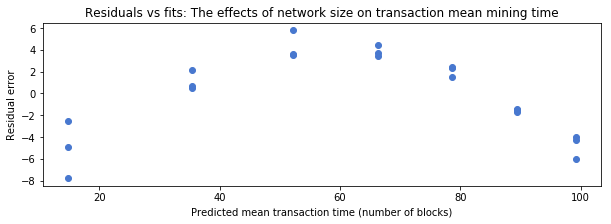

In [26]:
plt.figure(figsize=(10,3))

plt.scatter(num_sensors_model_df_large_networks['mining_predicted'], num_sensors_model_df_large_networks['mining_error'])
_ = plt.xlabel('Predicted mean transaction time (number of blocks)')
_ = plt.ylabel('Residual error')
_ = plt.title("Residuals vs fits: The effects of network size on transaction mean mining time")

# plt.savefig('./outputs/figures/num-sensors/mining-mean/residual-errors.svg')

In [27]:
num_sensors_model_df['mining_predicted'] = num_sensors_model_df.apply(lambda row: row['num_sensors'] * gradient + intercept, axis=1)
num_sensors_model_df['mining_error'] = num_sensors_model_df['mining_mean'] - num_sensors_model_df['mining_predicted']


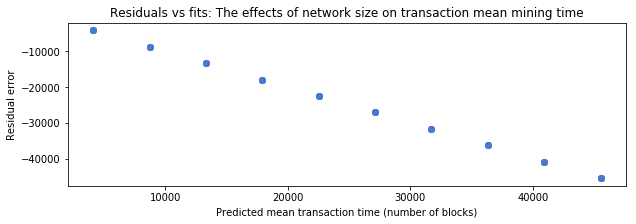

In [28]:
plt.figure(figsize=(10,3))

plt.scatter(num_sensors_model_df['mining_predicted'], num_sensors_model_df['mining_error'])
_ = plt.xlabel('Predicted mean transaction time (number of blocks)')
_ = plt.ylabel('Residual error')
_ = plt.title("Residuals vs fits: The effects of network size on transaction mean mining time")

plt.savefig('./outputs/figures/num-sensors/mining-mean/residual-errors.svg')

In [29]:
# Deprecated
# plt.figure(figsize=(10,7))
# plt.plot(num_sensors_model_df['num_sensors'], num_sensors_model_df['mining_mean'], "bo", label="Mean number of blocks")
# plt.plot(x_lobf, y_lobf, 'r--')
# # plt.plot(np.log(num_sensors_model_df['num_sensors']), num_sensors_model_df['mining_mean-1std'], 'b.', label="+1 σ")
# # plt.plot(np.log(num_sensors_model_df['num_sensors']), num_sensors_model_df['mining_mean+1std'], 'b.', label="-1 σ")
# plt.legend(bbox_to_anchor=(1.05, 1))
# _ = plt.xlabel('Network size (number of sensors)')
# _ = plt.ylabel('Number of blocks for \ntransaction to be mined')
# plt.title("Network size by sensor count against \ntransaction mean mining time")

### Interpretation

A positive linear relationship (Pearson correlation coefficient: 0.98801) is observed between the number of sensors connecting to a blockchain and the mean mining time, measured in the number of blocks elapsed between when a transaction is submitted and when it is validated. 

Due to the limited sample size (n=7), along with constraints in the range of number of sensors swept, however, I hesitate to conclude firmly that this relationship is necessarily linear, and not a power or logarithmic relationship; further investigation is necessary. Regardless, it seems clear that increasing numbers of nodes connecting and submitting transactions to a blockchain network lengthens transaction validation times if all other factors are held constant, as hypothesized. This reaffirms the questions raised regarding the scalability of public blockchain networks for large, high transaction volume networks such as the Internet of Things. 

## Effects on informational currency

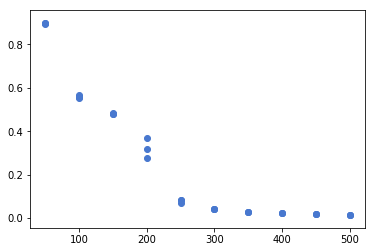

In [30]:
plt.scatter(num_sensors_model_df['num_sensors'], num_sensors_model_df['informational_currency_mean'])

In [33]:
small_network_info_currency_summary = pd.DataFrame(num_sensors_model_df[num_sensors_model_df['num_sensors'] == 50]['agent_vars_by_tick'][0]['informational_currency'].unstack()[30:].mean(axis=1)).rename(columns={0:'50_0'})
small_network_info_currency_summary['50_1'] = num_sensors_model_df[num_sensors_model_df['num_sensors'] == 50]['agent_vars_by_tick'][1]['informational_currency'].unstack()[30:].mean(axis=1)
small_network_info_currency_summary['50_2'] = num_sensors_model_df[num_sensors_model_df['num_sensors'] == 50]['agent_vars_by_tick'][2]['informational_currency'].unstack()[30:].mean(axis=1)

In [34]:
for col in small_network_info_currency_summary.columns:
    pprint(calculate_adf_results(small_network_info_currency_summary[col]))

{'1%_critical_value': -3.454988209954765,
 '10%_critical_value': -2.572549407997327,
 '5%_critical_value': -2.8723857312734613,
 'adf_statistic': -7.2909557803997025,
 'p_value': 1.4177044014575614e-10}
{'1%_critical_value': -3.4552699038400827,
 '10%_critical_value': -2.5726152830188678,
 '5%_critical_value': -2.8725092359464526,
 'adf_statistic': -5.3040631368429825,
 'p_value': 5.370529318256278e-06}
{'1%_critical_value': -3.4550813975770827,
 '10%_critical_value': -2.5725712007462582,
 '5%_critical_value': -2.8724265892710914,
 'adf_statistic': -6.319859111922599,
 'p_value': 3.085167904333193e-08}


In [35]:
calculate_adf_results(small_network_info_currency_summary['50_0'])

{'adf_statistic': -7.2909557803997025,
 'p_value': 1.4177044014575614e-10,
 '1%_critical_value': -3.454988209954765,
 '5%_critical_value': -2.8723857312734613,
 '10%_critical_value': -2.572549407997327}

Text(0.5, 1.0, 'Informational currency by block number across network sizes')

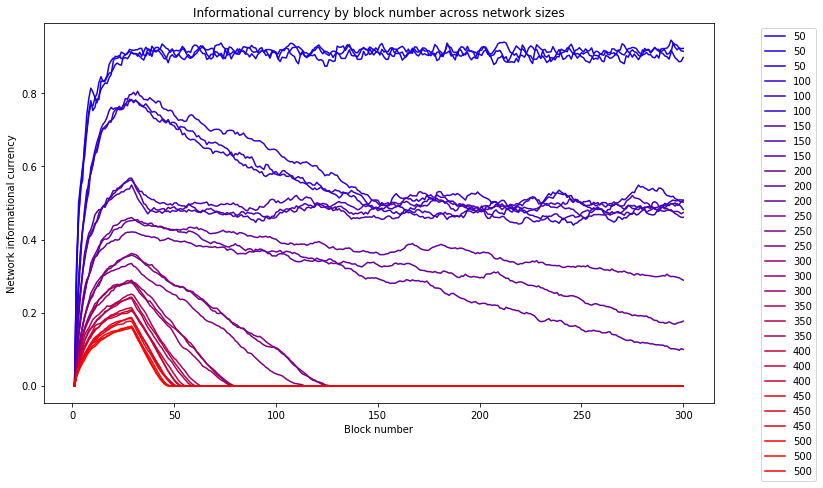

In [36]:
plt.figure(figsize=(12,7))
for i, run in num_sensors_model_df[['num_sensors', 'agent_vars_by_tick']].iterrows():

    line_color = str(color_interpolator(run['num_sensors'] / num_sensors_model_df['num_sensors'].max()))
    plt.plot(run[1]['informational_currency'].unstack().mean(axis=1), label = str(run['num_sensors']), color = line_color)
    
plt.legend(bbox_to_anchor=(1.16, 1))
plt.xlabel('Block number')
plt.ylabel('Network informational currency')
plt.title('Informational currency by block number across network sizes')

# plt.savefig('./outputs/figures/num-sensors/info-currency/time-series-across-network-sizes.svg')


### Interpretation

#### Warm-up period

The expected warm-up period was observed clearly: after approximately 25-30 ticks (blocks were mined), a consistent level of informational currency was maintained, within a range of variability, for networks with fewer than 100 sensors. 

*What explains the variability observed? Is that just stochasticity? Or because record_freq = 0.3, meaning sometimes edge nodes did not transmit, as they had not recorded any new data? Because transmit_freq = 1, they did attempt to transmit every tick.*


#### Large network behavior

The observed collapse of informational currency in the larger networks (x = {320, 640}) is likely due to the fixed window of 30 blocks used to calculate informational currency. Values of 0 indicate that no data collected by any sensor within the 30 most recent blocks had been reflected on the blockchain through the transaction submission and mining process. This is in line with the observed mean mining time of > 30 for both the 320- and 640-sensor networks.

This behavior means the 280+ sensor networks will be excluded from the statistical analyses intended to identify the relationship between these two dimensions in the dataset. 

### Temporal trends

Upon reaching a threshold network size - between 60 and 100 sensors - fail to achieve what seem to be complete informational currency, in which levels are establish near 1.0. As informational currency at each tick is the ratio of data represented on-chain to the data captured in the 30 prior ticks, lower levels of informational currency were predicted to be observed in larger networks. In these iterations, greater transaction volumes, given a fixed block size (in the model a function of the block gas limit [cite line in ipynb]), mean that an individual sensor's transaction is likely to take longer to be mined into a block, especially as the size of data packets collected were homogenous. Resultingly, the lower network informational currency measures observed are in line with the hypothesis.

However, the apparent non-stationarity of informational currency measures of these larger networks over time was not expected. As early transactions are broadcasted to the miners and added to the mempool, they are mined - within the first few blocks informational currency is very high because few ticks have passed, meaning little data has been collected at the edge, and transactions are being validated each tick. However, this increase in informational currency begins to slow as the network reaches a point where """???""" ...

There is no obvious reason for the informational currency of the network to initially experience a higher proportion of data captured being validated and written to the blockchain, but for that proportion to decrease as more transactions are submitted. This pattern, of overshooting, then decreasing over time, may be due to quirks in model design and calibration, or to some element of system functioning that is unsustainable once some threshold of usage is exceeded. (Footnote: Here we raise a critique of agent-based modeling as an investigatory approach: it is impossible to tell whether emergent complexity - precisely what the technique is meant to simulate - is a result of intended agent interactions or of just some model design decision without validating the model data collected from observed reality. It is therefore difficult to make any firm assertions about complex system behavior based on analysis of model results. ***Justify lack of calibration dataset despite its availability?***) If the negative trend of informational currency in larger networks is a genuine result, perhaps it can be explained by the fact that the number of unvalidated transaction is growing at a rate faster than it is being reduced, so over time a smaller percentage of the prior 30 block's submissions are validated. However, this still does not explain why it achieves are 
perhaps it is due to the growing disproportion between the number of transactions submitted

As an additional curiosity, one network size - 150 sensors - did not exhibit the negative correlation between time and informational currency, despite the model run simulating the next smaller network (100 sensors) and one simulating the next larger (210 sensors) both experiencing the decreasing informational currency values as time increased. 

Clearly much investigation is warranted to understand the effects of network loads on blockchain behavior over time. 

This negative relationship is difficult to interpret. 

The unexpected result is the non-stationarity observed in the plots of informational currency measures over time. The negative relationship - in some cases appearing linear, in others, perhaps asymptotic, 

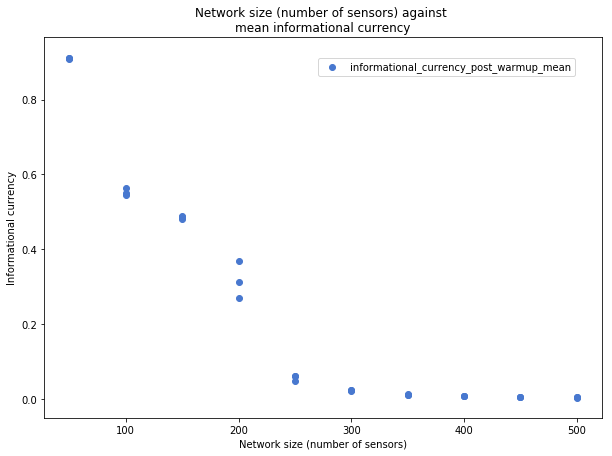

In [37]:
# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.scatter(num_sensors_model_df['num_sensors'], num_sensors_model_df['informational_currency_post_warmup_mean'])#, yerr=num_sensors_model_df['informational_currency_post_warmup_std'], fmt='o', label="Mean informational currency +/- 1σ ")
plt.legend(bbox_to_anchor=(0.96, 0.96))
# plt.text(20, 130, "y = " + str(round(gradient, 5)) + 'x + ' + str(round(intercept, 5)))
# plt.text(20,120,"p = " + str(round(pval, 5)))
# plt.text(20,110,r"$R^2$ = " + str(round(rsquared, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Network size (number of sensors)')
_ = plt.ylabel('Informational currency')
_ = plt.title("Network size (number of sensors) against \nmean informational currency")

#### Interpretation

A convex negative nonlinear relationship appears to exist between network size and the measure of informational currency employed here. While a negative relationship was hypothesized, the nonlinear nature was unexpected. Further modeling and statistical analysis is warranted to better understand the dynamics of how network size affects how well the state of the cloud ledger reflects the state at the edge. 

Why?

### Assessing stationarity: informational currency over time

In order to analyze temporal autocorrelation and seasonality in measures of informational currency over time (after the warm-up period), 

ACF plot
PACF plots
Augmented Dickey-Fuller test

/Users/iv/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


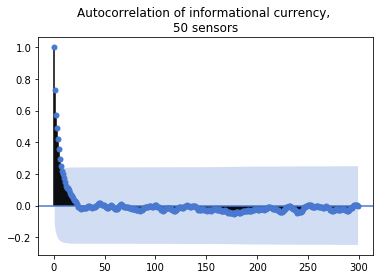

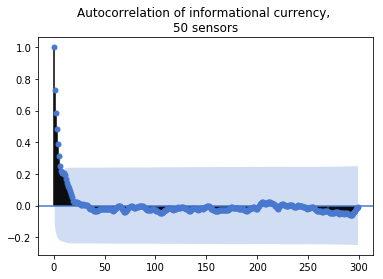

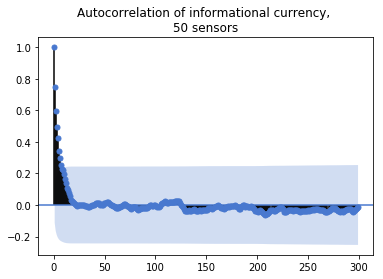

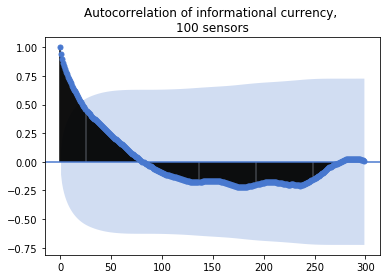

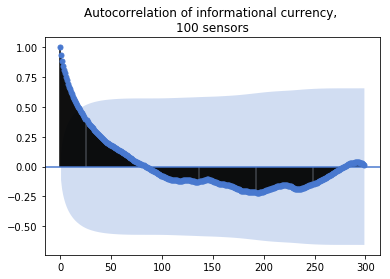

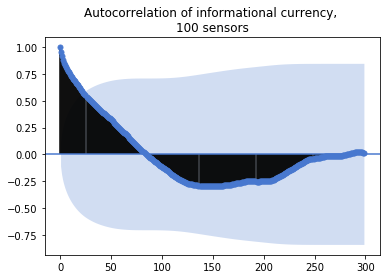

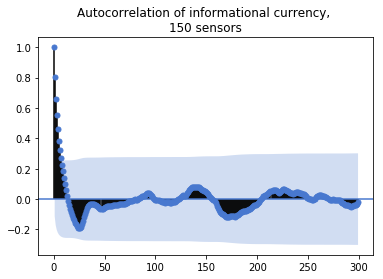

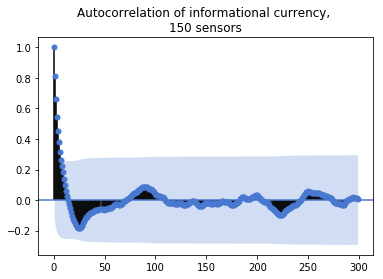

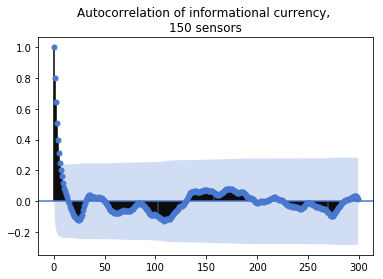

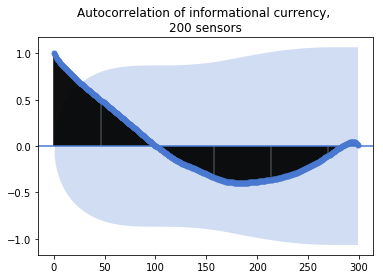

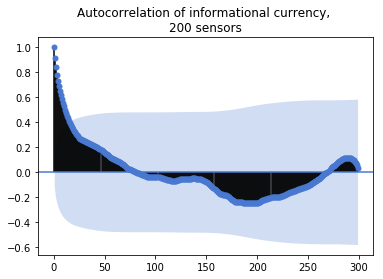

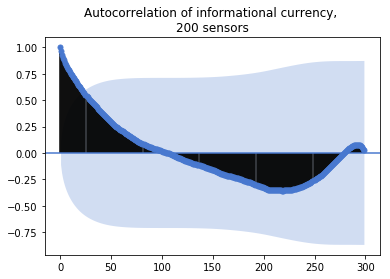

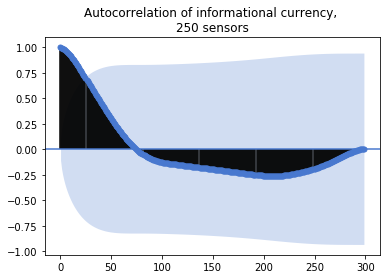

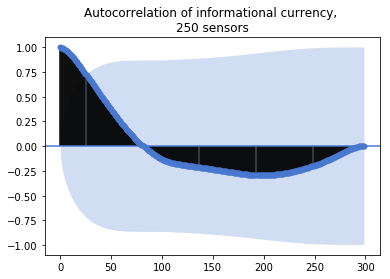

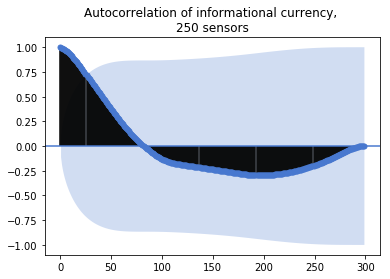

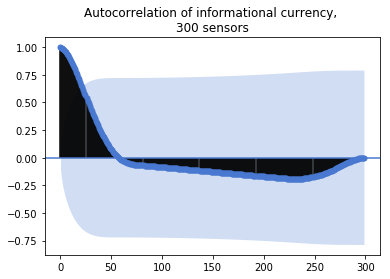

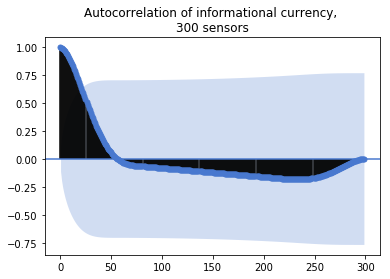

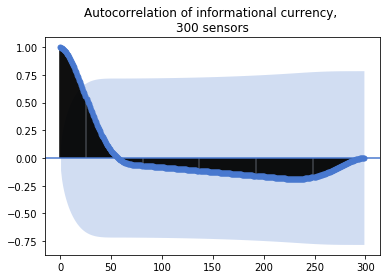

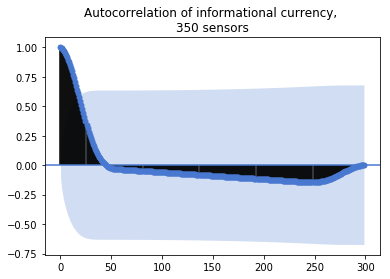

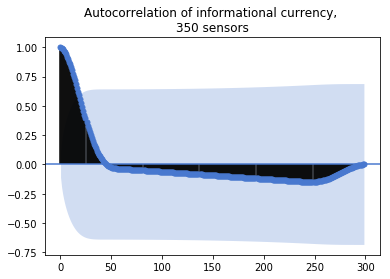

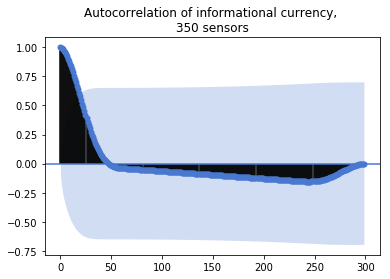

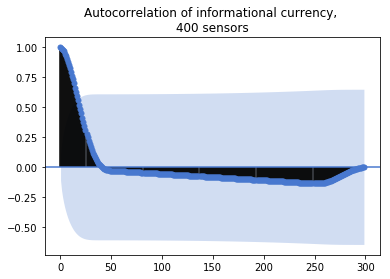

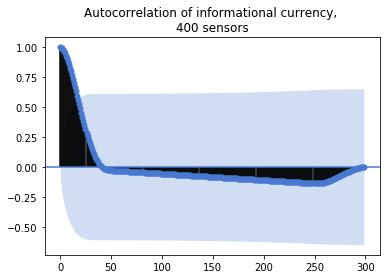

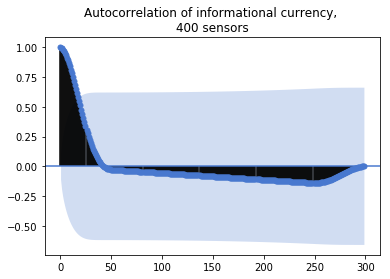

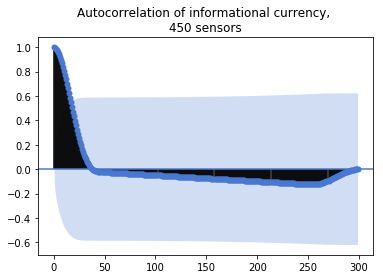

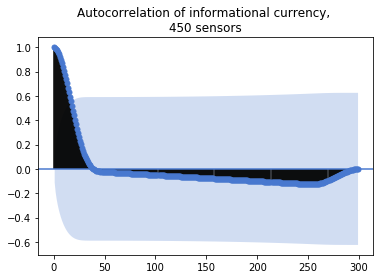

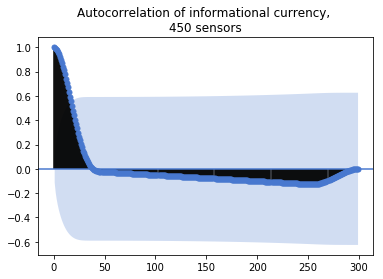

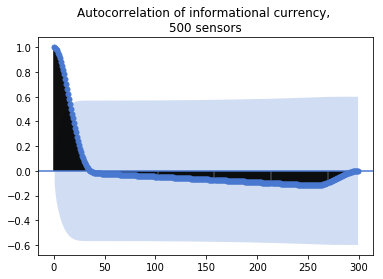

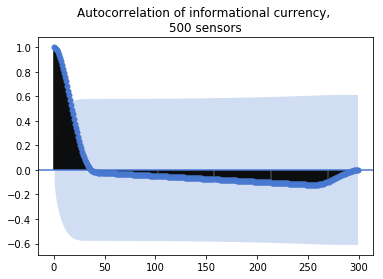

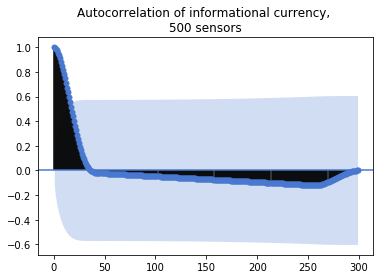

In [38]:
for i in range(len(num_sensors_model_df['agent_vars_by_tick'])):
    t = "Autocorrelation of informational currency, \n" + str(num_sensors_model_df.loc[i, 'num_sensors']) + " sensors"
    _ = plot_acf(num_sensors_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values, title=t)

/Users/iv/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


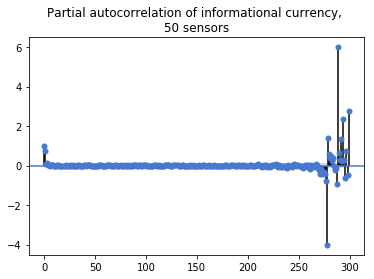

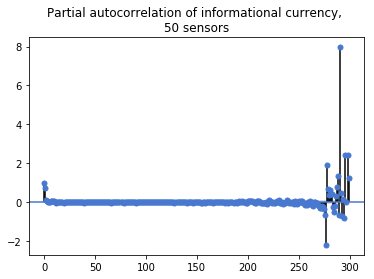

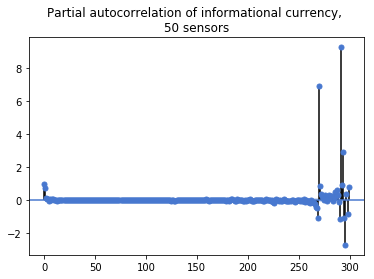

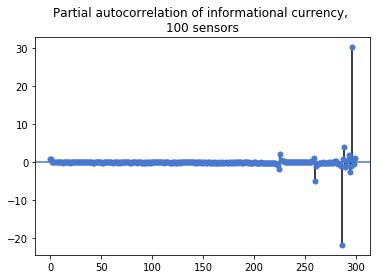

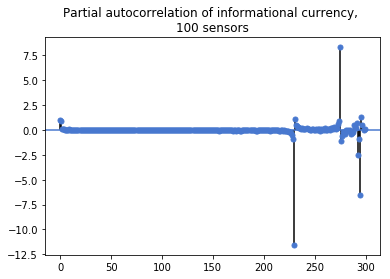

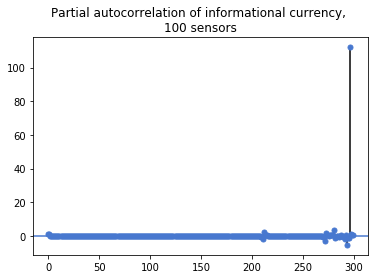

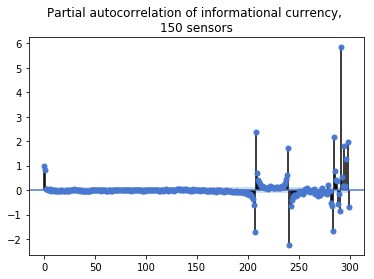

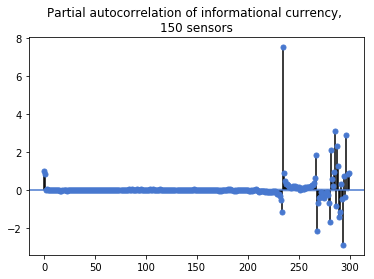

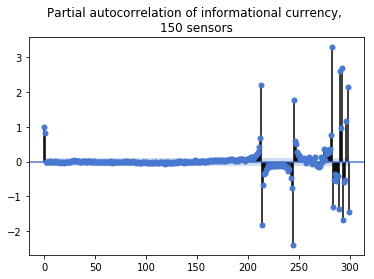

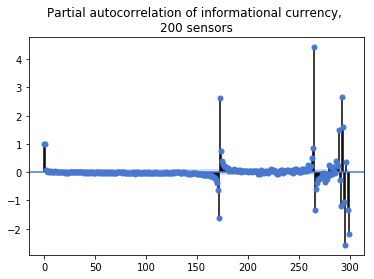

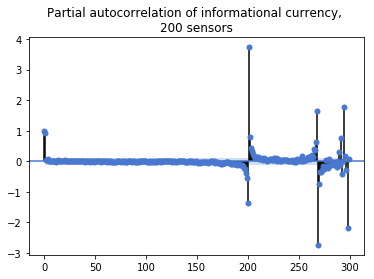

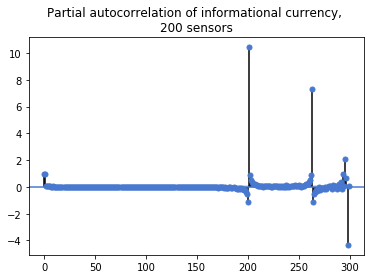

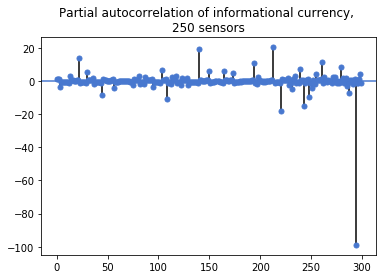

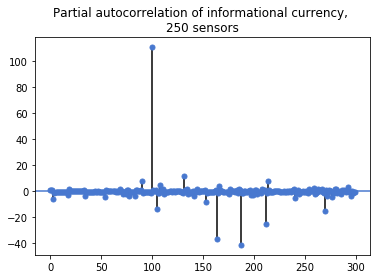

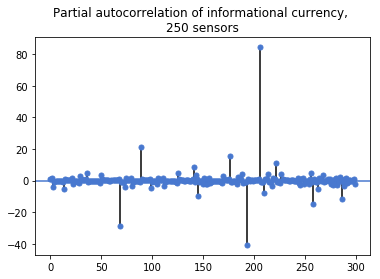

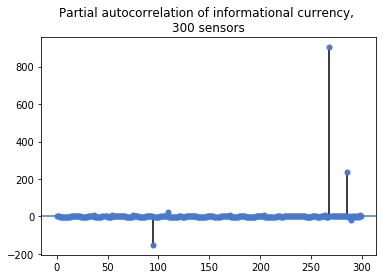

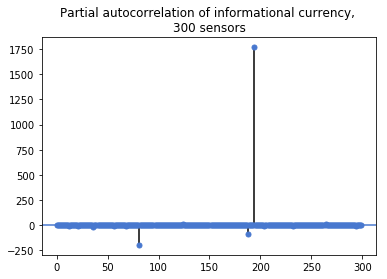

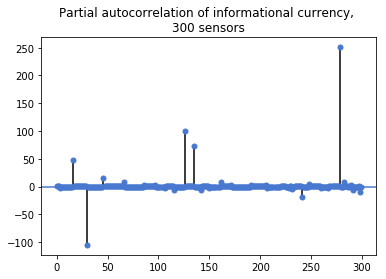

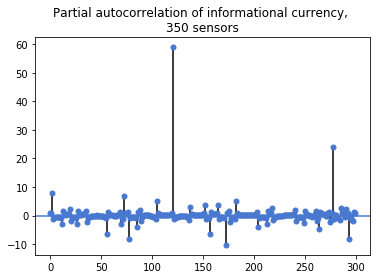

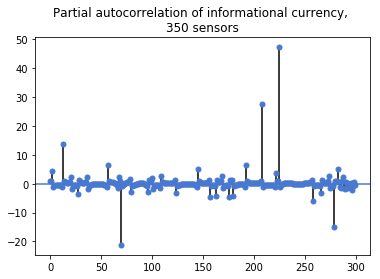

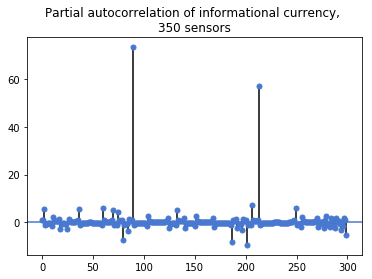

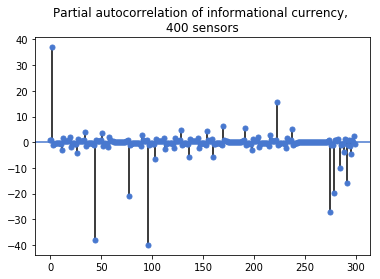

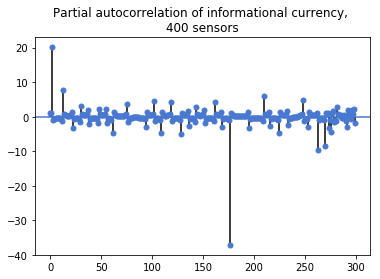

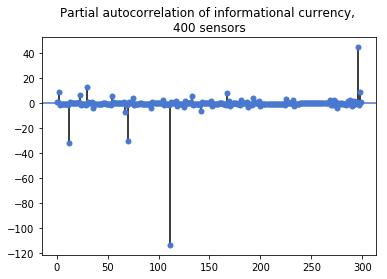

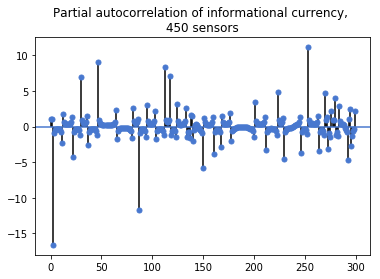

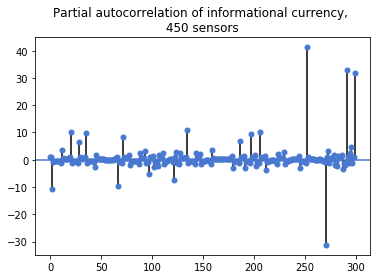

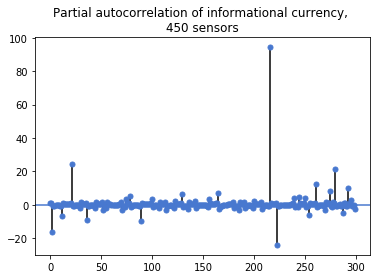

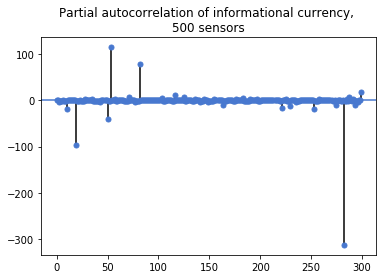

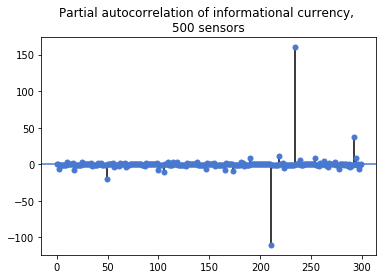

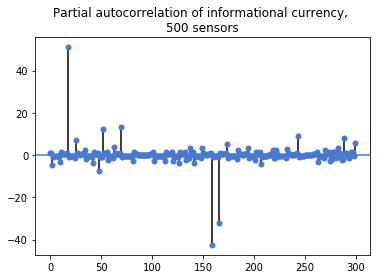

In [39]:
for i in range(len(num_sensors_model_df['agent_vars_by_tick'])):
    t = "Partial autocorrelation of informational currency, \n" + str(num_sensors_model_df.loc[i, 'num_sensors']) + " sensors"

    _ = plot_pacf(num_sensors_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values, title=t)

In [40]:
calculate_adf_results(num_sensors_model_df['agent_vars_by_tick'][1]['informational_currency'].unstack().mean(axis=1).values).keys()

dict_keys(['adf_statistic', 'p_value', '1%_critical_value', '5%_critical_value', '10%_critical_value'])

In [41]:
num_sensors_adf_df = pd.DataFrame(columns=['num_sensors', 'adf_statistic', 'p_value', '1%_critical_value', '5%_critical_value', '10%_critical_value'])

for i in range(len(num_sensors_model_df['agent_vars_by_tick'])):
    adf_results = calculate_adf_results(num_sensors_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values)
    adf_results['num_sensors'] = num_sensors_model_df.loc[i, 'num_sensors']

    num_sensors_adf_df = num_sensors_adf_df.append(pd.DataFrame([adf_results], columns=adf_results.keys()))

num_sensors_adf_df = num_sensors_adf_df.reset_index().drop(columns=['index'])
num_sensors_adf_df


/Users/iv/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


1%_critical_value  10%_critical_value  5%_critical_value  adf_statistic  \
0           -3.452486           -2.571964          -2.871288     -10.309914   
1           -3.452713           -2.572017          -2.871388      -8.751366   
2           -3.452561           -2.571982          -2.871321     -10.760920   
3           -3.453262           -2.572146          -2.871628      -2.919492   
4           -3.453670           -2.572241          -2.871808      -3.283759   
5           -3.453182           -2.572127          -2.871593      -1.903046   
6           -3.452790           -2.572035          -2.871422      -2.927843   
7           -3.453670           -2.572241          -2.871808      -4.225814   
8           -3.453262           -2.572146          -2.871628      -2.740017   
9           -3.452561           -2.571982          -2.871321       0.128987   
10          -3.452637           -2.571999          -2.871354      -0.460880   
11          -3.453262           -2.572146          -2.871628      -0.058868   
12          -3.453670           -2.572241          -2.871808      -5.032231   
13          -3.452945           -2.572071          -2.871490      -3.618117   
14          -3.453505           -2.572202          -2.871735      -4.290792   
15          -3.453670           -2.572241          -2.871808      -7.048855   
16          -3.453505           -2.572202          -2.871735      -6.820811   
17          -3.453670           -2.572241          -2.871808      -5.501850   
18          -3.453670           -2.572241          -2.871808      -4.733335   
19          -3.453670           -2.572241          -2.871808      -6.265777   
20          -3.453182           -2.572127          -2.871593      -4.563861   
21          -3.453670           -2.572241          -2.871808      -5.248010   
22          -3.453587           -2.572222          -2.871771      -3.450075   
23          -3.453587           -2.572222          -2.871771      -4.471100   
24          -3.453587           -2.572222          -2.871771      -5.034523   
25          -3.453587           -2.572222          -2.871771      -4.938997   
26          -3.452486           -2.571964          -2.871288      -3.802386   
27          -3.453587           -2.572222          -2.871771      -4.623682   
28          -3.453670           -2.572241          -2.871808      -4.169954   
29          -3.453587           -2.572222          -2.871771      -5.218092   

   num_sensors       p_value  
0           50  3.205455e-18  
1           50  2.830716e-14  
2           50  2.522177e-19  
3          100  4.312789e-02  
4          100  1.562026e-02  
5          100  3.306297e-01  
6          150  4.220470e-02  
7          150  5.956502e-04  
8          150  6.736592e-02  
9          200  9.679854e-01  
10         200  8.994271e-01  
11         200  9.533845e-01  
12         250  1.915418e-05  
13         250  5.423970e-03  
14         250  4.608080e-04  
15         300  5.594188e-10  
16         300  2.004200e-09  
17         300  2.062829e-06  
18         350  7.282077e-05  
19         350  4.117595e-08  
20         350  1.504999e-04  
21         400  7.010176e-06  
22         400  9.365748e-03  
23         400  2.216861e-04  
24         450  1.895416e-05  
25         450  2.926502e-05  
26         450  2.882996e-03  
27         500  1.167915e-04  
28         500  7.404601e-04  
29         500  8.074320e-06

In [42]:
# Adapted from CEGExxx: Spatial Temporal Data Analysis and Data Mining final project


# *** convert to dataframe ... 
for i in range(len(num_sensors_model_df['agent_vars_by_tick'])):

    adf_num_sensors = adfuller(num_sensors_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values)
    print("Augmented Dickey-Fuller test, " + str(num_sensors_model_df.loc[i, 'num_sensors']) + " sensors")
    print('ADF Statistic: %f' % adf_num_sensors[0])
    print('p-value: %f' % adf_num_sensors[1])
    print('Critical Values:')
    for key, value in adf_num_sensors[4].items():
        print('\t%s: %.3f' % (key, value))
    print()

Augmented Dickey-Fuller test, 50 sensors
ADF Statistic: -10.309914
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 50 sensors
ADF Statistic: -8.751366
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 50 sensors
ADF Statistic: -10.760920
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 100 sensors
ADF Statistic: -2.919492
p-value: 0.043128
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572

Augmented Dickey-Fuller test, 100 sensors
ADF Statistic: -3.283759
p-value: 0.015620
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572

Augmented Dickey-Fuller test, 100 sensors
ADF Statistic: -1.903046
p-value: 0.330630
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572

Augmented Dickey-Fuller test, 150 sensors
ADF Statistic: -2.927843
p-value: 0.042205
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Full

### Interpretation

The p-value of <0.05 on each of the Augmented Dickey-Fuller tests performed on the time series data representing informational currency serves as statistically significant evidence of what was visually observed in both the series plot and the autocorrelation function plot: the series do not have unit roots, and are stationary processes. This is important because it suggests that, with all other factors remaining constant, for a given transaction volume per block informational currency establishes a stable level. The variation was observed around that mean was based on stochasticity of transaction transmission: if a sensor did not transmit for an unusually long period, its informational currency level likely increased as transactions already submitted to the chain were validated, increasing the proportion reflected on chain of data recorded at the edge. The important observation is the stationarity of the metric: if blockchain transaction volume processing capacity adapts in response to submitted volumes, or submitted volumes are adjusted through incentivization adjustments (i.e. gas costs), sustainable operation of the blockchain appears possible, in this regard.

## Effects on gwei spent

Perhaps the primary constraint unique to public blockchains is the requirement that users pay for compute and storage space used. This is a necessary attribute of the system, designed to prevent intentional abuse or unintentional misuse, which seems to be inevitable in permissionless, anonymous systems. 



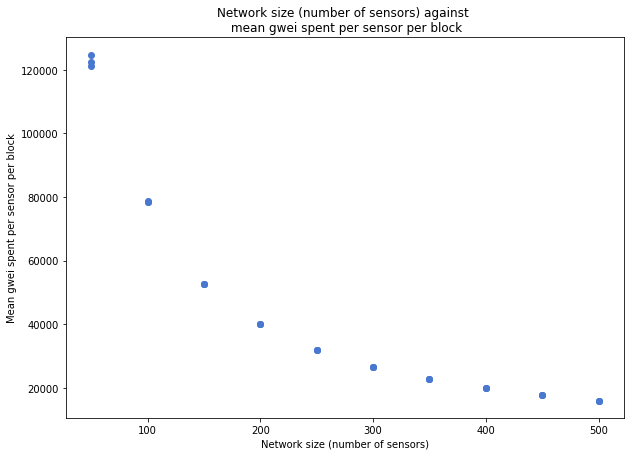

In [43]:
plt.figure(figsize=(10,7))

plt.scatter(num_sensors_model_df['num_sensors'], num_sensors_model_df['gwei_spent_mean'])

_ = plt.xlabel('Network size (number of sensors)')
_ = plt.ylabel('Mean gwei spent per sensor per block')
_ = plt.title("Network size (number of sensors) against \n mean gwei spent per sensor per block")

# plt.savefig('./outputs/figures/num-sensors/gwei-spent/ols-scatter-xtransformed.svg')

In [44]:
num_sensors_model_df[['num_sensors'] + [col for col in num_sensors_model_df.columns if 'gwei' in col] ].groupby('num_sensors').std()[[ 'gwei_spent_mean']]

gwei_spent_mean
num_sensors                 
50              1.775805e+03
100             3.320810e+01
150             1.781752e+01
200             0.000000e+00
250             0.000000e+00
300             0.000000e+00
350             0.000000e+00
400             2.572439e-12
450             0.000000e+00
500             1.818989e-12

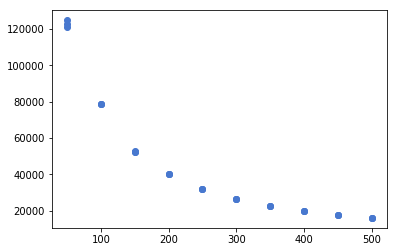

In [45]:
plt.scatter(num_sensors_model_df['num_sensors'], num_sensors_model_df['gwei_spent_mean'], label='Model run') #, yerr=num_sensors_model_df['gwei_spent_std'], fmt='o', label="Mean gwei spent per sensor +/- 1σ ")


In [46]:
num_sensors_model_df['gwei_spent_mean'].describe()

count        30.000000
mean      42868.118386
std       32887.144041
min       15946.666667
25%       19933.333333
50%       29235.555556
75%       52492.083333
max      124802.500000
Name: gwei_spent_mean, dtype: float64

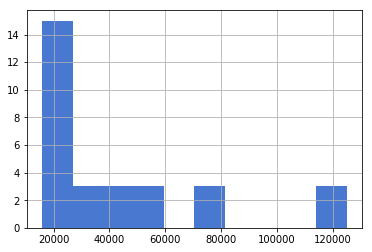

In [47]:
num_sensors_model_df['gwei_spent_mean'].hist()

In [48]:
X_values_gwei_untransformed = sms.add_constant(num_sensors_model_df['num_sensors'])
regression_model_gwei_spent_untransformed = sms.OLS(num_sensors_model_df['gwei_spent_mean'], X_values_gwei_untransformed).fit()
print(regression_model_gwei_spent_untransformed.summary())

                            OLS Regression Results                            
Dep. Variable:        gwei_spent_mean   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     83.70
Date:                Fri, 16 Aug 2019   Prob (F-statistic):           6.61e-10
Time:                        17:52:02   Log-Likelihood:                -333.33
No. Observations:                  30   AIC:                             670.7
Df Residuals:                      28   BIC:                             673.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.646e+04   6609.162     14.596      

In [51]:
num_sensors_model_df['num_sensors_logged'] = np.log(num_sensors_model_df['num_sensors'])
num_sensors_model_df['gwei_spent_mean_logged'] = np.log(num_sensors_model_df['gwei_spent_mean'])

In [52]:
pearson_gwei_xtransformed = num_sensors_model_df[['num_sensors_logged', 'gwei_spent_mean']].corr()

X_values_gwei_xtransformed = sms.add_constant(num_sensors_model_df['num_sensors_logged'])
regression_model_gwei_spent_xtransformed = sms.OLS(num_sensors_model_df['gwei_spent_mean'], X_values_gwei_xtransformed).fit()
print(regression_model_gwei_spent_xtransformed.summary())

                            OLS Regression Results                            
Dep. Variable:        gwei_spent_mean   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     591.0
Date:                Fri, 16 Aug 2019   Prob (F-statistic):           2.30e-20
Time:                        17:52:15   Log-Likelihood:                -307.65
No. Observations:                  30   AIC:                             619.3
Df Residuals:                      28   BIC:                             622.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.892e+05   1.02

In [53]:
gradient_gwei = regression_model_gwei_spent_xtransformed.params[1]
intercept_gwei = regression_model_gwei_spent_xtransformed.params[0]
rsquared_gwei = regression_model_gwei_spent_xtransformed.rsquared
pval_gwei = regression_model_gwei_spent_xtransformed.f_pvalue

In [54]:
x_lobf_gwei_xtransformed = [num_sensors_model_df['num_sensors_logged'].min(), num_sensors_model_df['num_sensors_logged'].max()]
y_lobf_gwei_xtransformed = [x_lobf_gwei_xtransformed[0] * gradient_gwei + intercept_gwei, x_lobf_gwei_xtransformed[1] * gradient_gwei + intercept_gwei]

In [55]:
y_lobf_gwei_xtransformed

[111492.23380734414, 6878.522798022081]

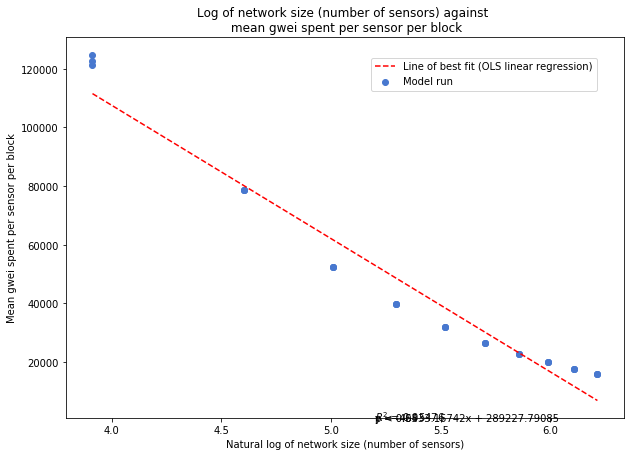

In [56]:

# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.scatter(num_sensors_model_df['num_sensors_logged'], num_sensors_model_df['gwei_spent_mean'], label='Model run') #, yerr=num_sensors_model_df['gwei_spent_std'], fmt='o', label="Mean gwei spent per sensor +/- 1σ ")

# plt.errorbar(num_sensors_model_df['num_sensors'], num_sensors_model_df['gwei_spent_mean'], yerr=num_sensors_model_df['gwei_spent_std'], fmt='o', label="Mean gwei spent per sensor +/- 1σ ")
plt.plot(x_lobf_gwei_xtransformed, y_lobf_gwei_xtransformed, 'r--', label="Line of best fit (OLS linear regression)" )
plt.legend(bbox_to_anchor=(0.96, 0.96))
plt.text(5.2, 11.5, "y = " + str(round(gradient_gwei, 5)) + 'x + ' + str(round(intercept_gwei, 5)))
plt.text(5.2,11.4, "p < 0.05")
plt.text(5.2,11.3, r"$R^2$ = " + str(round(rsquared_gwei, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Natural log of network size (number of sensors)')
_ = plt.ylabel('Mean gwei spent per sensor per block')
_ = plt.title("Log of network size (number of sensors) against \n mean gwei spent per sensor per block")

# plt.savefig('./outputs/figures/num-sensors/gwei-spent/ols-scatter-xtransformed.svg')

In [57]:
num_sensors_model_df

num_sensors  Run                                 agent_vars_by_tick  \
0            50    0                gwei_spent  battery_life  data_c...   
1            50    1                gwei_spent  battery_life  data_c...   
2            50    2                gwei_spent  battery_life  data_c...   
3           100    3                gwei_spent  battery_life  data_c...   
4           100    4                gwei_spent  battery_life  data_c...   
5           100    5                gwei_spent  battery_life  data_c...   
6           150    6                gwei_spent  battery_life  data_c...   
7           150    7                gwei_spent  battery_life  data_c...   
8           150    8                gwei_spent  battery_life  data_c...   
9           200    9                gwei_spent  battery_life  data_c...   
10          200   10                gwei_spent  battery_life  data_c...   
11          200   11                gwei_spent  battery_life  data_c...   
12          250   12                gwei_spent  battery_life  data_c...   
13          250   13                gwei_spent  battery_life  data_c...   
14          250   14                gwei_spent  battery_life  data_c...   
15          300   15                gwei_spent  battery_life  data_c...   
16          300   16                gwei_spent  battery_life  data_c...   
17          300   17                gwei_spent  battery_life  data_c...   
18          350   18                gwei_spent  battery_life  data_c...   
19          350   19                gwei_spent  battery_life  data_c...   
20          350   20                gwei_spent  battery_life  data_c...   
21          400   21                gwei_spent  battery_life  data_c...   
22          400   22                gwei_spent  battery_life  data_c...   
23          400   23                gwei_spent  battery_life  data_c...   
24          450   24                gwei_spent  battery_life  data_c...   
25          450   25                gwei_spent  battery_life  data_c...   
26          450   26                gwei_spent  battery_life  data_c...   
27          500   27                gwei_spent  battery_life  data_c...   
28          500   28                gwei_spent  battery_life  data_c...   
29          500   29                gwei_spent  battery_life  data_c...   

                                       mining_summary  \
0   count           7493.000000
mean              ...   
1   count           7700.000000
mean              ...   
2   count           7665.000000
mean              ...   
3   count           11457.000000
mean             ...   
4   count           11472.000000
mean             ...   
5   count           11460.000000
mean             ...   
6   count           11673.000000
mean             ...   
7   count           11663.000000
mean             ...   
8   count           11676.000000
mean             ...   
9   count           11960.000000
mean             ...   
10  count           11960.000000
mean             ...   
11  count           11960.000000
mean             ...   
12  count           11960.000000
mean             ...   
13  count           11960.000000
mean             ...   
14  count           11960.000000
mean             ...   
15  count           11960.000000
mean             ...   
16  count           11960.000000
mean             ...   
17  count           11960.000000
mean             ...   
18  count           11960.000000
mean             ...   
19  count           11960.000000
mean             ...   
20  count           11960.000000
mean             ...   
21  count           11960.000000
mean             ...   
22  count           11960.000000
mean             ...   
23  count           11960.000000
mean             ...   
24  count           11960.000000
mean             ...   
25  count           11960.000000
mean             ...   
26  count           11960.000000
mean             ...   
27  count           11960.000000
mean             ...   
28  count           11960

In [58]:
num_sensors_model_df['gwei_spent_predicted'] = num_sensors_model_df.apply(lambda row: row['num_sensors_logged'] * gradient_gwei + intercept_gwei, axis=1)
num_sensors_model_df['gwei_spent_error'] = num_sensors_model_df['gwei_spent_mean'] - num_sensors_model_df['gwei_spent_predicted']

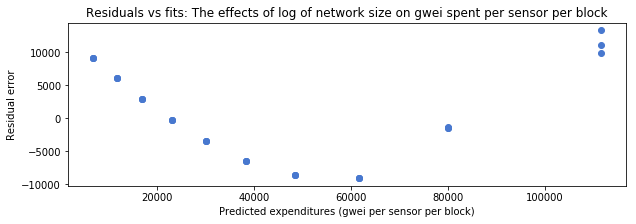

In [59]:
plt.figure(figsize=(10,3))

plt.scatter(num_sensors_model_df['gwei_spent_predicted'], num_sensors_model_df['gwei_spent_error'])
_ = plt.xlabel('Predicted expenditures (gwei per sensor per block)')
_ = plt.ylabel('Residual error')
_ = plt.title("Residuals vs fits: The effects of log of network size on gwei spent per sensor per block")

# plt.savefig('./outputs/figures/num-sensors/gwei-spent/residual-errors.svg')

#### Interpretation 

An negative relationship is observed: as network size increases, average gwei spent per sensor per block decreases. This was expected given that each block has a fixed gas limit, here placing a limit on the amount of data that can be written to the blockchain each block validation - as the number of sensors attempting to submit data to be stored on chain increases, the likelihood of each sensor's transactions being validated, and contained data being written, decreases. Costs in gwei incurred are only deducted from the sensor's externally owned account upon transaction validation - the decrease in gwei spent relates closely to the decrease in informational currency observed. (Common cause)

While the p-value calculated for the line of best fit using OLS regression is below the 0.05 threshold set to accept significance, the non-normal distribution of residual errors suggests that a non-linear model may fit the data better. Further research into the nature of the relationship between network size (in effect, transaction volumes) and cost to each network participant is warranted. This is a point where deploying heterogeneous agents submitting transactions at differing frequencies and writing data of varying volumes could provide even further insight into network scalability. 

In [60]:
num_sensors_model_df[['num_sensors', 'gwei_spent_mean']]

num_sensors  gwei_spent_mean
0            50    121290.833333
1            50    124802.500000
2            50    122586.666667
3           100     78551.250000
4           100     78607.916667
5           100     78549.583333
6           150     52521.388889
7           150     52488.333333
8           150     52493.333333
9           200     39866.666667
10          200     39866.666667
11          200     39866.666667
12          250     31893.333333
13          250     31893.333333
14          250     31893.333333
15          300     26577.777778
16          300     26577.777778
17          300     26577.777778
18          350     22780.952381
19          350     22780.952381
20          350     22780.952381
21          400     19933.333333
22          400     19933.333333
23          400     19933.333333
24          450     17718.518519
25          450     17718.518519
26          450     17718.518519
27          500     15946.666667
28          500     15946.666667
29          500     15946.666667

## The effects of record volumes on dependent variables

In [62]:
record_bytes_model_df = get_model_vars_df_from_pickle('./data/final/batch_run_1_record_bytes.pkl')

### Effects on mining dynamics

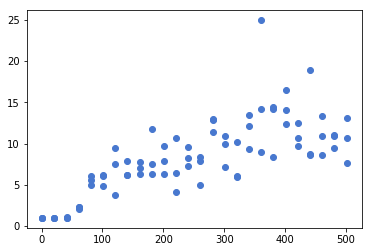

In [63]:
plt.scatter(record_bytes_model_df['record_bytes'], record_bytes_model_df['mining_mean'])

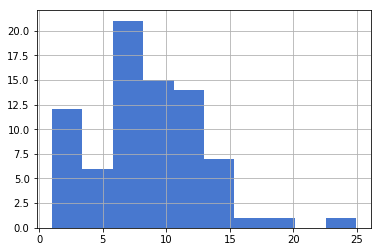

In [64]:
record_bytes_model_df[ 'mining_mean'].hist()

In [65]:
record_bytes_model_summary = record_bytes_model_df[['record_bytes', 'mining_mean']].describe()

In [66]:
record_bytes_model_summary['mining_mean']

count    78.000000
mean      8.253150
std       4.513987
min       1.000968
25%       6.025914
50%       8.044314
75%      10.892977
max      24.926421
Name: mining_mean, dtype: float64

In [67]:
record_bytes_tukey_fence = record_bytes_model_summary.loc['mean', 'mining_mean'] + (1.5 * record_bytes_model_summary.loc['75%', 'mining_mean'] - record_bytes_model_summary.loc['25%', 'mining_mean'])

In [68]:
record_bytes_model_df_mining = record_bytes_model_df[record_bytes_model_df['mining_mean'] < record_bytes_tukey_fence]

In [69]:
record_bytes_model_df_mining[['record_bytes', 'mining_mean']].corr()

record_bytes  mining_mean
record_bytes      1.000000     0.784483
mining_mean       0.784483     1.000000

In [70]:
pearson_record_bytes = record_bytes_model_df_mining[['record_bytes', 'mining_mean']].corr()

In [71]:
record_bytes_model_df_mining[['record_bytes', 'mining_mean']].describe()

record_bytes  mining_mean
count     76.000000    76.000000
mean     247.052632     7.892755
std      150.802997     3.943332
min        1.000000     1.000968
25%      121.000000     5.977837
50%      241.000000     7.825251
75%      381.000000    10.712375
max      501.000000    16.535117

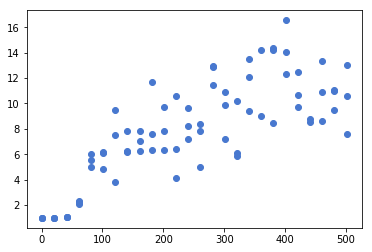

In [72]:
plt.scatter(record_bytes_model_df_mining['record_bytes'], record_bytes_model_df_mining['mining_mean'])

In [73]:
X_values_record_bytes = sms.add_constant(record_bytes_model_df_mining['record_bytes'])
regression_model_record_bytes = sms.OLS(record_bytes_model_df_mining['mining_mean'], X_values_record_bytes).fit()
print(regression_model_record_bytes.summary())

                            OLS Regression Results                            
Dep. Variable:            mining_mean   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     118.4
Date:                Fri, 16 Aug 2019   Prob (F-statistic):           5.16e-17
Time:                        17:53:29   Log-Likelihood:                -175.30
No. Observations:                  76   AIC:                             354.6
Df Residuals:                      74   BIC:                             359.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.8249      0.545      5.187   

In [74]:
gradient_record_bytes = regression_model_record_bytes.params[1]
intercept_record_bytes = regression_model_record_bytes.params[0]
rsquared_record_bytes = regression_model_record_bytes.rsquared
pval_record_bytes = regression_model_record_bytes.f_pvalue

In [75]:

x_lobf_record_bytes = [record_bytes_model_df_mining['record_bytes'].min(), record_bytes_model_df_mining['record_bytes'].max()]
y_lobf_record_bytes = [x_lobf_record_bytes[0]*gradient_record_bytes + intercept_record_bytes, x_lobf_record_bytes[1]*gradient_record_bytes + intercept_record_bytes]


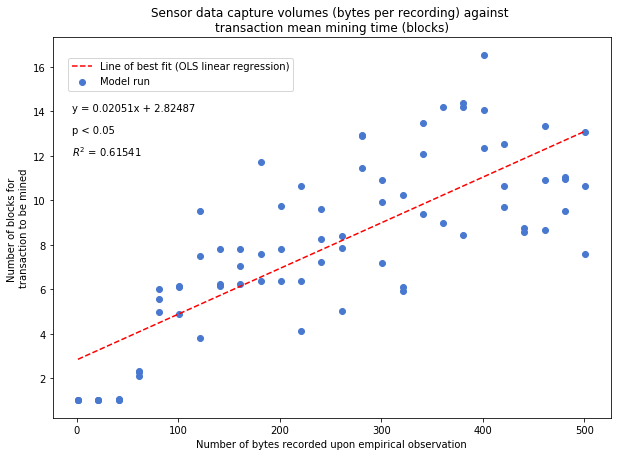

In [76]:

# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
# plt.errorbar(record_bytes_model_df['record_bytes'], record_bytes_model_df['mining_mean'], yerr=record_bytes_model_df['mining_std'], fmt='o', label="Mean mining time in blocks +/- 1σ ")
plt.scatter(record_bytes_model_df_mining['record_bytes'], record_bytes_model_df_mining['mining_mean'], label='Model run')
plt.plot(x_lobf_record_bytes, y_lobf_record_bytes, 'r--', label="Line of best fit (OLS linear regression)" )
plt.legend(bbox_to_anchor=(0.44, 0.96))
plt.text(-5, 14, "y = " + str(round(gradient_record_bytes, 5)) + 'x + ' + str(round(intercept_record_bytes, 5)))
plt.text(-5,13, "p < 0.05")
plt.text(-5, 12, r"$R^2$ = " + str(round(rsquared_record_bytes, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Number of bytes recorded upon empirical observation')
_ = plt.ylabel('Number of blocks for \ntransaction to be mined')
_ = plt.title("Sensor data capture volumes (bytes per recording) against \ntransaction mean mining time (blocks)")

# plt.savefig('./outputs/figures/record-vol/mining-mean/scatter-ols.svg')

In [77]:
record_bytes_model_df_mining['mining_predicted'] = record_bytes_model_df_mining.apply(lambda row: row['record_bytes'] * gradient_record_bytes + intercept_record_bytes, axis=1)
record_bytes_model_df_mining['mining_error'] = record_bytes_model_df_mining['mining_mean'] - record_bytes_model_df_mining['mining_predicted']

/Users/iv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/iv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 1.0, 'Mean mining time residual errors versus \nvalues predicted from OLS simple linear regression')

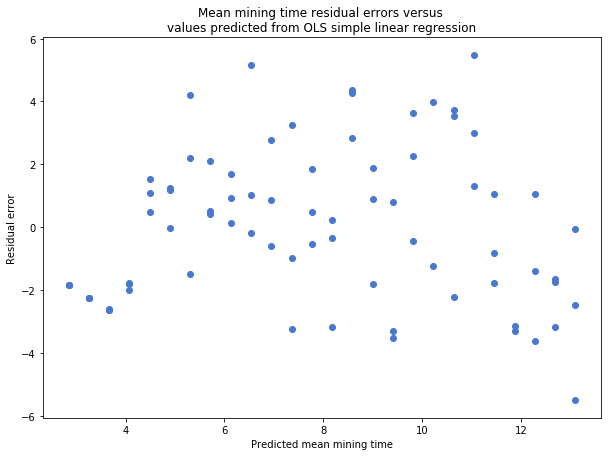

In [78]:
plt.figure(figsize=(10,7))
plt.scatter( record_bytes_model_df_mining['mining_predicted'], record_bytes_model_df_mining['mining_error'])
plt.xlabel('Predicted mean mining time')
plt.ylabel('Residual error')
plt.title('Mean mining time residual errors versus \nvalues predicted from OLS simple linear regression')

# plt.savefig('./outputs/figures/record-vol/mining-mean/residuals-fits.svg')

Text(0, 0.5, 'Number of model runs')

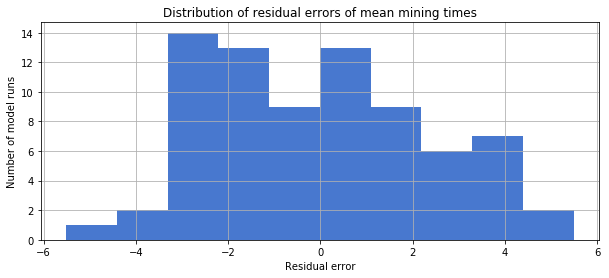

In [79]:
plt.figure(figsize=(10,4))
record_bytes_model_df_mining['mining_error'].hist()
plt.title('Distribution of residual errors of mean mining times')
plt.xlabel('Residual error')
plt.ylabel('Number of model runs')

# plt.savefig('./outputs/figures/record-vol/mining-mean/residuals-histogram.svg')

In [80]:
record_bytes_model_df_mining[['mining_error','mining_predicted']].corr()

mining_error  mining_predicted
mining_error      1.000000e+00      4.445804e-16
mining_predicted  4.445804e-16      1.000000e+00

### Effects of data capture volumes on network informational currency

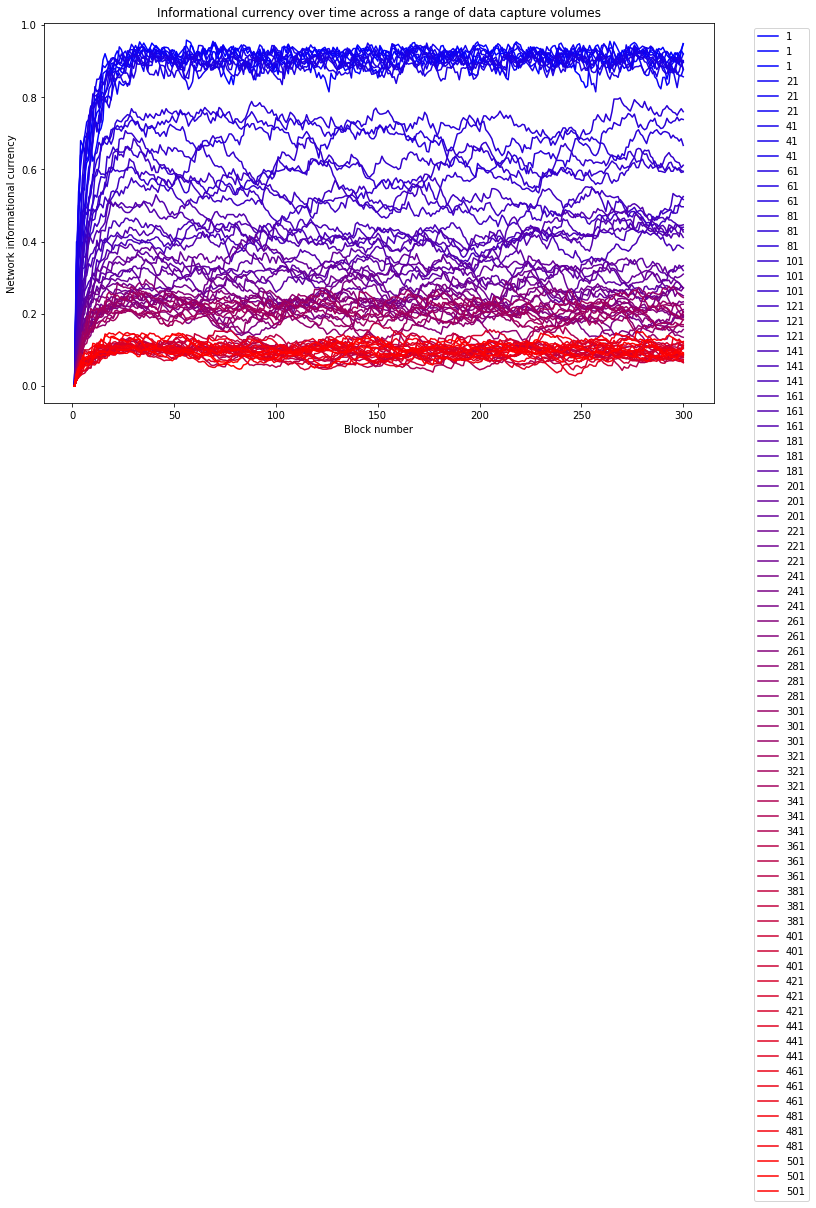

In [81]:
plt.figure(figsize=(12,7))
for i, run in record_bytes_model_df[['agent_vars_by_tick']].iterrows():
    plt.plot(run[0]['informational_currency'].unstack().mean(axis=1),\
             label=record_bytes_model_df.loc[i, 'record_bytes'], color=str(color_interpolator(record_bytes_model_df.loc[i, 'record_bytes'] / record_bytes_model_df['record_bytes'].max()))) #, cmap='gray', c=record_bytes_model_df['record_bytes'] )

plt.legend(bbox_to_anchor=(1.15, 1))
plt.title('Informational currency over time across a range of data capture volumes')
plt.xlabel('Block number')
_ = plt.ylabel("Network informational currency")

# plt.savefig('./outputs/figures/record-vol/info-currency/time-series-across-record-volumes.svg')

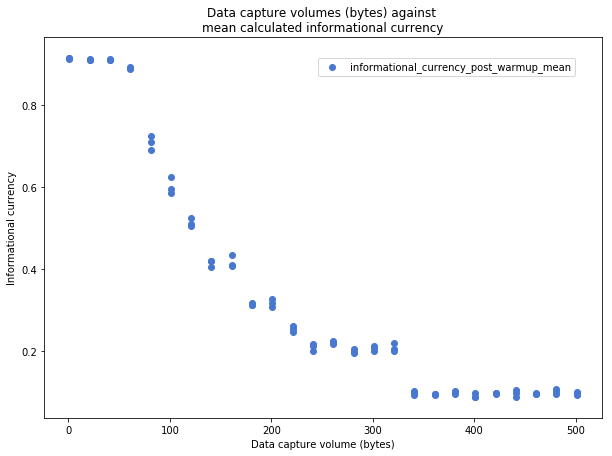

In [82]:
# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.scatter(record_bytes_model_df['record_bytes'], record_bytes_model_df['informational_currency_post_warmup_mean'])#, yerr=record_bytes_model_df['informational_currency_post_warmup_std'], fmt='o', label="Mean informational currency +/- 1σ ")

# plt.errorbar(record_bytes_model_df['record_bytes'], record_bytes_model_df['informational_currency_post_warmup_mean'], yerr=record_bytes_model_df['informational_currency_post_warmup_std'], fmt='o', label="Mean informational currency +/- 1σ ")
plt.legend(bbox_to_anchor=(0.96, 0.96))
# plt.text(20, 130, "y = " + str(round(gradient, 5)) + 'x + ' + str(round(intercept, 5)))
# plt.text(20,120,"p = " + str(round(pval, 5)))
# plt.text(20,110,r"$R^2$ = " + str(round(rsquared, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Data capture volume (bytes)')
_ = plt.ylabel('Informational currency')
_ = plt.title("Data capture volumes (bytes) against \nmean calculated informational currency")

# plt.savefig('./outputs/figures/record-vol/info-currency/scatter.svg')

In [83]:
record_bytes_model_df[record_bytes_model_df['record_bytes'] > 300][['record_bytes'] + [col for col in record_bytes_model_df if 'info' in col and 'mean'  in col]]

record_bytes  informational_currency_mean  \
45           301                     0.210524   
46           301                     0.199661   
47           301                     0.205295   
48           321                     0.203792   
49           321                     0.197380   
50           321                     0.213856   
51           341                     0.093156   
52           341                     0.097147   
53           341                     0.099833   
54           361                     0.091728   
55           361                     0.094684   
56           361                     0.093605   
57           381                     0.100606   
58           381                     0.095731   
59           381                     0.097722   
60           401                     0.088373   
61           401                     0.098183   
62           401                     0.087864   
63           421                     0.095432   
64           421                     0.097373   
65           421                     0.098134   
66           441                     0.103967   
67           441                     0.087978   
68           441                     0.099084   
69           461                     0.095485   
70           461                     0.093426   
71           461                     0.095249   
72           481                     0.096962   
73           481                     0.107688   
74           481                     0.101210   
75           501                     0.099073   
76           501                     0.095215   
77           501                     0.094032   

    informational_currency_post_warmup_mean  
45                                 0.212531  
46                                 0.201148  
47                                 0.208370  
48                                 0.204426  
49                                 0.200420  
50                                 0.219840  
51                                 0.093562  
52                                 0.097883  
53                                 0.102432  
54                                 0.093346  
55                                 0.095426  
56                                 0.095043  
57                                 0.102352  
58                                 0.096235  
59                                 0.099821  
60                                 0.089815  
61                                 0.098988  
62                                 0.089160  
63                                 0.095901  
64                                 0.098105  
65                                 0.098228  
66                                 0.106846  
67                                 0.087988  
68                                 0.099265  
69                                 0.097889  
70                                 0.094747  
71                                 0.095920  
72                                 0.096198  
73                                 0.107099  
74                                 0.102988  
75                                 0.100889  
76                                 0.094185  
77                                 0.095660

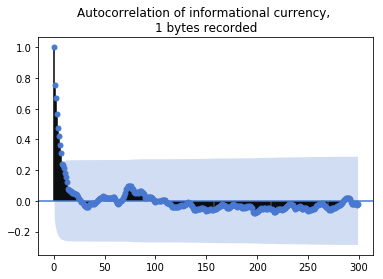

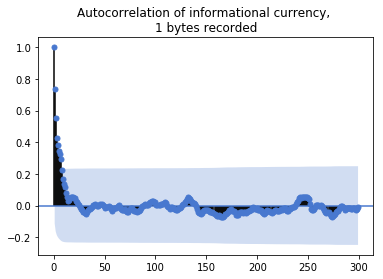

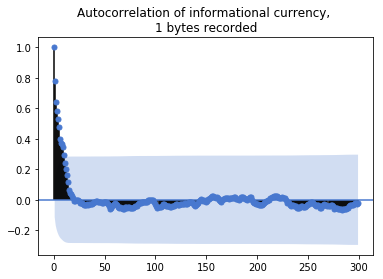

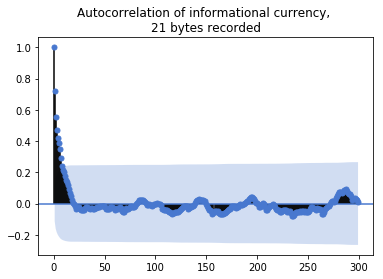

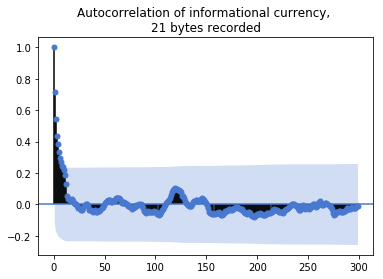

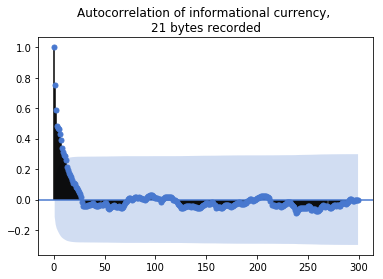

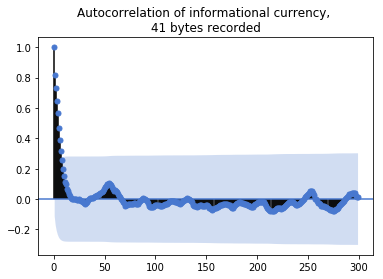

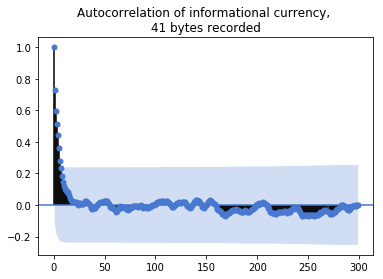

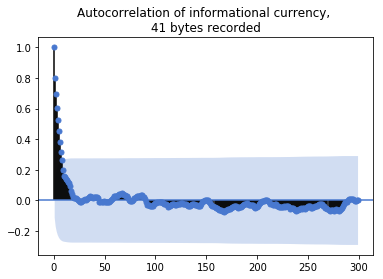

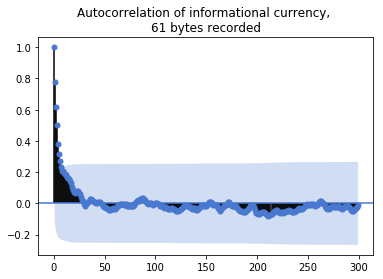

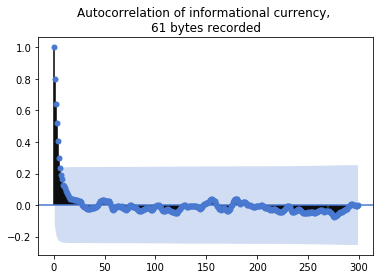

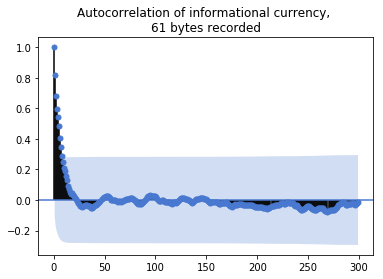

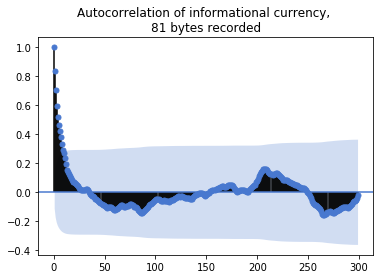

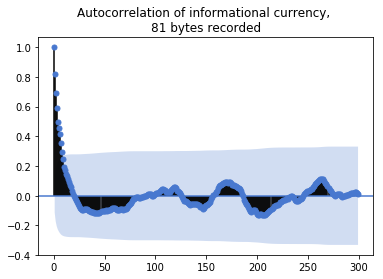

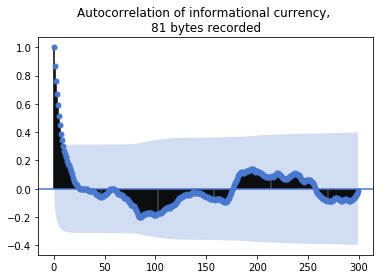

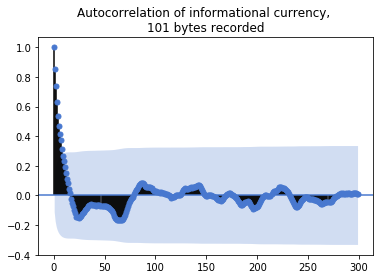

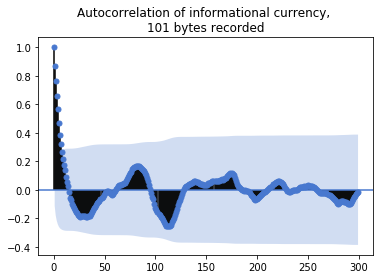

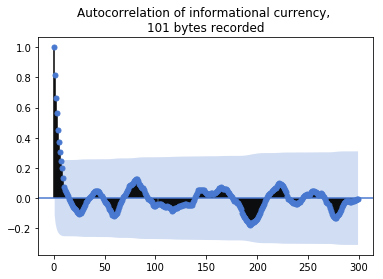

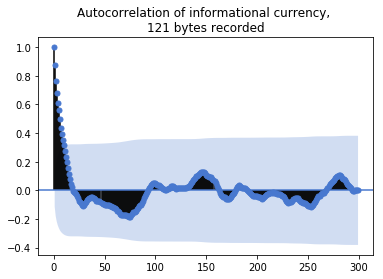

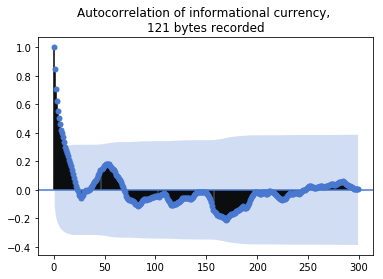

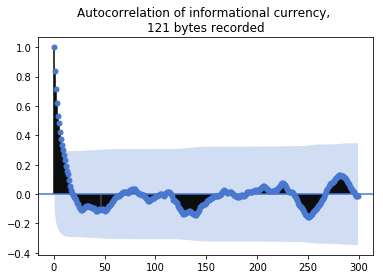

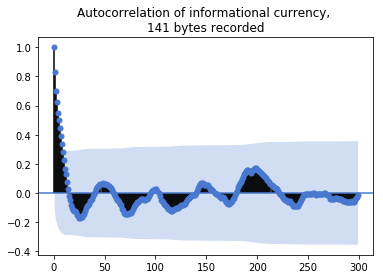

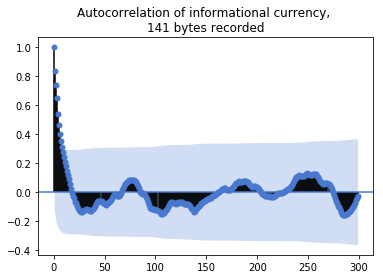

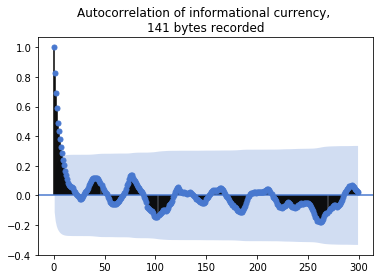

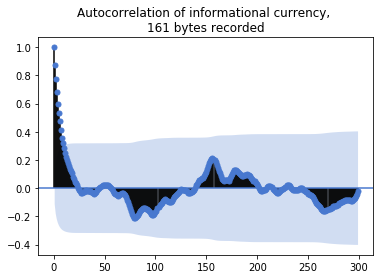

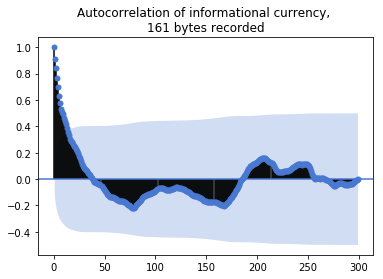

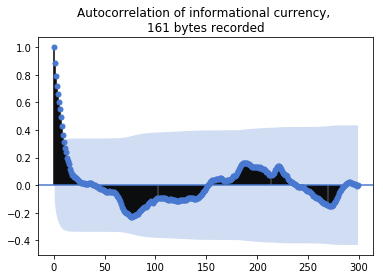

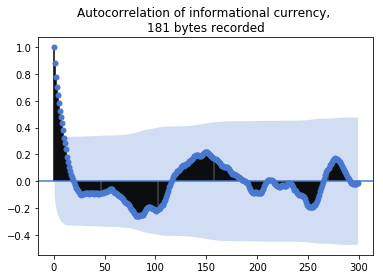

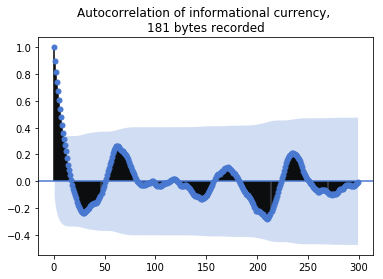

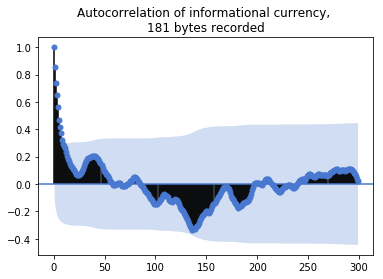

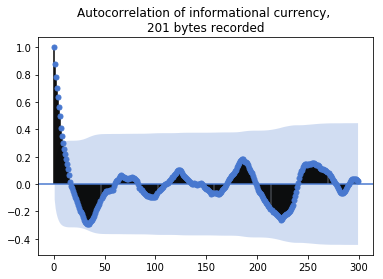

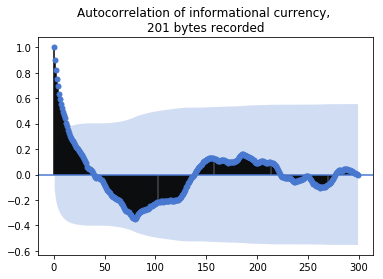

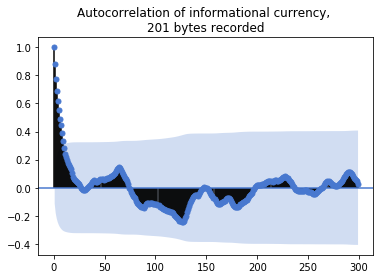

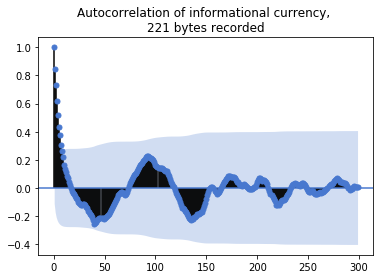

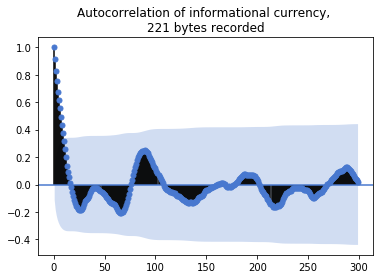

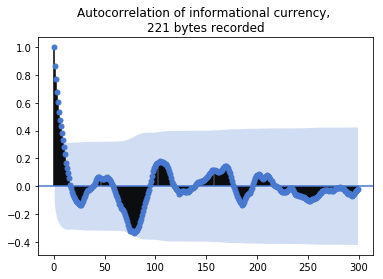

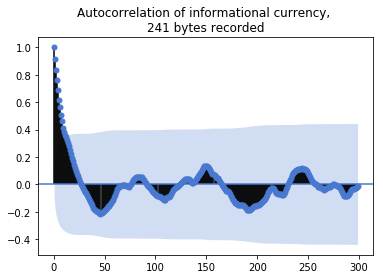

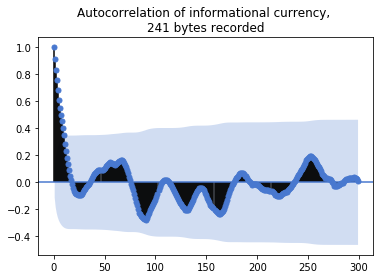

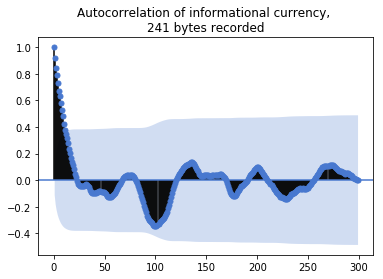

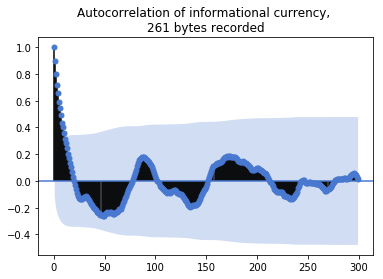

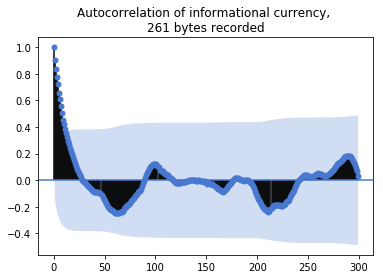

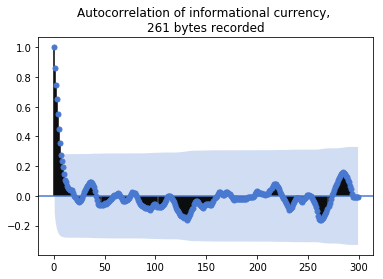

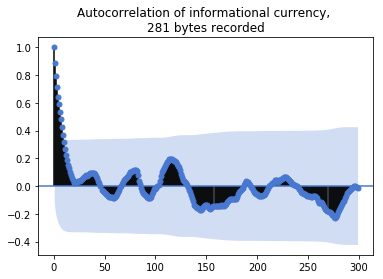

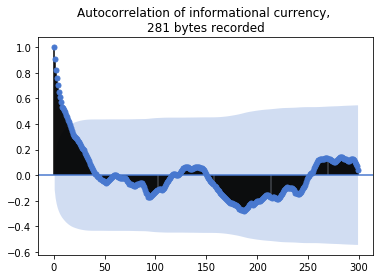

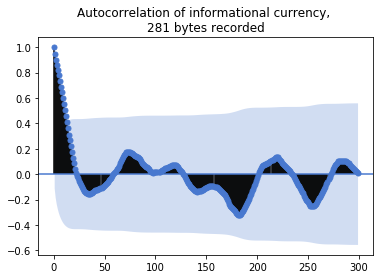

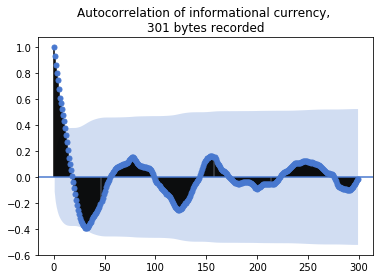

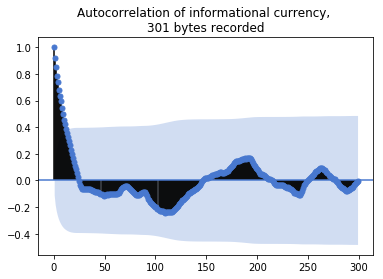

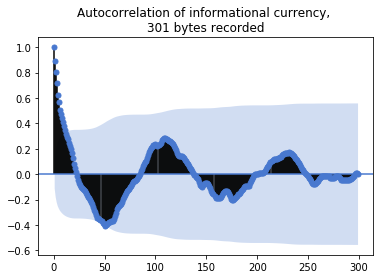

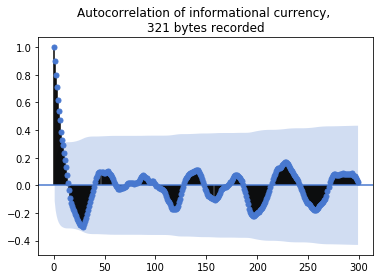

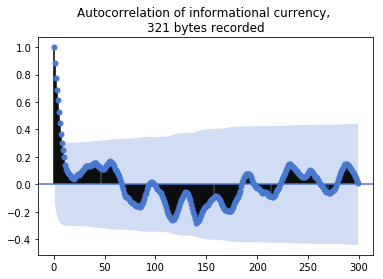

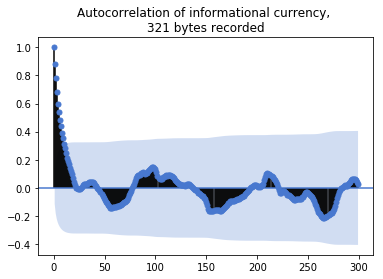

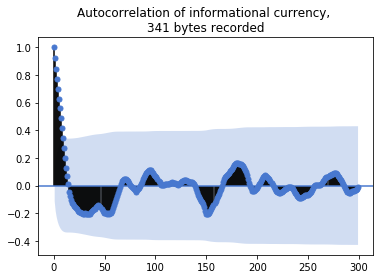

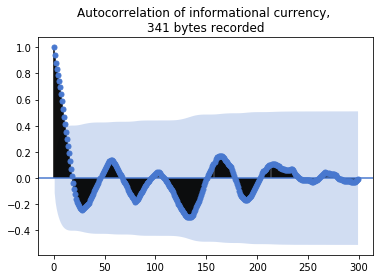

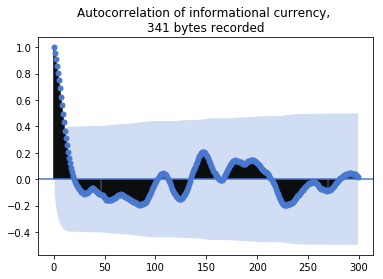

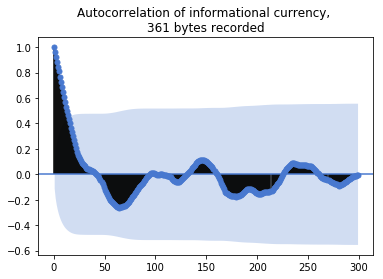

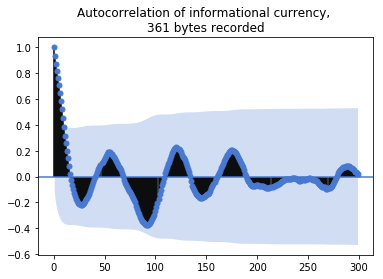

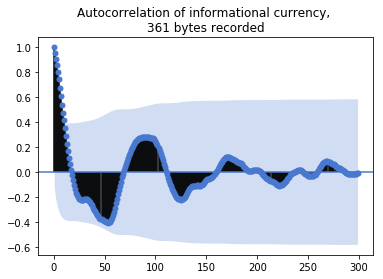

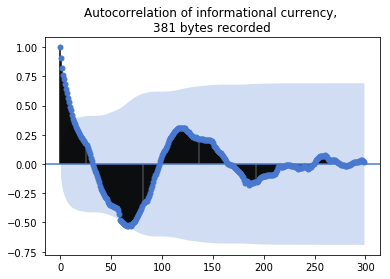

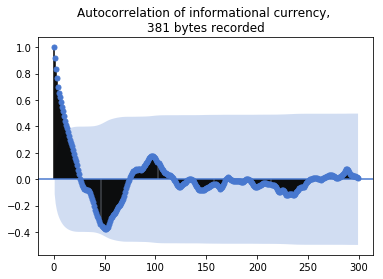

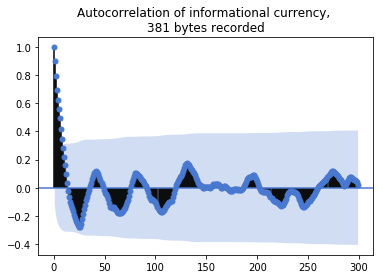

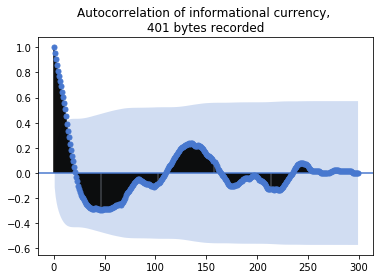

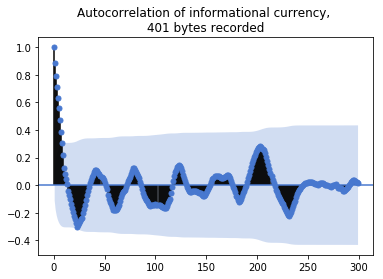

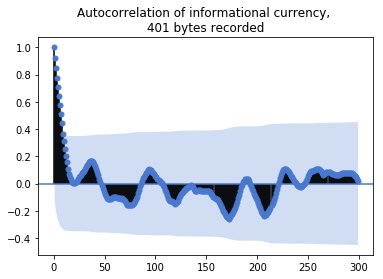

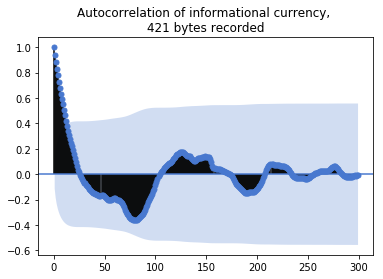

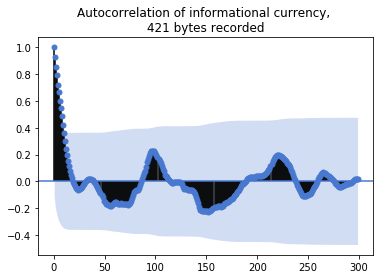

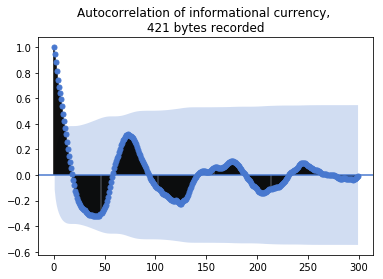

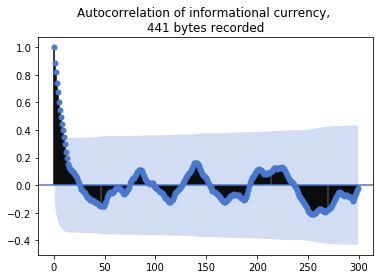

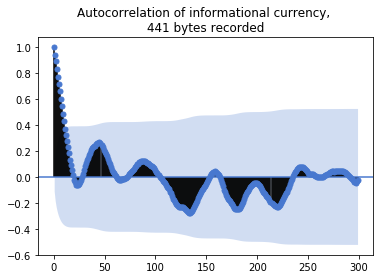

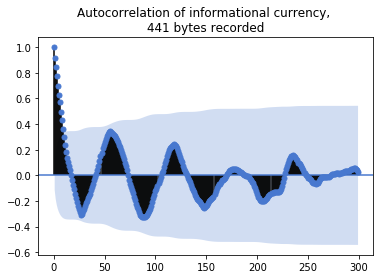

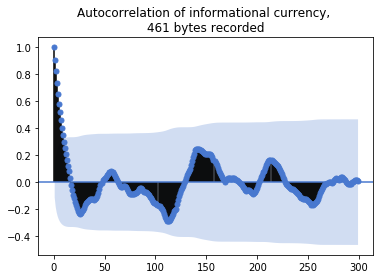

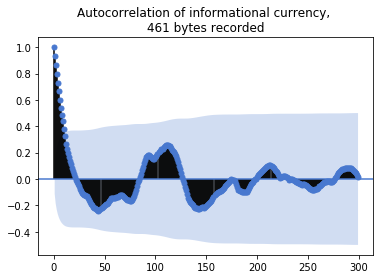

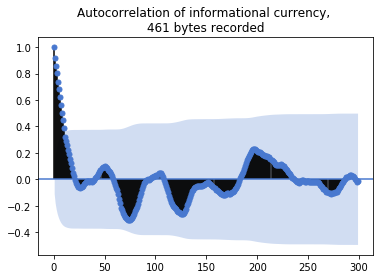

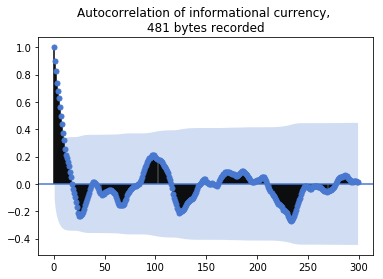

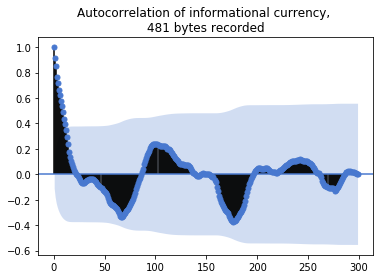

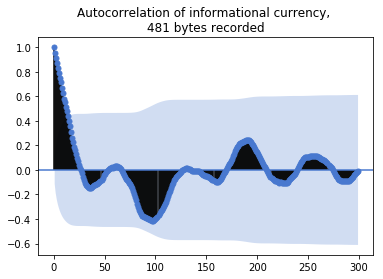

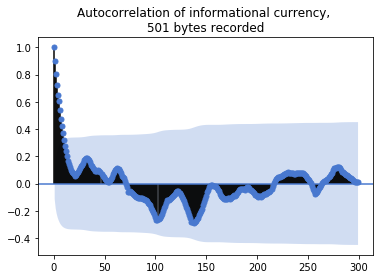

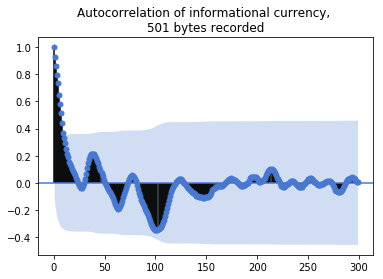

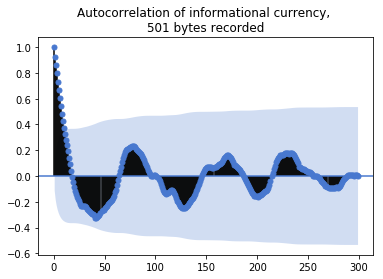

In [84]:
for i in range(len(record_bytes_model_df['agent_vars_by_tick'])):
    t = "Autocorrelation of informational currency, \n" + str(record_bytes_model_df.loc[i, 'record_bytes']) + " bytes recorded"
    _ = plot_acf(record_bytes_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values, title=t)

Some cyclicity may appear in some of the higher recording volumes. 

This may be explained by the reduction in the number of transactions that can be validated per block. As transactions wait in the mempool, informational currency will decrease on each block - until it is validated, which would prompt a leap. However, informational currency is a measure of the state of the network, not an individual edge node (sensor) ...???

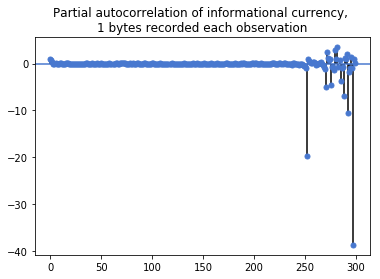

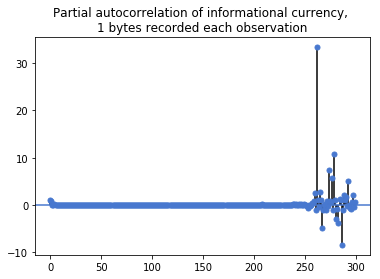

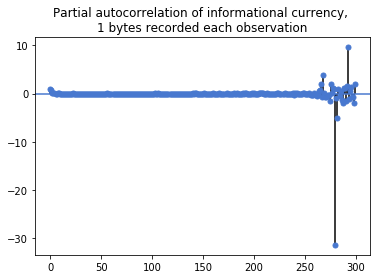

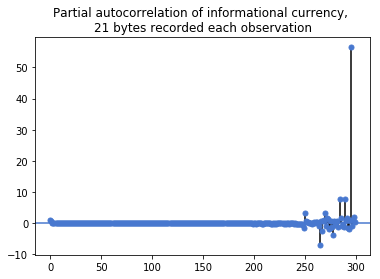

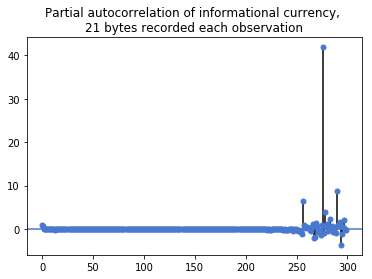

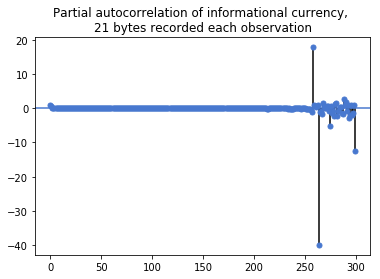

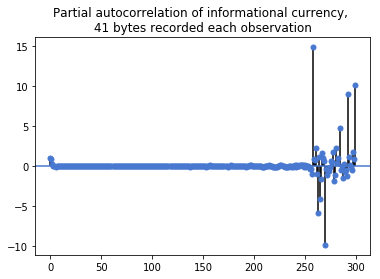

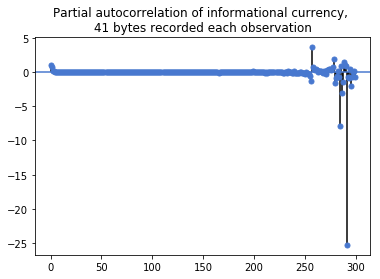

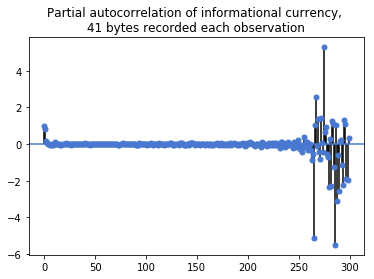

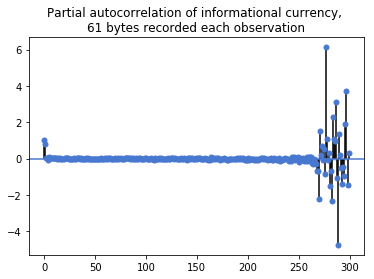

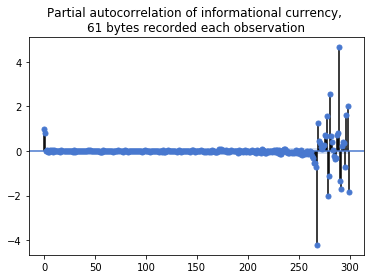

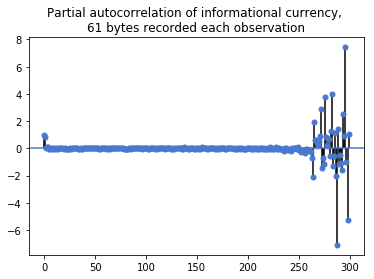

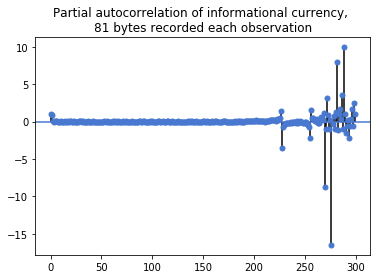

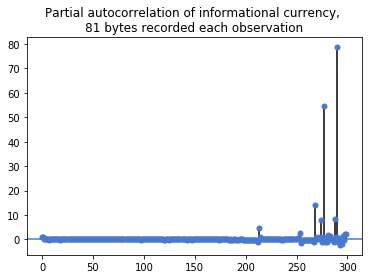

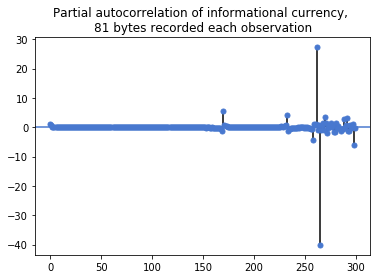

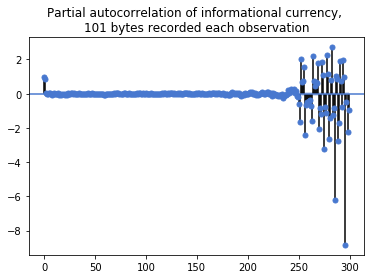

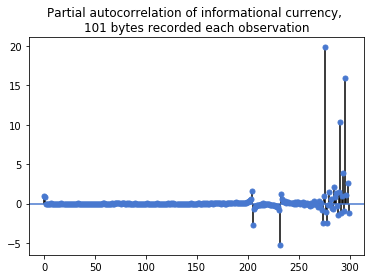

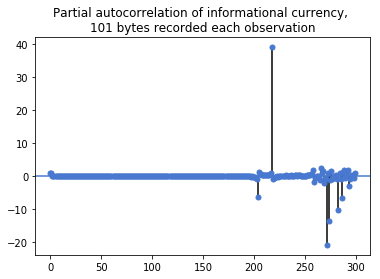

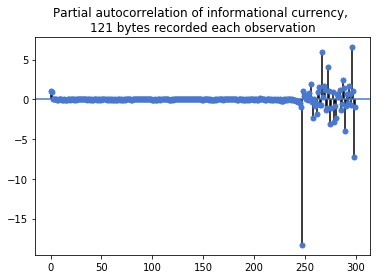

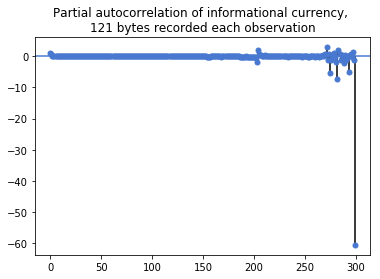

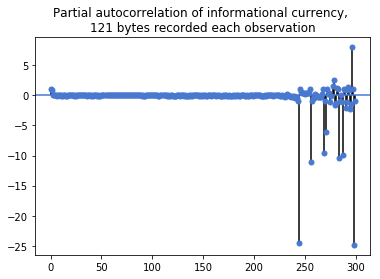

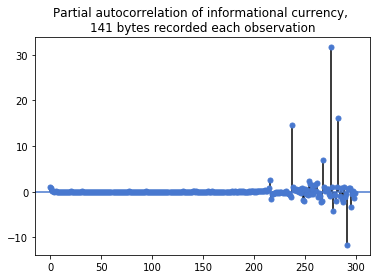

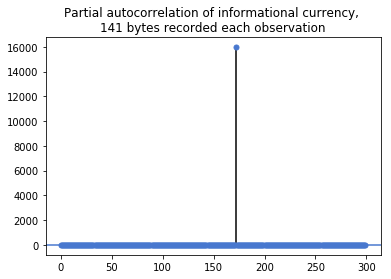

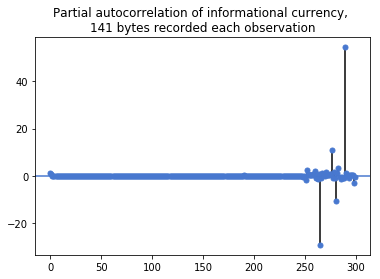

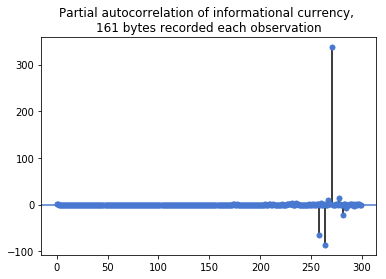

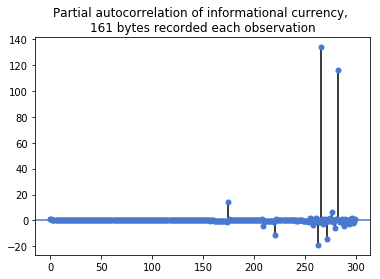

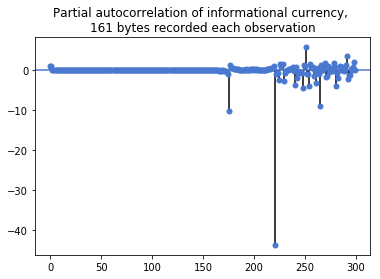

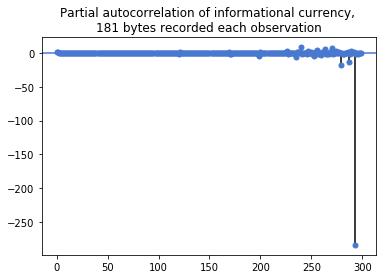

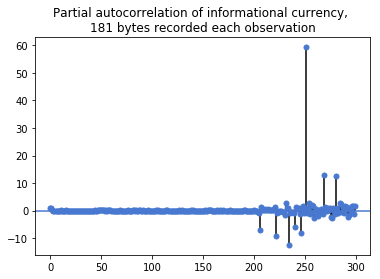

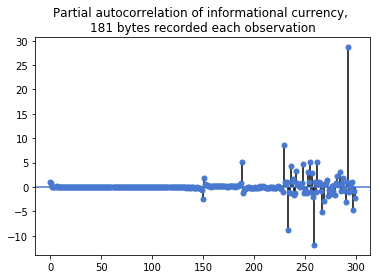

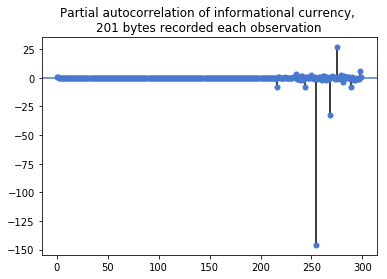

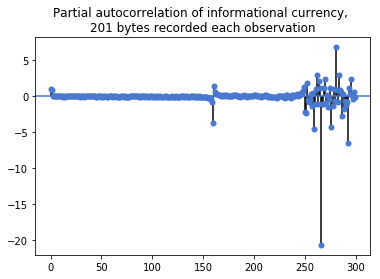

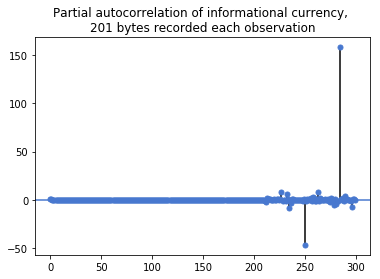

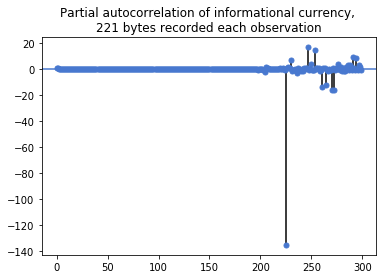

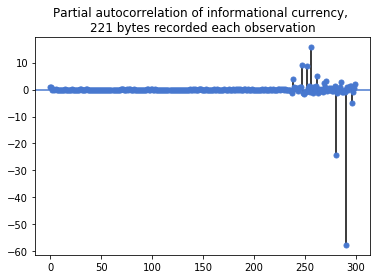

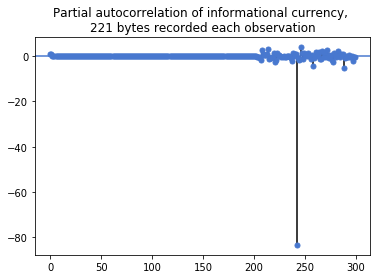

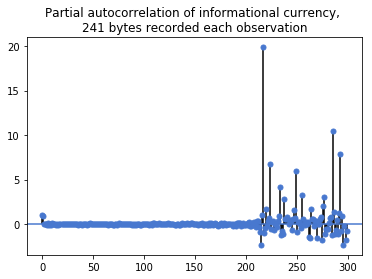

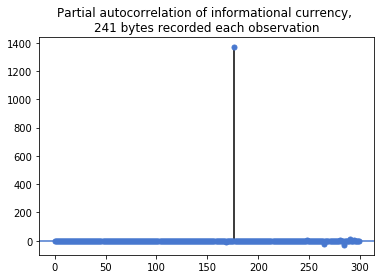

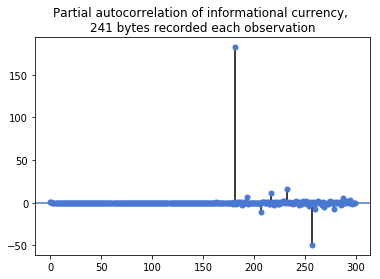

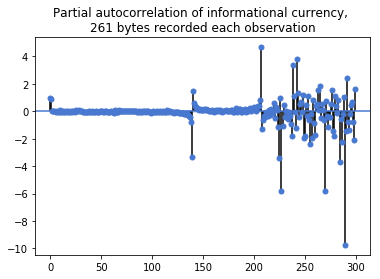

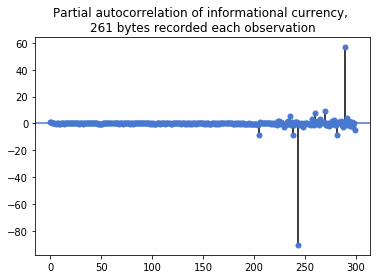

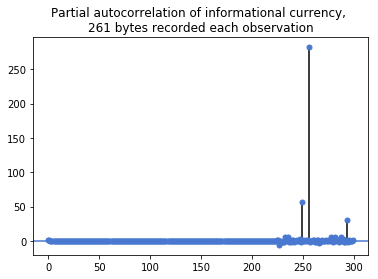

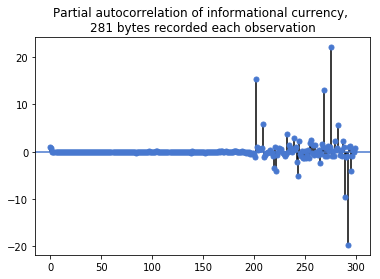

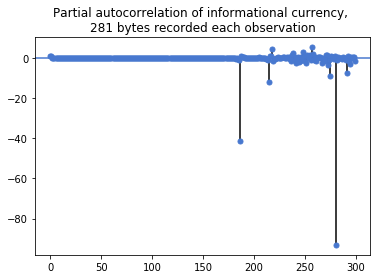

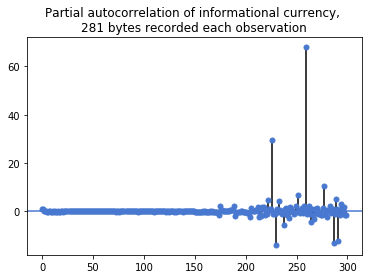

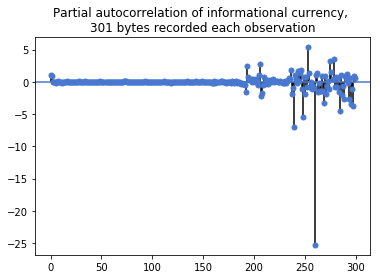

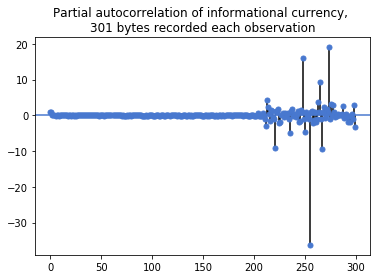

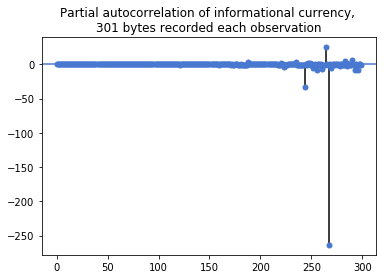

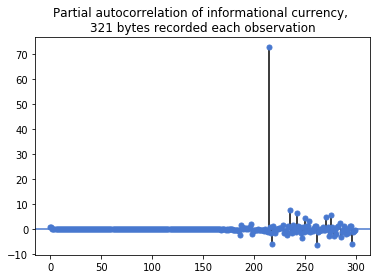

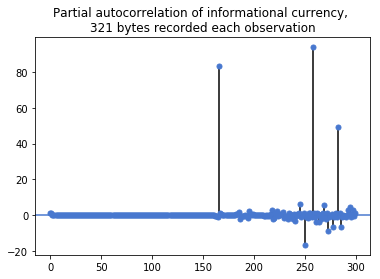

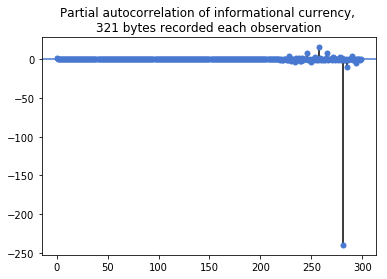

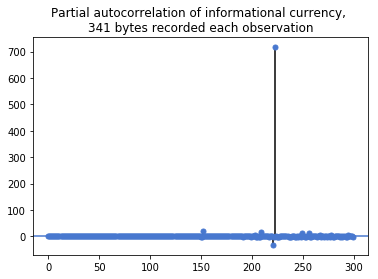

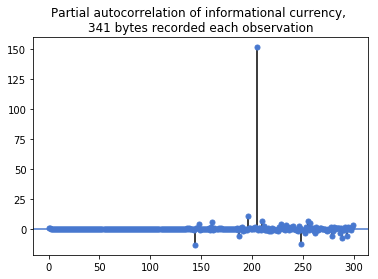

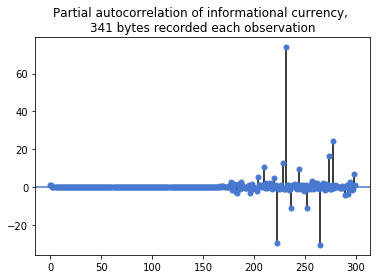

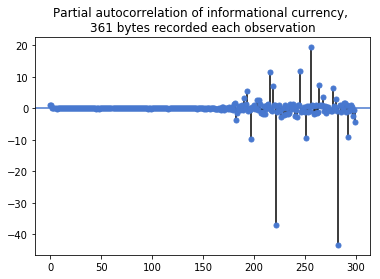

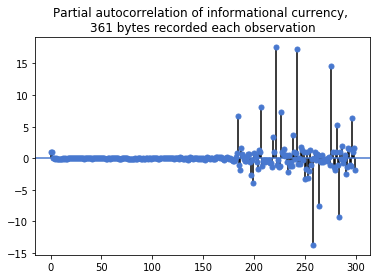

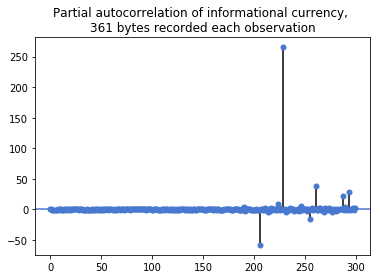

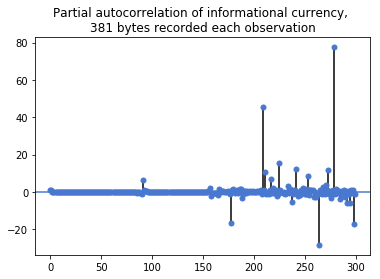

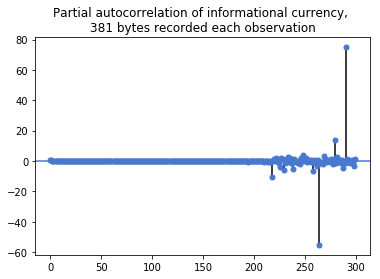

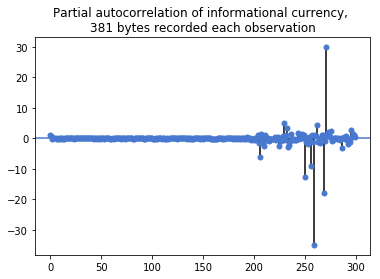

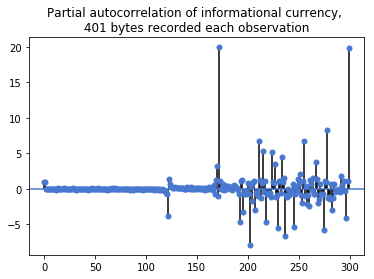

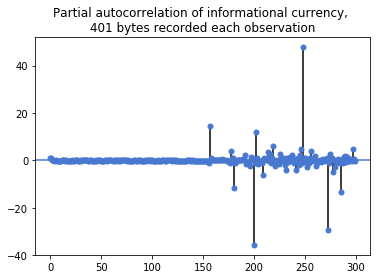

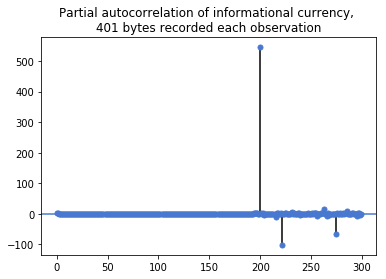

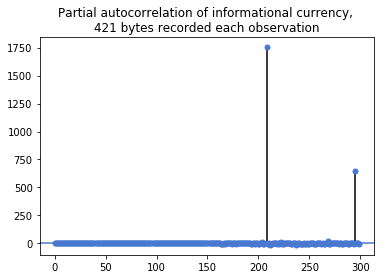

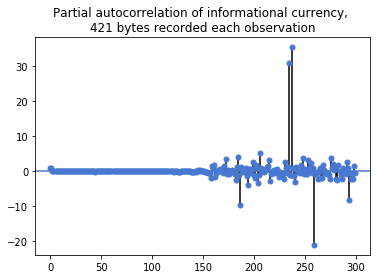

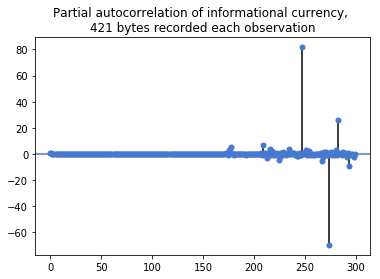

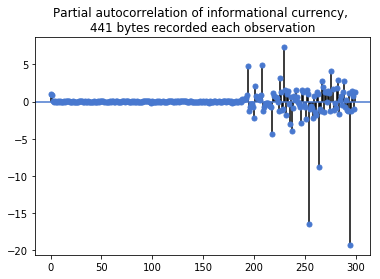

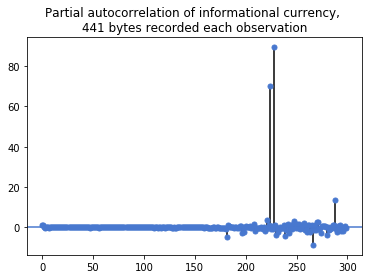

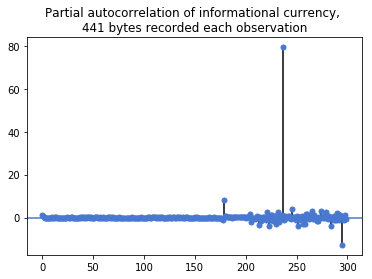

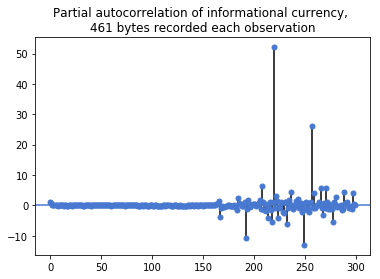

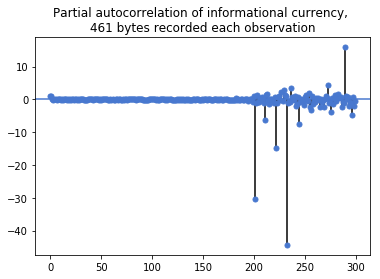

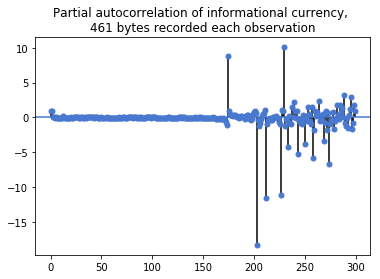

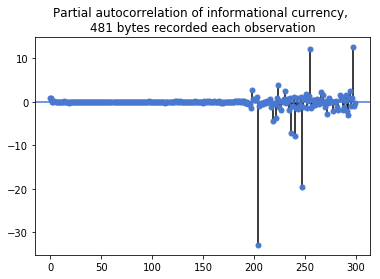

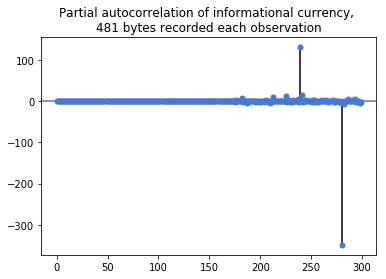

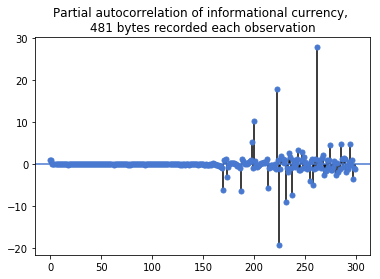

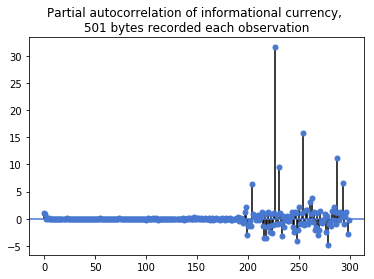

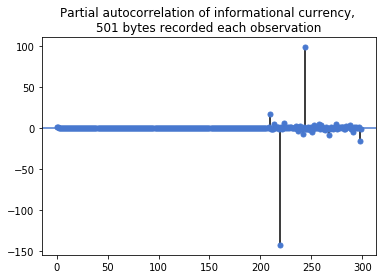

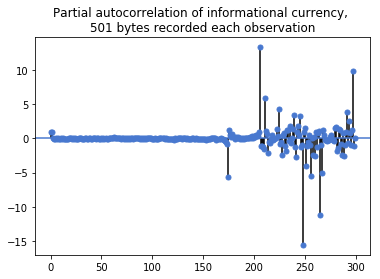

In [85]:
for i in range(len(record_bytes_model_df['agent_vars_by_tick'])):
    t = "Partial autocorrelation of informational currency, \n" + str(record_bytes_model_df.loc[i, 'record_bytes']) + " bytes recorded each observation"

    _ = plot_pacf(record_bytes_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values, title=t)

In [86]:
# Adapted from CEGExxx: Spatial Temporal Data Analysis and Data Mining final project

for i in range(len(record_bytes_model_df['agent_vars_by_tick'])):

    adf_num_sensors = adfuller(record_bytes_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values)
    print("Augmented Dickey-Fuller test, " + str(record_bytes_model_df.loc[i, 'record_bytes']) + " bytes recorded per observation")
    print('ADF Statistic: %f' % adf_num_sensors[0])
    print('p-value: %f' % adf_num_sensors[1])
    print('Critical Values:')
    for key, value in adf_num_sensors[4].items():
        print('\t%s: %.3f' % (key, value))
    print()

Augmented Dickey-Fuller test, 1 bytes recorded per observation
ADF Statistic: -10.462027
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 1 bytes recorded per observation
ADF Statistic: -10.765974
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 1 bytes recorded per observation
ADF Statistic: -17.583325
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 21 bytes recorded per observation
ADF Statistic: -8.705162
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 21 bytes recorded per observation
ADF Statistic: -7.961422
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 21 bytes recorded per observation
ADF Statistic: -19.738082
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller tes

Augmented Dickey-Fuller test, 361 bytes recorded per observation
ADF Statistic: -4.030433
p-value: 0.001259
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 381 bytes recorded per observation
ADF Statistic: -5.295056
p-value: 0.000006
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 381 bytes recorded per observation
ADF Statistic: -3.499865
p-value: 0.007991
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 381 bytes recorded per observation
ADF Statistic: -3.372196
p-value: 0.011944
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 401 bytes recorded per observation
ADF Statistic: -2.968735
p-value: 0.037919
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 401 bytes recorded per observation
ADF Statistic: -4.317033
p-value: 0.000415
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fulle

Only a few p-values (241 bytes per obs, 181 bytes per obs) on the Augmented Dickey-Fuller tests indicated the rejection of the null hypothesis and the potential of the series having a unit root, indicating nonstationarity. 

## Gwei spent

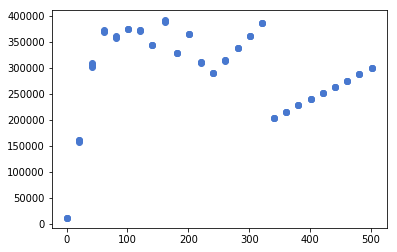

In [87]:
plt.scatter(record_bytes_model_df['record_bytes'], record_bytes_model_df['gwei_spent_post_warmup_mean'])

In [88]:
record_bytes_seg_0 = record_bytes_model_df[(record_bytes_model_df['record_bytes'] < 240) & (record_bytes_model_df['record_bytes'] > 50) ]
record_bytes_seg_1 = record_bytes_model_df[(record_bytes_model_df['record_bytes'] > 240) & (record_bytes_model_df['record_bytes'] < 322)]
record_bytes_seg_2 = record_bytes_model_df[record_bytes_model_df['record_bytes'] > 321]

<ErrorbarContainer object of 3 artists>

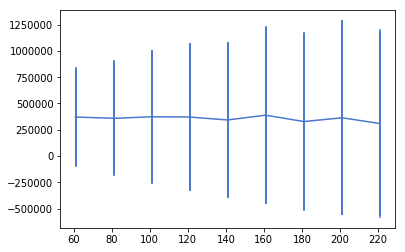

In [89]:
plt.errorbar(record_bytes_seg_0['record_bytes'], record_bytes_seg_0['gwei_spent_mean'], yerr=record_bytes_seg_0['gwei_spent_std'])

In [90]:
record_bytes_seg_0[['record_bytes','gwei_spent_mean']].corr()

record_bytes  gwei_spent_mean
record_bytes         1.000000        -0.545674
gwei_spent_mean     -0.545674         1.000000

In [91]:
pearson_gwei_record_bytes = record_bytes_seg_1[['record_bytes', 'gwei_spent_mean']].corr()

X_values_gwei_record_bytes = sms.add_constant(record_bytes_seg_1['record_bytes'])
regression_model_gwei_spent_record_bytes = sms.OLS(record_bytes_seg_1['gwei_spent_mean'], X_values_gwei_record_bytes).fit()
print(regression_model_gwei_spent_record_bytes.summary())

                            OLS Regression Results                            
Dep. Variable:        gwei_spent_mean   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.857e+05
Date:                Fri, 16 Aug 2019   Prob (F-statistic):           2.13e-28
Time:                        17:54:53   Log-Likelihood:                -105.91
No. Observations:                  15   AIC:                             215.8
Df Residuals:                      13   BIC:                             217.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2424.0278    780.810      3.105   

/Users/iv/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


In [92]:
gradient_gwei_record_bytes = regression_model_gwei_spent_record_bytes.params[1]
intercept_gwei_record_bytes = regression_model_gwei_spent_record_bytes.params[0]
rsquared_gwei_record_bytes = regression_model_gwei_spent_record_bytes.rsquared
pval_gwei_record_bytes = regression_model_gwei_spent_record_bytes.f_pvalue

In [93]:
x_lobf_gwei_record_bytes = [record_bytes_seg_1['record_bytes'].min(), record_bytes_seg_1['record_bytes'].max()]
y_lobf_gwei_record_bytes = [x_lobf_gwei_record_bytes[0] * gradient_gwei_record_bytes + intercept_gwei_record_bytes, x_lobf_gwei_record_bytes[1] * gradient_gwei_record_bytes + intercept_gwei_record_bytes]

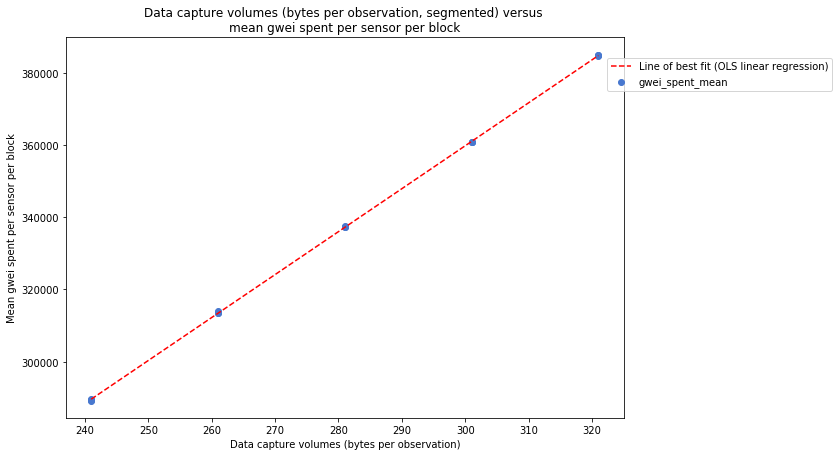

In [94]:

# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.scatter(record_bytes_seg_1['record_bytes'], record_bytes_seg_1['gwei_spent_mean'])

plt.plot(x_lobf_gwei_record_bytes, y_lobf_gwei_record_bytes, 'r--', label="Line of best fit (OLS linear regression)" )
plt.legend(bbox_to_anchor=(0.96, 0.96))
# plt.text(400, 200000, "y = " + str(round(gradient_gwei_record_bytes, 5)) + 'x + ' + str(round(intercept_gwei_record_bytes, 5)))
# plt.text(400,180000,"p = " + str(round(pval_gwei_record_bytes, 5)))
# plt.text(400,160000,r"$R^2$ = " + str(round(rsquared_gwei_record_bytes, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Data capture volumes (bytes per observation)')
_ = plt.ylabel('Mean gwei spent per sensor per block')
_ = plt.title("Data capture volumes (bytes per observation, segmented) versus \nmean gwei spent per sensor per block")

# plt.savefig('./outputs/figures/record-vol/gwei-spent/scatter-ols-segment-241-321.svg')

In [95]:
pearson_gwei_record_bytes.loc['record_bytes', 'gwei_spent_mean']

0.9999650068598113

In [96]:
pearson_gwei_record_bytes = record_bytes_seg_2[['record_bytes', 'gwei_spent_mean']].corr()

X_values_gwei_record_bytes = sms.add_constant(record_bytes_seg_2['record_bytes'])
regression_model_gwei_spent_record_bytes = sms.OLS(record_bytes_seg_2['gwei_spent_mean'], X_values_gwei_record_bytes).fit()
print(regression_model_gwei_spent_record_bytes.summary())

                            OLS Regression Results                            
Dep. Variable:        gwei_spent_mean   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.427e+06
Date:                Fri, 16 Aug 2019   Prob (F-statistic):           5.52e-61
Time:                        17:55:09   Log-Likelihood:                -169.47
No. Observations:                  27   AIC:                             342.9
Df Residuals:                      25   BIC:                             345.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          337.3999    211.449      1.596   

In [97]:
gradient_gwei_record_bytes = regression_model_gwei_spent_record_bytes.params[1]
intercept_gwei_record_bytes = regression_model_gwei_spent_record_bytes.params[0]
rsquared_gwei_record_bytes = regression_model_gwei_spent_record_bytes.rsquared
pval_gwei_record_bytes = regression_model_gwei_spent_record_bytes.f_pvalue

In [98]:
x_lobf_gwei_record_bytes = [record_bytes_seg_2['record_bytes'].min(), record_bytes_seg_2['record_bytes'].max()]
y_lobf_gwei_record_bytes = [x_lobf_gwei_record_bytes[0] * gradient_gwei_record_bytes + intercept_gwei_record_bytes, x_lobf_gwei_record_bytes[1] * gradient_gwei_record_bytes + intercept_gwei_record_bytes]

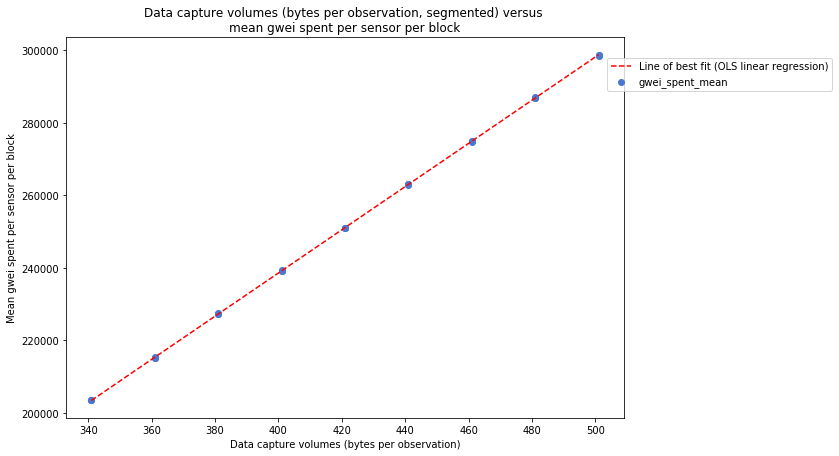

In [99]:

# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.scatter(record_bytes_seg_2['record_bytes'], record_bytes_seg_2['gwei_spent_mean'])

plt.plot(x_lobf_gwei_record_bytes, y_lobf_gwei_record_bytes, 'r--', label="Line of best fit (OLS linear regression)" )
plt.legend(bbox_to_anchor=(0.96, 0.96))
# plt.text(400, 200000, "y = " + str(round(gradient_gwei_record_bytes, 5)) + 'x + ' + str(round(intercept_gwei_record_bytes, 5)))
# plt.text(400,180000,"p = " + str(round(pval_gwei_record_bytes, 5)))
# plt.text(400,160000,r"$R^2$ = " + str(round(rsquared_gwei_record_bytes, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Data capture volumes (bytes per observation)')
_ = plt.ylabel('Mean gwei spent per sensor per block')
_ = plt.title("Data capture volumes (bytes per observation, segmented) versus \nmean gwei spent per sensor per block")

# plt.savefig('./outputs/figures/record-vol/gwei-spent/scatter-ols-segment-341-501.svg')

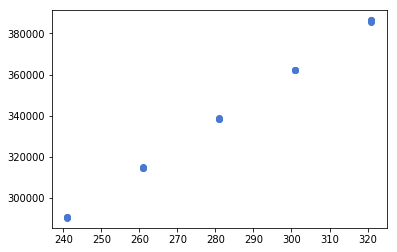

In [100]:
plt.scatter(record_bytes_seg_1['record_bytes'], record_bytes_seg_1['gwei_spent_post_warmup_mean'])

In [101]:
pearson_gwei_record_bytes = record_bytes_model_df[['record_bytes', 'gwei_spent_mean']].corr()
pearson_gwei_record_bytes

record_bytes  gwei_spent_mean
record_bytes         1.000000        -0.026929
gwei_spent_mean     -0.026929         1.000000

In [102]:
pearson_gwei_record_bytes = record_bytes_model_df[['record_bytes', 'gwei_spent_mean']].corr()

X_values_gwei_record_bytes = sms.add_constant(record_bytes_model_df['record_bytes'])
regression_model_gwei_spent_record_bytes = sms.OLS(record_bytes_model_df['gwei_spent_mean'], X_values_gwei_record_bytes).fit()
print(regression_model_gwei_spent_record_bytes.summary())

                            OLS Regression Results                            
Dep. Variable:        gwei_spent_mean   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.05515
Date:                Fri, 16 Aug 2019   Prob (F-statistic):              0.815
Time:                        17:55:22   Log-Likelihood:                -993.91
No. Observations:                  78   AIC:                             1992.
Df Residuals:                      76   BIC:                             1997.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.972e+05   1.85e+04     16.062   

In [103]:
gradient_gwei_record_bytes = regression_model_gwei_spent_record_bytes.params[1]
intercept_gwei_record_bytes = regression_model_gwei_spent_record_bytes.params[0]
rsquared_gwei_record_bytes = regression_model_gwei_spent_record_bytes.rsquared
pval_gwei_record_bytes = regression_model_gwei_spent_record_bytes.f_pvalue

In [104]:
x_lobf_gwei_record_bytes = [record_bytes_model_df['record_bytes'].min(), record_bytes_model_df['record_bytes'].max()]
y_lobf_gwei_record_bytes = [x_lobf_gwei_record_bytes[0] * gradient_gwei_record_bytes + intercept_gwei_record_bytes, x_lobf_gwei_record_bytes[1] * gradient_gwei_record_bytes + intercept_gwei_record_bytes]

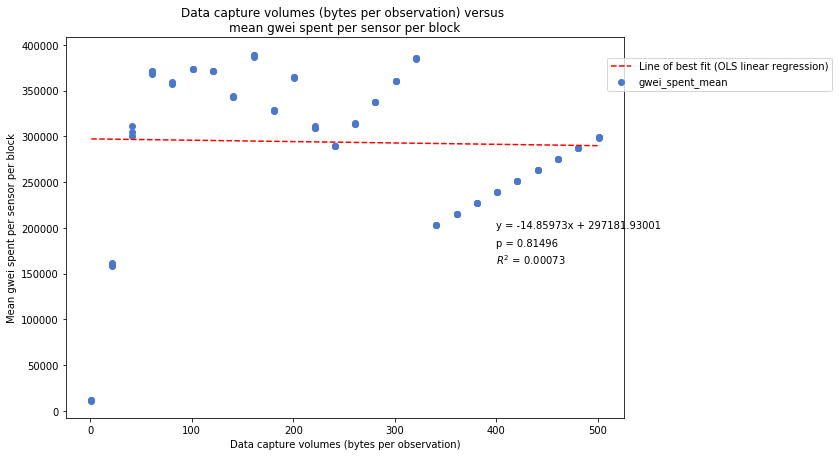

In [105]:

# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.scatter(record_bytes_model_df['record_bytes'], record_bytes_model_df['gwei_spent_mean'])
# plt.errorbar(record_bytes_model_df['record_bytes'], record_bytes_model_df['gwei_spent_mean'], yerr=record_bytes_model_df['gwei_spent_std'], fmt='o', label="Mean gwei spent per sensor +/- 1σ ")
plt.plot(x_lobf_gwei_record_bytes, y_lobf_gwei_record_bytes, 'r--', label="Line of best fit (OLS linear regression)" )
plt.legend(bbox_to_anchor=(0.96, 0.96))
plt.text(400, 200000, "y = " + str(round(gradient_gwei_record_bytes, 5)) + 'x + ' + str(round(intercept_gwei_record_bytes, 5)))
plt.text(400,180000,"p = " + str(round(pval_gwei_record_bytes, 5)))
plt.text(400,160000,r"$R^2$ = " + str(round(rsquared_gwei_record_bytes, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Data capture volumes (bytes per observation)')
_ = plt.ylabel('Mean gwei spent per sensor per block')
_ = plt.title("Data capture volumes (bytes per observation) versus \nmean gwei spent per sensor per block")

Extremely low Pearson correlation coefficient suggests that no relationship exists between the mean gwei spent per sensor per block ...

This seems weird?

## The effects of record frequency on dependent variables

In [107]:
record_freq_model_df = get_model_vars_df_from_pickle('./data/final/batch_run_1_record_freq.pkl')

Text(0.5, 1.0, 'Record frequency vs mean mining time per transaction')

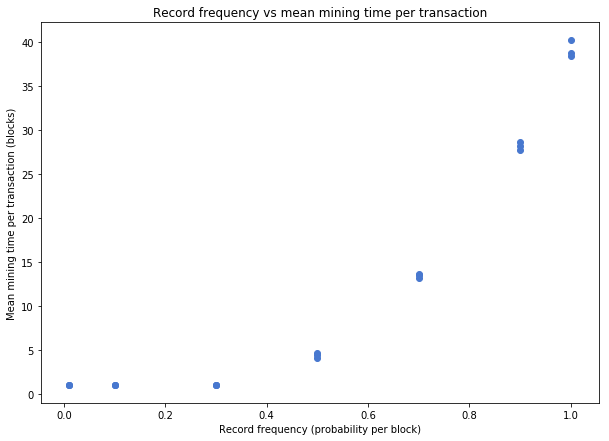

In [108]:
plt.figure(figsize=(10,7))
plt.scatter(record_freq_model_df['record_freq'], record_freq_model_df['mining_mean'])
plt.xlabel('Record frequency (probability per block)')
plt.ylabel('Mean mining time per transaction (blocks)')
plt.title('Record frequency vs mean mining time per transaction')
# plt.savefig('./outputs/figures/record-freq/mining-mean/scatter-untransformed.svg')

In [109]:
record_freq_model_df['mining_mean_sqrt'] = np.sqrt(record_freq_model_df['mining_mean'])
record_freq_model_df['mining_mean_sqrt_sqrt'] = np.sqrt(record_freq_model_df['mining_mean_sqrt'])

Text(0.5, 1.0, 'Record frequency vs transformed mean mining time per transaction')

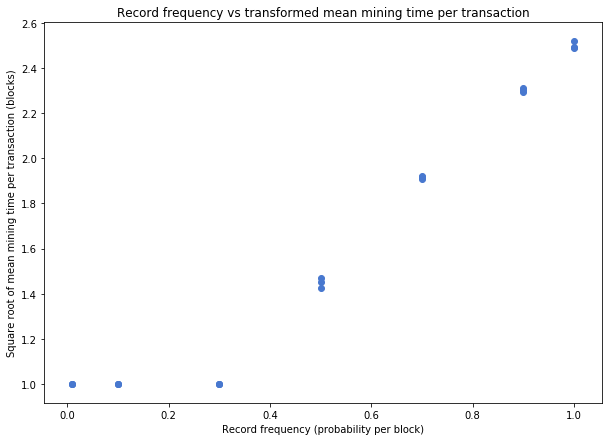

In [110]:
plt.figure(figsize=(10,7))
plt.scatter(record_freq_model_df['record_freq'], np.sqrt(record_freq_model_df['mining_mean_sqrt']))
plt.xlabel('Record frequency (probability per block)')
plt.ylabel('Square root of mean mining time per transaction (blocks)')
plt.title('Record frequency vs transformed mean mining time per transaction')
# plt.savefig('./outputs/figures/record-freq/mining-mean/scatter-ytransformed.svg')

In [111]:
record_freq_model_df_subset = record_freq_model_df[record_freq_model_df['record_freq'] > 0.2]

In [112]:
record_freq_OLS = SimpleOLSRegression(record_freq_model_df_subset, 
                                      'record_freq', 'Record frequency (probability per block)',
                                     'mining_mean_sqrt', 'Square root of mean transaction mining time (blocks)')

Pearson correlation coefficient: 0.9962077122109028
                            OLS Regression Results                            
Dep. Variable:       mining_mean_sqrt   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1704.
Date:                Fri, 16 Aug 2019   Prob (F-statistic):           3.57e-15
Time:                        17:56:17   Log-Likelihood:                 5.3352
No. Observations:                  15   AIC:                            -6.670
Df Residuals:                      13   BIC:                            -5.254
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/Users/iv/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/Users/iv/Code/ucl/dissertation/models/abm/in-development/connected_network/SensorBlockchainNetwork/analyze.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.dataframe[self.dv + '_predicted'] = self.dataframe.apply(lambda row: row[self.iv] * self.gradient + self.intercept, axis=1)
/Users/iv/Code/ucl/dissertation/models/abm/in-development/connected_network/SensorBlockchainNetwork/analyze.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

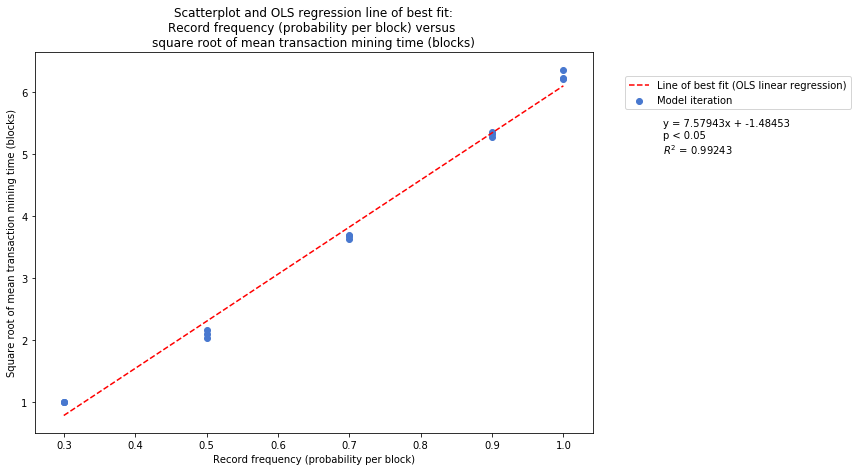

In [113]:
record_freq_OLS.scatter_OLS()#'./outputs/figures/record-freq/mining-mean/scatter-ols-ysingletransform.svg')

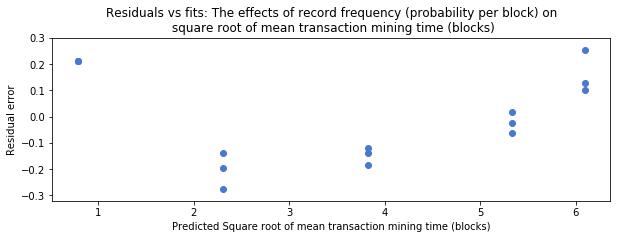

In [114]:
record_freq_OLS.plot_residuals_fits()#'./outputs/figures/record-freq/mining-mean/residuals-fits-ysingletransform.svg')

In [115]:
record_freq_OLS_double = SimpleOLSRegression(record_freq_model_df_subset, 
                                      'record_freq', 'Record frequency (probability per block)',
                                     'mining_mean_sqrt_sqrt', 'Double square root of mean transaction mining time (blocks)')

Pearson correlation coefficient: 0.9990364417375337
                              OLS Regression Results                             
Dep. Variable:     mining_mean_sqrt_sqrt   R-squared:                       0.998
Model:                               OLS   Adj. R-squared:                  0.998
Method:                    Least Squares   F-statistic:                     6736.
Date:                   Fri, 16 Aug 2019   Prob (F-statistic):           4.87e-19
Time:                           17:56:24   Log-Likelihood:                 34.551
No. Observations:                     15   AIC:                            -65.10
Df Residuals:                         13   BIC:                            -63.69
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

/Users/iv/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


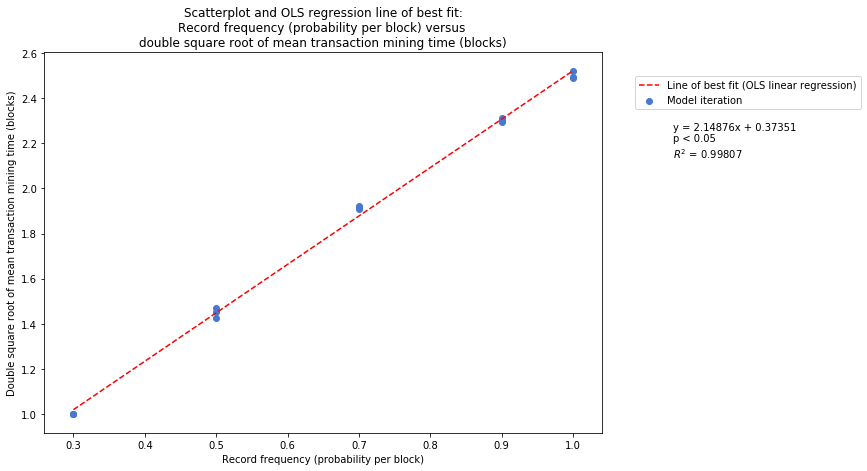

In [116]:
record_freq_OLS_double.scatter_OLS()#'./outputs/figures/record-freq/mining-mean/scatter-ols-ydoubletransform.svg')

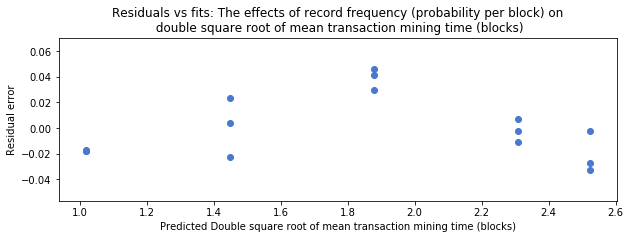

In [117]:
record_freq_OLS_double.plot_residuals_fits()#'./outputs/figures/record-freq/mining-mean/residuals-fits-ydoubletransform.svg')

### Effects of record frequency on informational currency

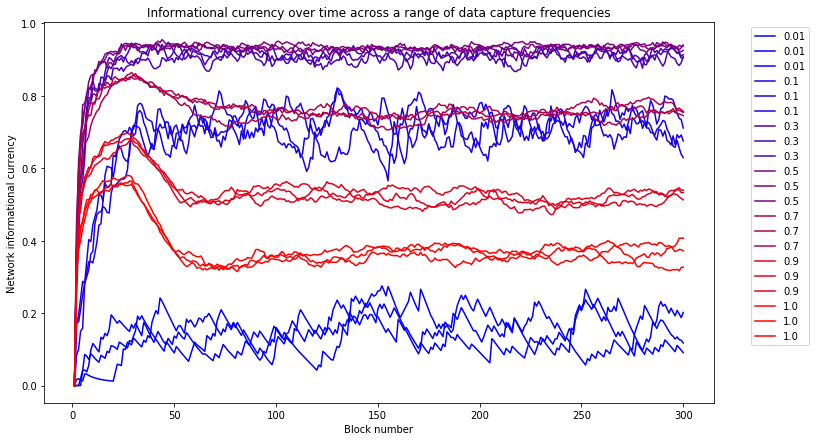

In [118]:
plt.figure(figsize=(12,7))
for i, run in record_freq_model_df[['agent_vars_by_tick']].iterrows():
    plt.plot(run[0]['informational_currency'].unstack().mean(axis=1),\
             label=record_freq_model_df.loc[i, 'record_freq'], 
             color=str(color_interpolator(
                 (record_freq_model_df.loc[i, 'record_freq'] - record_freq_model_df['record_freq'].min()) / 
                 (record_freq_model_df['record_freq'].max() - record_freq_model_df['record_freq'].min())))) #, cmap='gray', c=record_bytes_model_df['record_bytes'] )

plt.legend(bbox_to_anchor=(1.15, 1))
plt.title('Informational currency over time across a range of data capture frequencies')
plt.xlabel('Block number')
_ = plt.ylabel("Network informational currency")

# plt.savefig('./outputs/figures/record-freq/info-currency/time-series-across-record-volumes.svg')

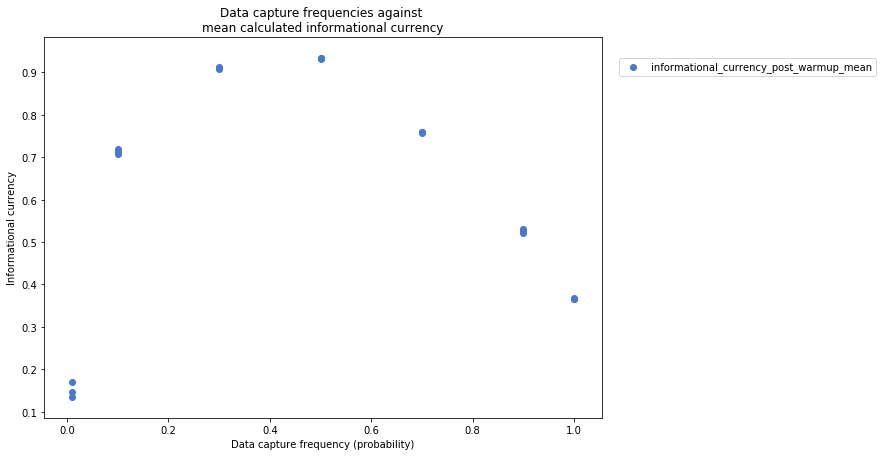

In [119]:
# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.scatter(record_freq_model_df['record_freq'], record_freq_model_df['informational_currency_post_warmup_mean'])#, yerr=record_bytes_model_df['informational_currency_post_warmup_std'], fmt='o', label="Mean informational currency +/- 1σ ")

plt.legend(bbox_to_anchor=(1.5, 0.96))
# plt.text(20, 130, "y = " + str(round(gradient, 5)) + 'x + ' + str(round(intercept, 5)))
# plt.text(20,120,"p = " + str(round(pval, 5)))
# plt.text(20,110,r"$R^2$ = " + str(round(rsquared, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Data capture frequency (probability)')
_ = plt.ylabel('Informational currency')
_ = plt.title("Data capture frequencies against \nmean calculated informational currency")

# plt.savefig('./outputs/figures/record-freq/info-currency/mean-post-warmup-scatter.svg')

#### Assessing stationarity of time series

In [120]:
record_freq_adf_df = pd.DataFrame(columns=['record_freq', 'adf_statistic', 'p_value', '1%_critical_value', '5%_critical_value', '10%_critical_value'])

for i in range(len(record_freq_model_df['agent_vars_by_tick'])):
    adf_results = calculate_adf_results(record_freq_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values)
    adf_results['record_freq'] = record_freq_model_df.loc[i, 'record_freq']

    record_freq_adf_df = record_freq_adf_df.append(pd.DataFrame([adf_results], columns=adf_results.keys()))

record_freq_adf_df = record_freq_adf_df.reset_index().drop(columns=['index'])



In [121]:
calculate_adf_results(record_freq_model_df['agent_vars_by_tick'][19]['informational_currency'].unstack().mean(axis=1).values)

{'adf_statistic': -3.754034330281175,
 'p_value': 0.003414212904158487,
 '1%_critical_value': -3.4534232986669546,
 '5%_critical_value': -2.8716994185534745,
 '10%_critical_value': -2.5721833625116144}

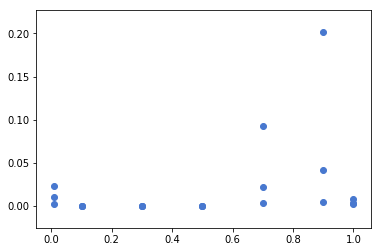

In [122]:
plt.scatter(record_freq_adf_df['record_freq'], record_freq_adf_df['p_value'])

In [123]:
record_freq_adf_df[record_freq_adf_df['p_value'] > 0.05]

1%_critical_value  10%_critical_value  5%_critical_value  adf_statistic  \
12          -3.453182           -2.572127          -2.871593      -2.601889   
17          -3.452637           -2.571999          -2.871354      -2.213026   

     p_value  record_freq  
12  0.092607          0.7  
17  0.201552          0.9

### Effects of record frequency on gwei spent

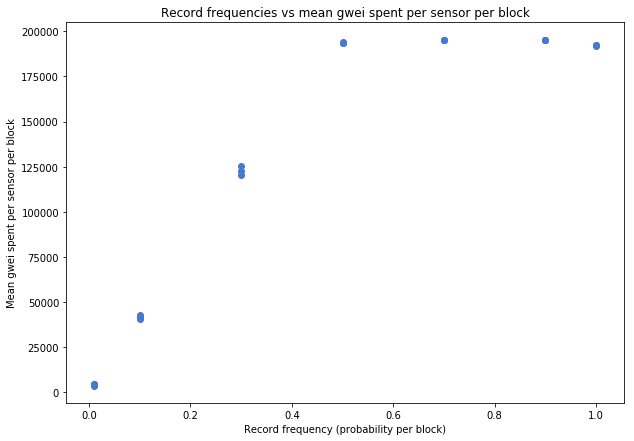

In [124]:
plt.figure(figsize=(10,7))
plt.scatter(record_freq_model_df['record_freq'], record_freq_model_df['gwei_spent_mean'], label='Model iteration')
plt.title('Record frequencies vs mean gwei spent per sensor per block')
plt.xlabel('Record frequency (probability per block)')
_ = plt.ylabel('Mean gwei spent per sensor per block')

# plt.savefig('./outputs/figures/record-freq/gwei-spent/scatter.svg')

In [125]:
record_freq_model_df_subset = record_freq_model_df[record_freq_model_df['record_freq'] < 0.5]

In [126]:
record_freq_model_df_subset['gwei_spent_mean_log'] = np.log(record_freq_model_df_subset['gwei_spent_mean'])

/Users/iv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [127]:
record_freq_gwei_OLS = SimpleOLSRegression(record_freq_model_df_subset, 'record_freq', "Record frequency (probability per block)", "gwei_spent_mean", "Mean gwei spent per sensor per block")

Pearson correlation coefficient: 0.9996183922320676
                            OLS Regression Results                            
Dep. Variable:        gwei_spent_mean   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     9166.
Date:                Fri, 16 Aug 2019   Prob (F-statistic):           3.57e-12
Time:                        17:57:22   Log-Likelihood:                -77.752
No. Observations:                   9   AIC:                             159.5
Df Residuals:                       7   BIC:                             159.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/Users/iv/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


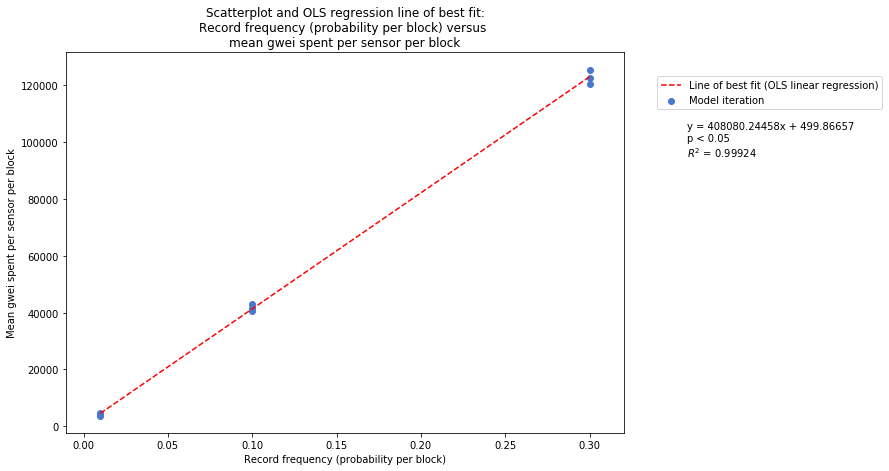

In [128]:
record_freq_gwei_OLS.scatter_OLS()#'./outputs/figures/record-freq/gwei-spent/scatter-ols-subset.svg')

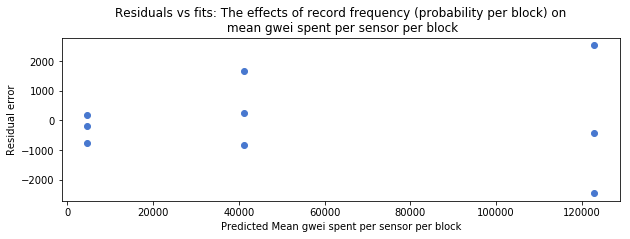

In [129]:
record_freq_gwei_OLS.plot_residuals_fits()#'./outputs/figures/record-freq/gwei-spent/residuals-fits-subset.svg')

In [130]:
record_freq_model_df[['record_freq', 'gwei_spent_mean']].describe()

record_freq  gwei_spent_mean
count    21.000000        21.000000
mean      0.501429    135005.952381
std       0.365394     77359.130107
min       0.010000      3818.750000
25%       0.100000     42969.791667
50%       0.500000    192168.750000
75%       0.900000    194968.750000
max       1.000000    195385.416667